In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc3 as pm
import scipy.stats as sps

sns.set()

confirmed_min = 500
dead_min = 10

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
us_state_dict = pd.read_pickle('us_state_dict.pkl')
ny = us_state_dict['New York']
ny.index = pd.DatetimeIndex(ny.index)
ny.sort_index(inplace=True)
ny

confirmed  deceased       inc  dead_inc    factor  dead_factor  \
2020-03-14      525.0       2.0     104.0       2.0  1.247031          NaN   
2020-03-15      732.0       3.0     207.0       1.0  1.394286     1.500000   
2020-03-16      967.0      10.0     235.0       7.0  1.321038     3.333333   
2020-03-17     1706.0      13.0     739.0       3.0  1.764219     1.300000   
2020-03-18     2495.0      16.0     789.0       3.0  1.462485     1.230769   
...               ...       ...       ...       ...       ...          ...   
2020-08-25   430774.0   32918.0   46199.0    2009.0  1.120130     1.064997   
2020-08-26   431340.0   32921.0     566.0       3.0  1.001314     1.000091   
2020-08-27   432131.0   32926.0   20931.0     318.0  1.050902     1.009752   
2020-08-28   432767.0   32934.0    2622.0      47.0  1.006096     1.001429   
2020-08-29   433402.0   32938.0  129030.0    9351.0  1.423922     1.396447   

                density    gdp  pct_dead    conf_per_M   dead_per_M  
2020-03-14  1068.424744  89076  0.380952     27.005521     0.102878  
2020-03-15  1068.424744  89076  0.409836     37.653413     0.154317  
2020-03-16  1068.424744  89076  1.034126     49.741598     0.514391  
2020-03-17  1068.424744  89076  0.762016     87.755085     0.668708  
2020-03-18  1068.424744  89076  0.641283    128.340525     0.823025  
...                 ...    ...       ...           ...          ...  
2020-08-25  1068.424744  89076  7.641594  22158.621790  1693.271906  
2020-08-26  1068.424744  89076  7.632262  22187.736314  1693.426223  
2020-08-27  1068.424744  89076  7.619449  22228.424633  1693.683419  
2020-08-28  1068.424744  89076  7.610100  22261.139893  1694.094932  
2020-08-29  1068.424744  89076  7.599873  22293.803714  1694.300688  

[169 rows x 11 columns]

In [3]:
dick = pd.read_pickle('country_data.pkl')

def strip(x):
    return x.replace('\t','')

country_populations = pd.read_csv('world_pop.csv',
                                  sep=';',header=None,index_col=0,names=['population'],
                                 thousands=',',converters={0 : strip})

dick['New York'] = ny

swe = dick['Sweden']
us = dick['US']
india = dick['India']

swe_population = country_populations.loc['Sweden','population']
swe['conf_per_M'] = swe['confirmed'] / (swe_population / 1e6)
swe['dead_per_M'] = swe['deceased'] / (swe_population / 1e6)
us['dead_per_M'] = us['deceased'] / (country_populations.loc['US','population'] / 1e6) 


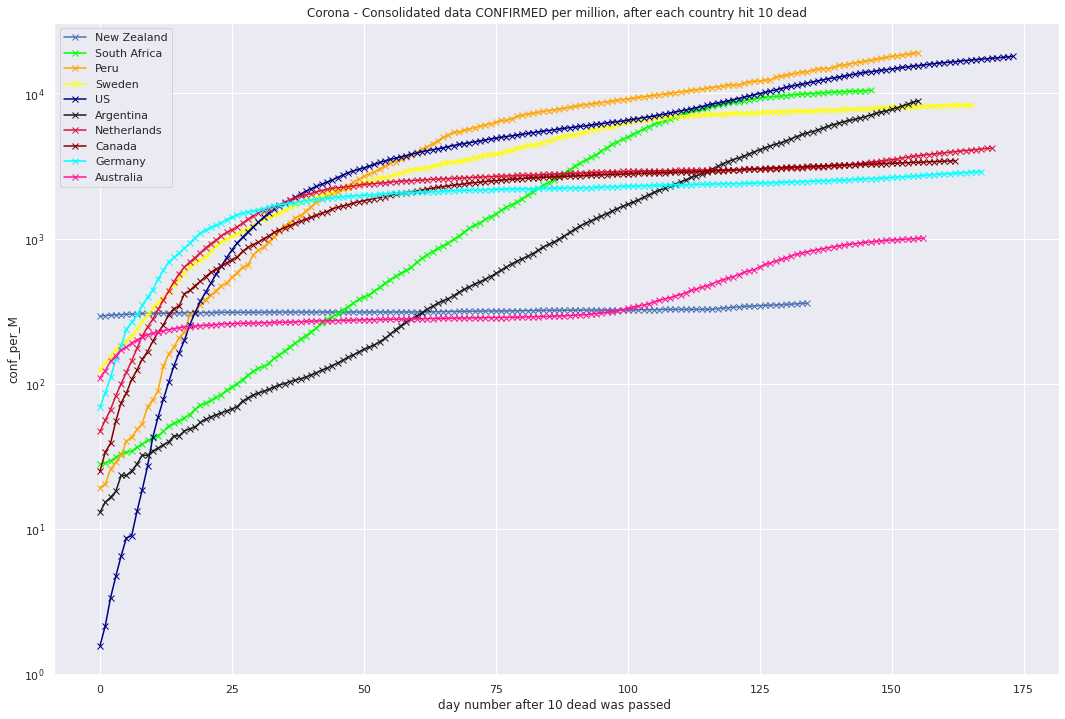

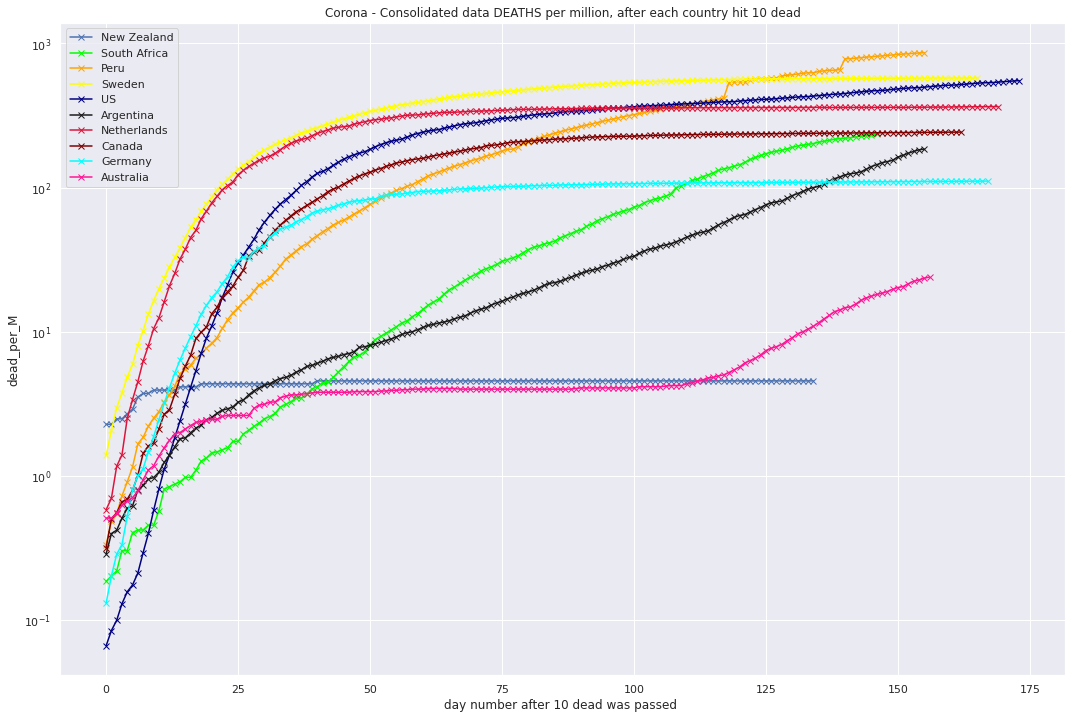

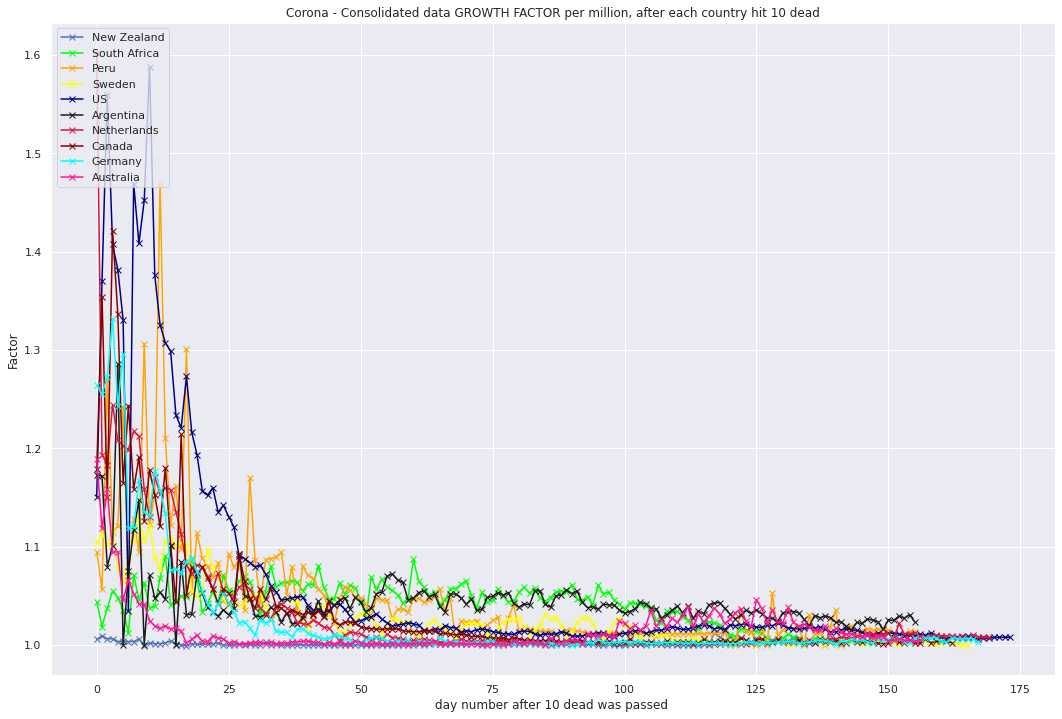

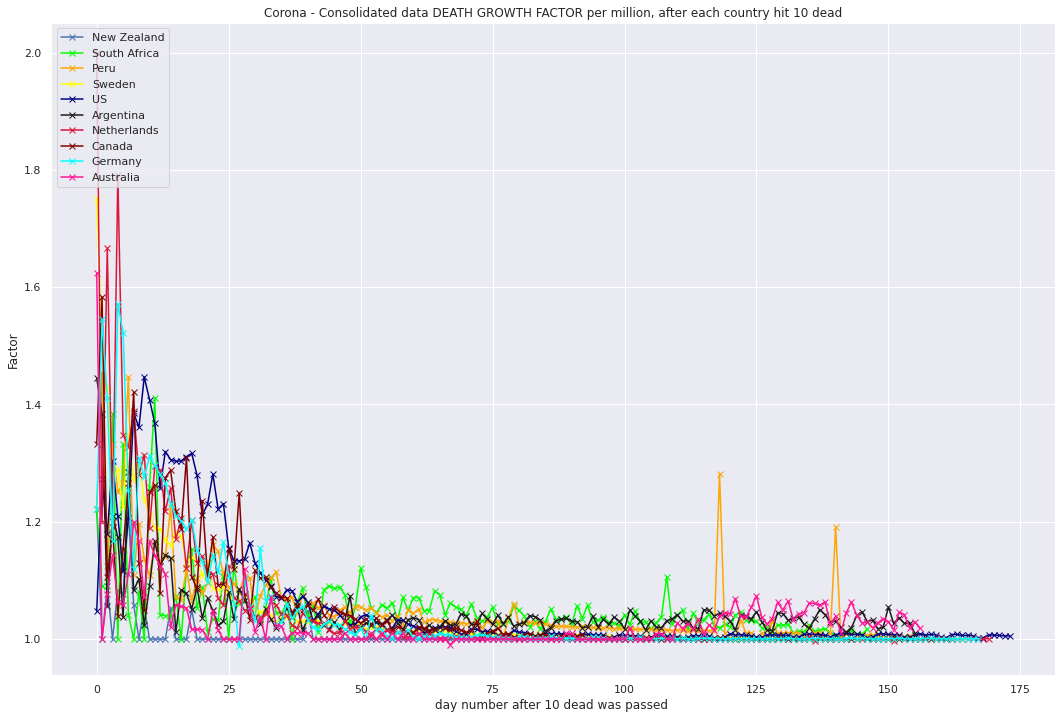

In [4]:

countries = ['New Zealand','South Africa','Peru','Sweden','US',
             'Argentina','Netherlands','Canada','Germany','Australia']

#countries = ['United Kingdom','Finland','Norway','Denmark','Sweden','Iceland']
#countries = ['Sweden']

colors = ['b','lime','orange','yellow','navy','k','crimson','maroon','cyan','deeppink']


plt.figure(figsize=(18,12))
plt.title('Corona - Consolidated data CONFIRMED per million, after each country hit {} dead'.format(dead_min))
plt.yscale('log')

#longest history
max_x = len(dick['Italy'])

def process_country(country,param,color_idx):
    df = dick[country]
    
    df.sort_index(inplace=True)
    
    df.head()
    
    try:
        df = df.drop(['dead_conf_ratio','conf_over_dead'],axis=1)
    except:
        print ('no cols dead_conf_ratio,conf_over_dead  for {} - skipping delete'.format(country))
   
    population = country_populations.loc[country,'population']
    df['conf_per_M'] = df['confirmed'] / (population / 1e6)
    df['dead_per_M'] = df['deceased'] / (population / 1e6)
    df['factor_per_M'] = df['conf_per_M'] / df['conf_per_M'].shift()
    df['factor_dead_per_M'] = df['dead_per_M'] / df['dead_per_M'].shift()
    
    mask = ( ( df['confirmed'] >= confirmed_min ) & ( df['deceased'] >= dead_min))
    df = df[mask]
    df.reset_index(inplace=True)
    
    #slope,intercept,_,_,_ = sps.linregress(df.index,df[param])
    #slope = np.log10(slope)
    #intercept = np.log10(intercept)
    
    #X = np.linspace(min(df.index) ,max(df.index),40)
    
    #plt.plot([X[i] * slope + intercept for i in range(len(X))],'--',color=colors[color_idx],
             #label=country +'_regression, slope:{:.2f} intercept:{:.2f}'.format(slope,intercept))
    
    plt.plot(df[param],'x-',label=country,color=colors[color_idx])
    
    plt.legend(loc='upper left')  
    
    if 'factor' in param:
        plt.ylabel('Factor')
    else:
        plt.ylabel('{}'.format(param))
        
    plt.xlabel('day number after {} dead was passed '.format(dead_min))
    plt.yscale('log')
    
    ### CHANGE LIMIT WHEN NEEDED ###
    #plt.xlim([0,max_x])
    
    
    
param = 'conf_per_M'

for i,c in enumerate(countries):
    process_country(c,param,i)

plt.savefig('Corona_consolidated_min_confirmed.jpg',format='jpg')

plt.figure(figsize=(18,12))
plt.title('Corona - Consolidated data DEATHS per million, after each country hit {} dead'.format(dead_min))

param = 'dead_per_M'

for i,c in enumerate(countries):
    process_country(c,param,i)
  
plt.savefig('Corona_consolidated_min_dead.jpg',format='jpg')

plt.figure(figsize=(18,12))
plt.title('Corona - Consolidated data GROWTH FACTOR per million, after each country hit {} dead'.format(dead_min))

param = 'factor_per_M'

for i,c in enumerate(countries):
    process_country(c,param,i)
    plt.yscale('linear')
    
plt.savefig('Corona_consolidated_min_factor.jpg',format='jpg')

plt.figure(figsize=(18,12))
plt.title('Corona - Consolidated data DEATH GROWTH FACTOR per million, after each country hit {} dead'.format(dead_min))

param = 'factor_dead_per_M'

for i,c in enumerate(countries):
    process_country(c,param,i)
    plt.yscale('linear')
    
    
plt.savefig('Corona_consolidated_dead_min_factor.jpg',format='jpg')


In [5]:
def smooth(x,window_len=10,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string   
    """
    
    '''
    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"

    '''
    x = np.array(x,dtype=float) #conv from dataframe col to array
    s=np.r_[2*x[0]-x[window_len:1:-1],x,2*x[-1]-x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='same')
    return y[window_len-1:-window_len+1]


New Zealand
            confirmed    factor   inc  deceased  dead_factor  dead_inc  \
2020-08-25       1695  1.002959   5.0        22          1.0       0.0   
2020-08-26       1702  1.004130   7.0        22          1.0       0.0   
2020-08-27       1714  1.007051  12.0        22          1.0       0.0   
2020-08-28       1727  1.007585  13.0        22          1.0       0.0   
2020-08-29       1729  1.001158   2.0        22          1.0       0.0   

            pct_dead  conf_over_dead  dead_conf_ratio  
2020-08-25  1.297935       77.045455         0.997050  
2020-08-26  1.292597       77.363636         0.995887  
2020-08-27  1.283547       77.909091         0.992999  
2020-08-28  1.273885       78.500000         0.992472  
2020-08-29  1.272412       78.590909         0.998843  
South Africa
            confirmed    factor     inc  deceased  dead_factor  dead_inc  \
2020-08-25     613017  1.002563  1567.0     13308     1.011323     149.0   
2020-08-26     615701  1.004378  2684.0   

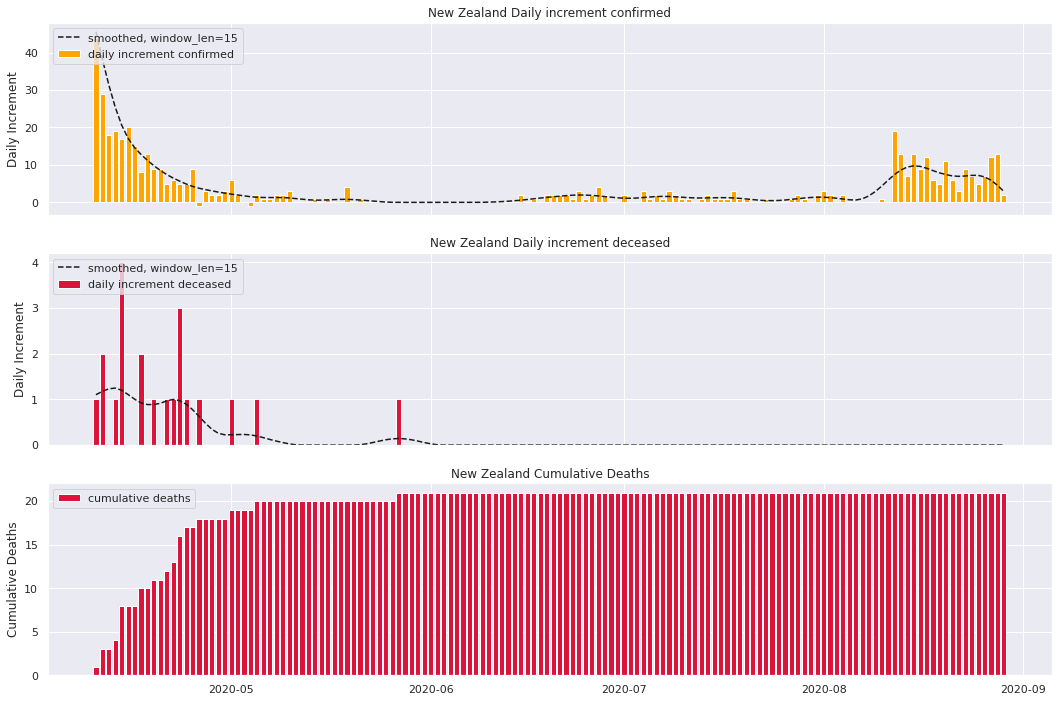

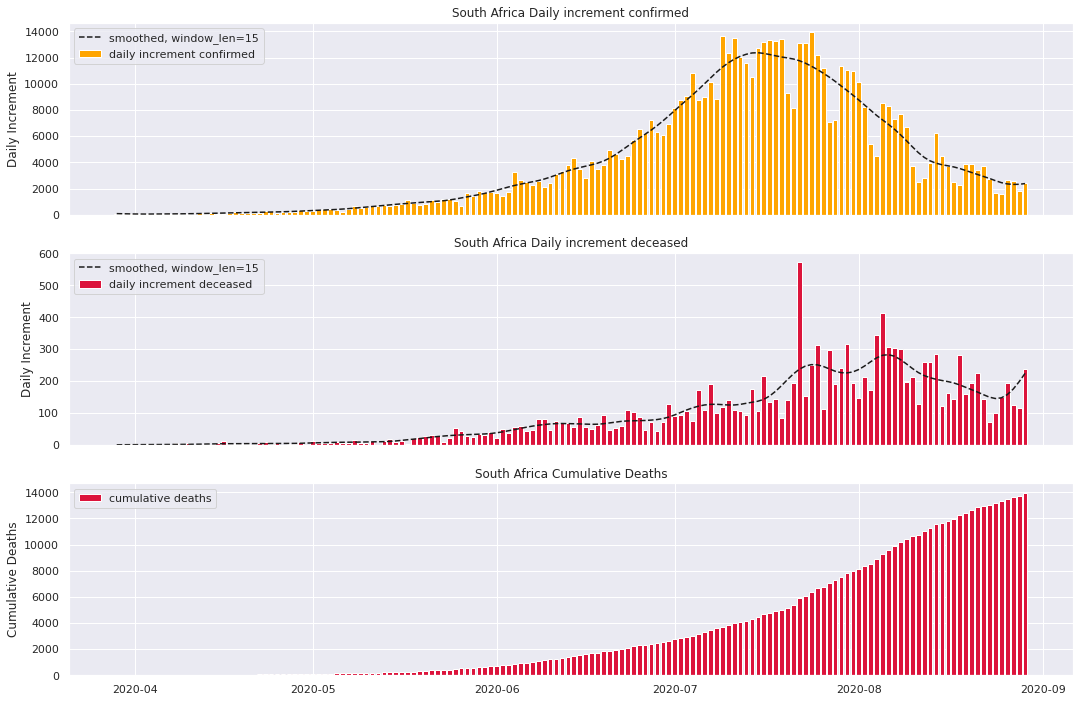

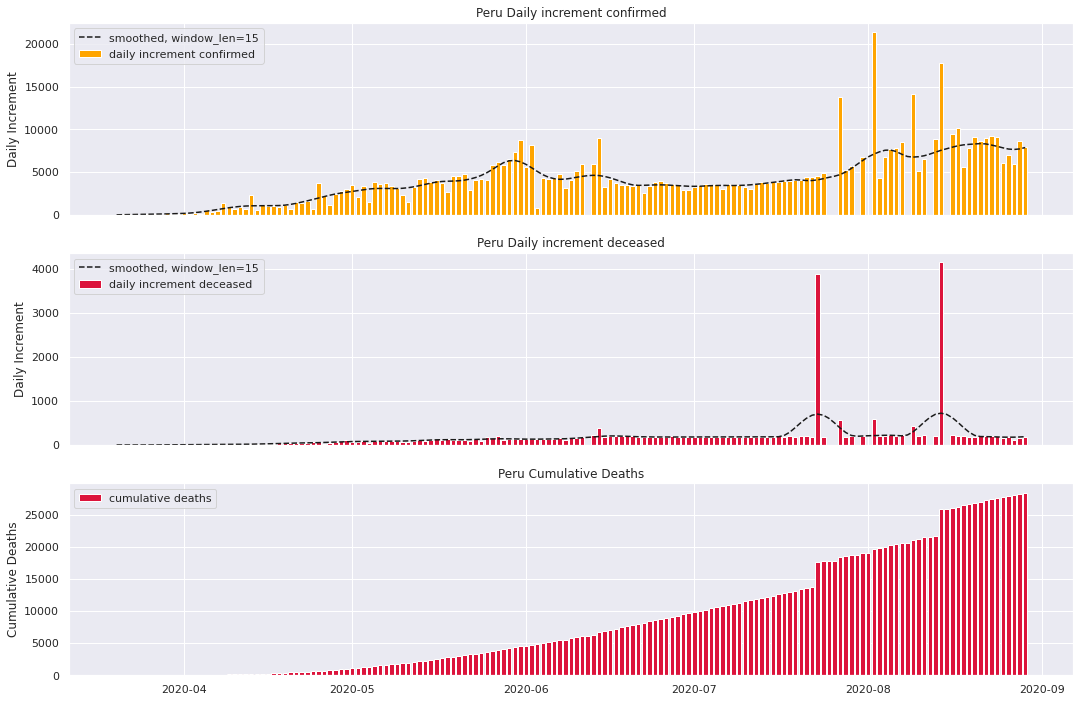

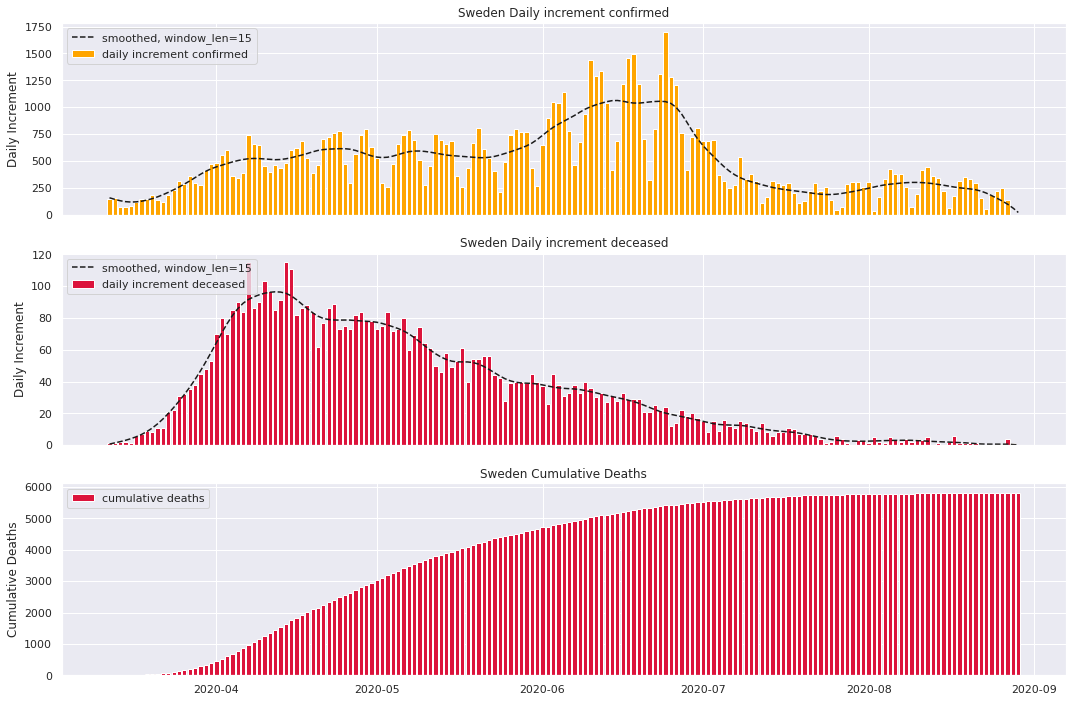

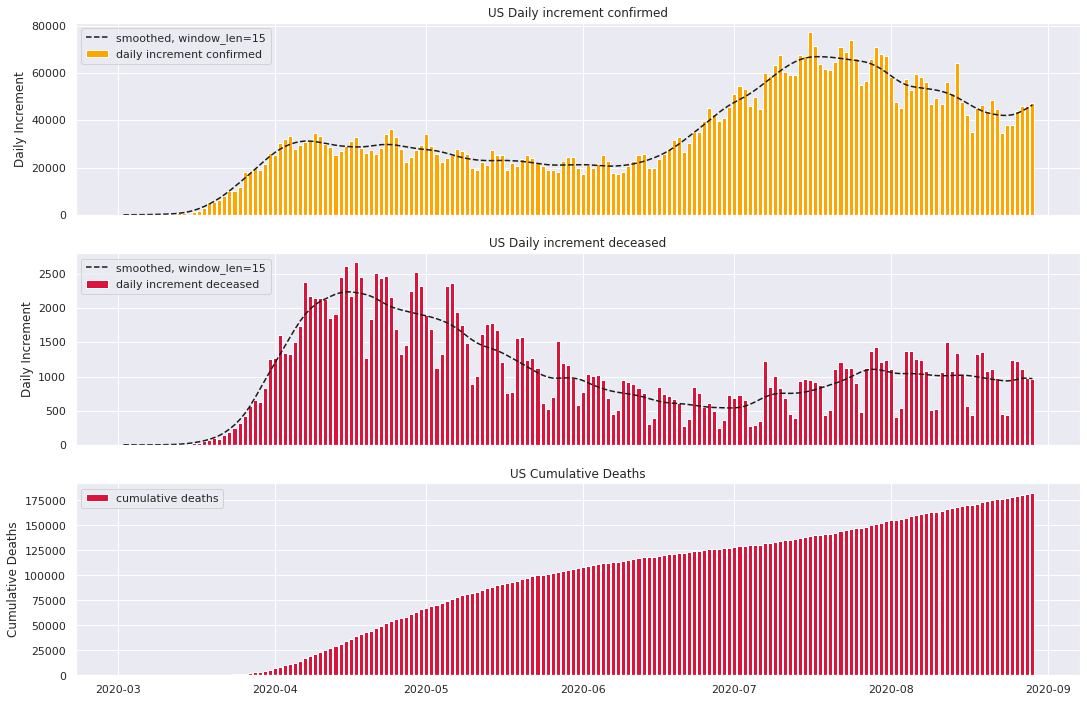

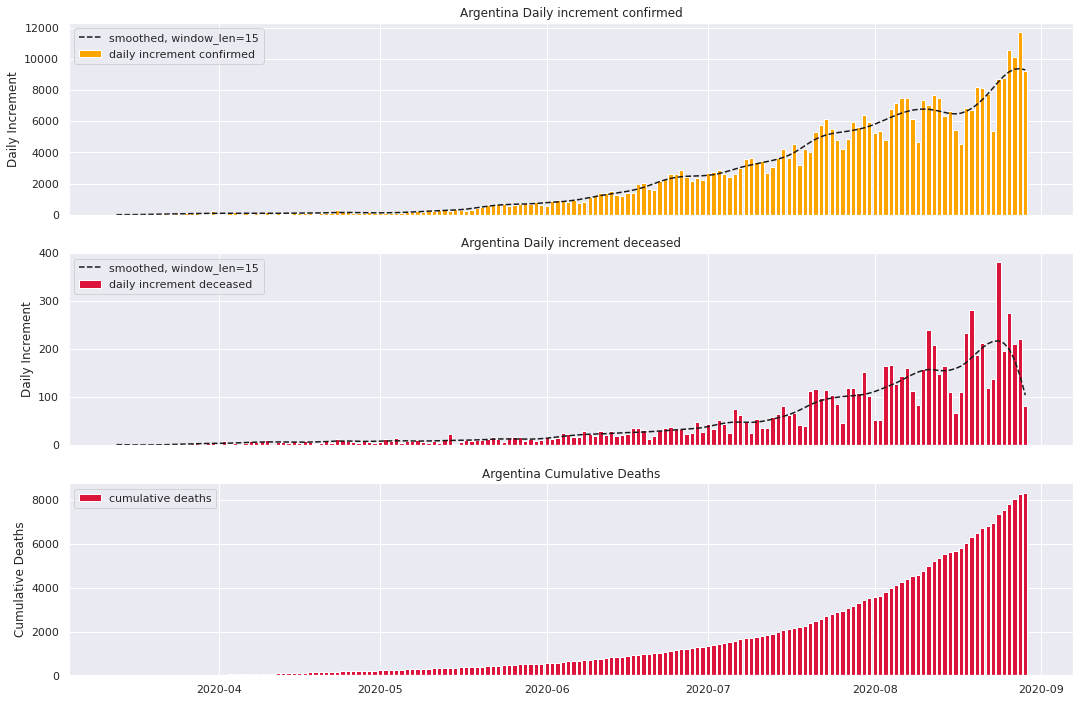

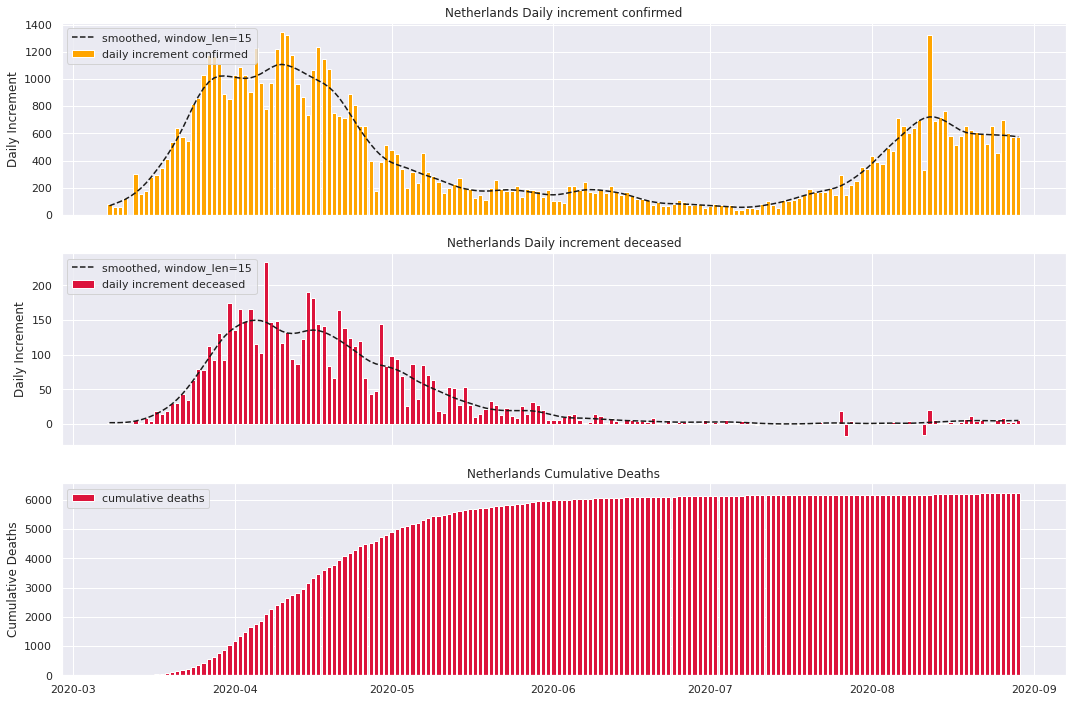

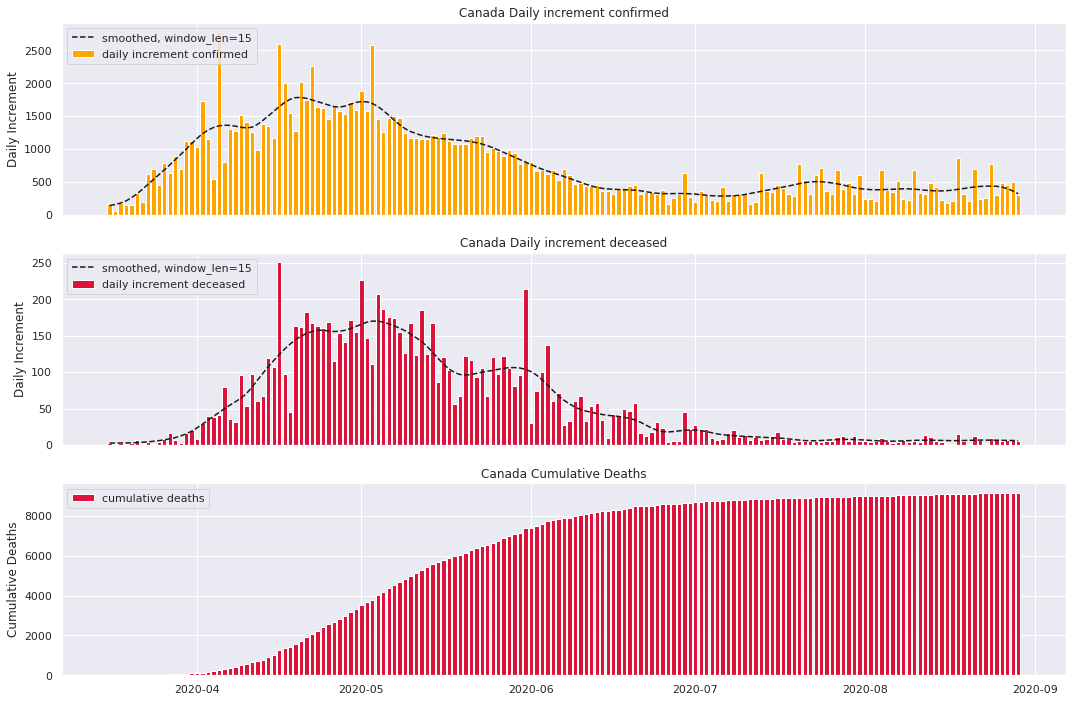

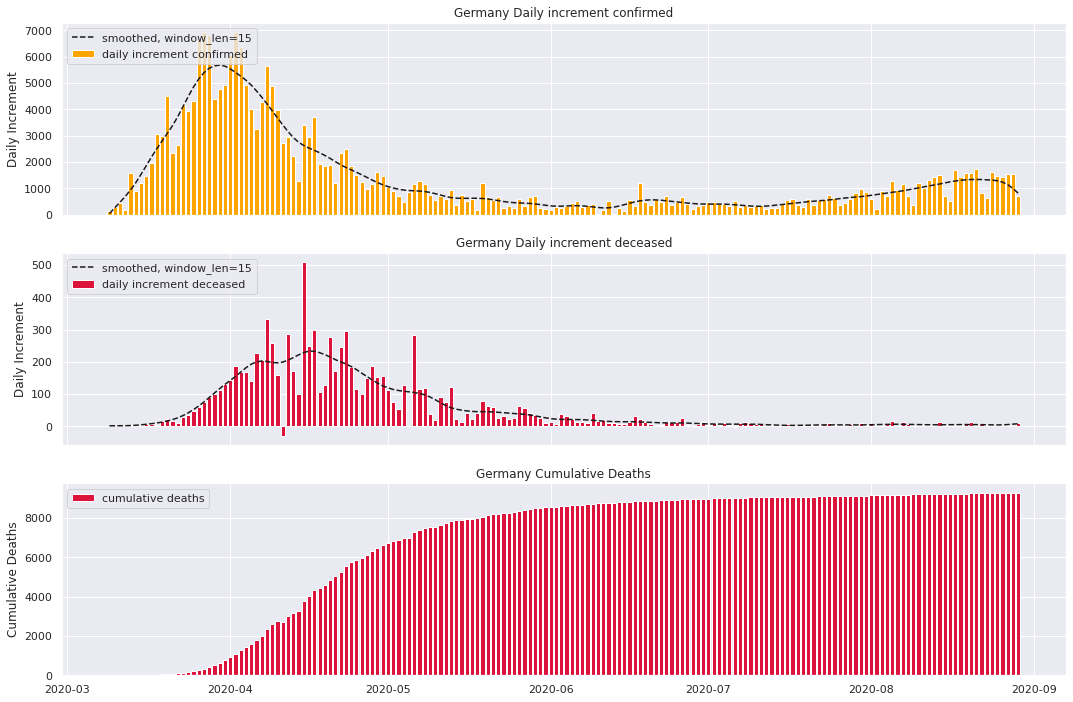

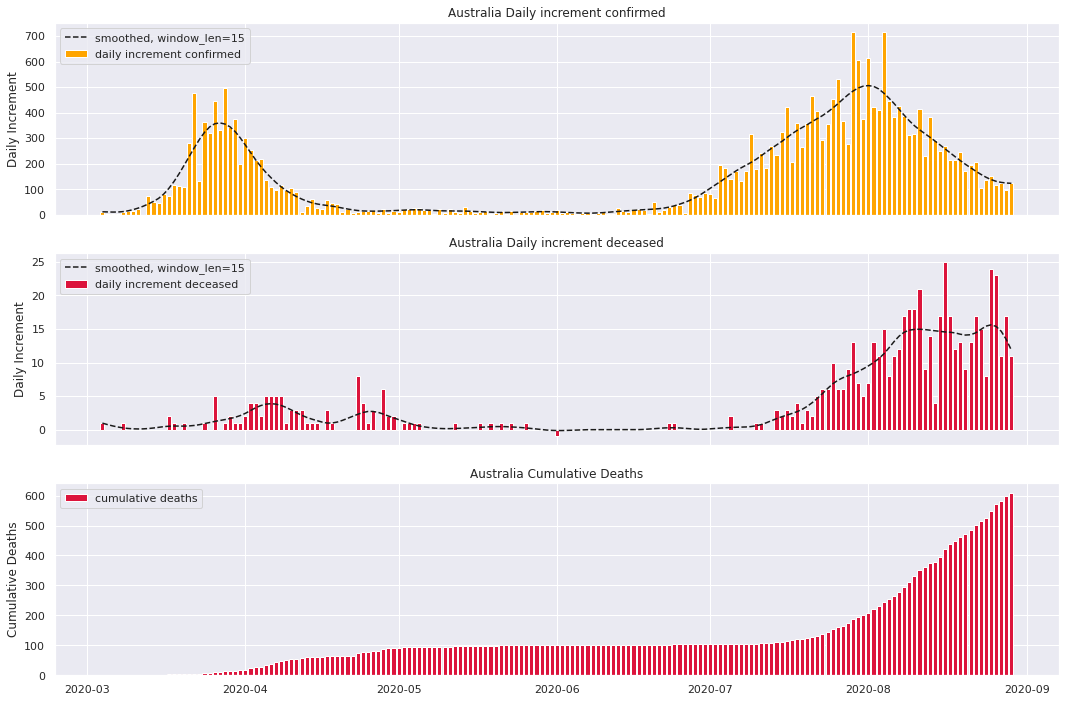

In [6]:


# countries = ['United Kingdom','Australia','Russia','Brazil']

for c in countries:
    print (c)
    window_len = 15
    fig,axes = plt.subplots(3,1,sharex=True,figsize=(18,12))
    df = dick[c]
    df = df[df['deceased'] > 1]
    df.index = df.index.date
    print (df.tail())
    axes[0].set_title('{} Daily increment confirmed'.format(c))
    axes[1].set_title('{} Daily increment deceased'.format(c))
    axes[0].plot(df.index,smooth(df['inc'],window_len=window_len),
                 color='k',ls='dashed',label='smoothed, window_len={}'.format(window_len))
    axes[1].plot(df.index,smooth(df['dead_inc'],window_len=window_len),color='k',
                 ls='dashed',label='smoothed, window_len={}'.format(window_len))
    axes[0].bar(df.index,df['inc'],color='orange',label='daily increment confirmed')
    axes[1].bar(df.index,df['dead_inc'],color='crimson',label='daily increment deceased')
    axes[0].legend(loc='upper left')
    axes[1].legend(loc='upper left')
    axes[0].set_ylabel('Daily Increment')
    axes[1].set_ylabel('Daily Increment')
    
    axes[2].set_title('{} Cumulative Deaths'.format(c))
    axes[2].bar(df.index,df['dead_inc'].cumsum(),color='crimson',label='cumulative deaths')
    axes[2].set_ylabel('Cumulative Deaths')
    axes[2].legend(loc='upper left')
    
    plt.savefig('daily_incs_{}.jpg'.format(c))

<ipython-input-7-8b4ac00736f2>:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  today = pd.datetime.today().weekday()


++++++++++++++++ New Zealand
              inc  dead_inc
2020-04-04  499.0       1.0
2020-04-11  362.0       3.0
2020-04-18  110.0       7.0
2020-04-25   48.0       7.0
2020-05-02   17.0       2.0
2020-05-09    7.0       1.0
2020-05-16    5.0       0.0
2020-05-23    5.0       0.0
2020-05-30    0.0       1.0
2020-06-06    0.0       0.0
2020-06-13    0.0       0.0
2020-06-20    7.0       0.0
2020-06-27   15.0       0.0
2020-07-04    7.0       0.0
2020-07-11   11.0       0.0
2020-07-18    9.0       0.0
2020-07-25    3.0       0.0
2020-08-01    9.0       0.0
2020-08-08    4.0       0.0
2020-08-15   53.0       0.0
2020-08-22   52.0       0.0
2020-08-29   55.0       0.0
++++++++++++++++ South Africa
                inc  dead_inc
2020-03-28    260.0       1.0
2020-04-04    398.0       8.0
2020-04-11    443.0      16.0
2020-04-18   1006.0      27.0
2020-04-25   1327.0      34.0
2020-05-02   1975.0      37.0
2020-05-09   3084.0      63.0
2020-05-16   4935.0      75.0
2020-05-23   6988.0     146

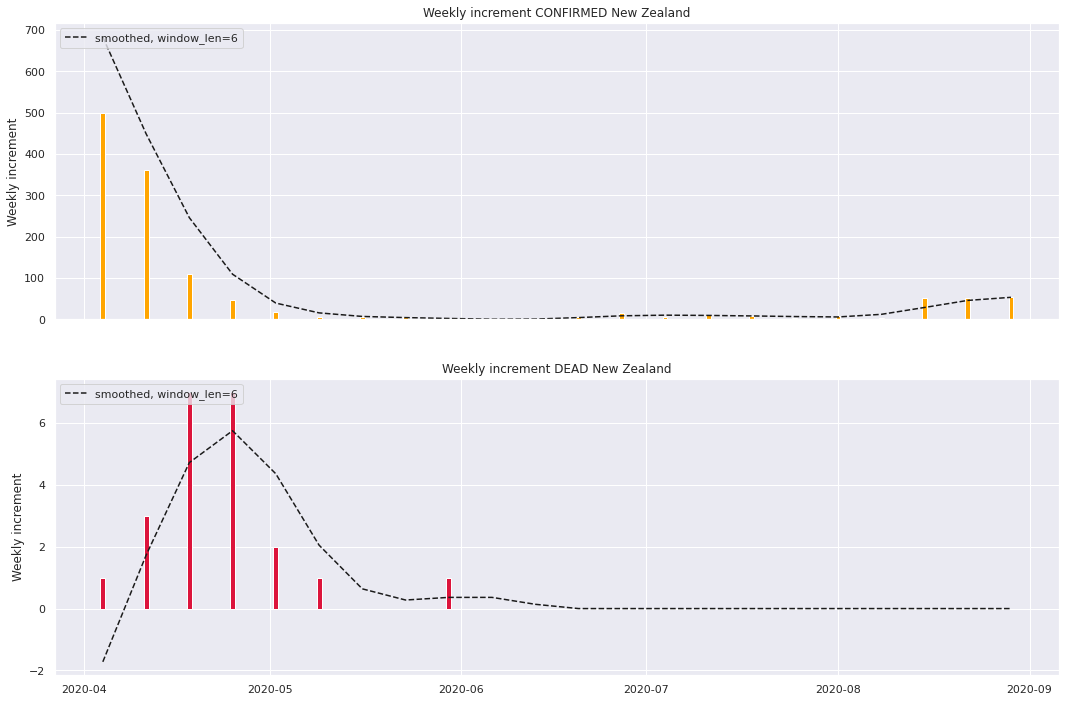

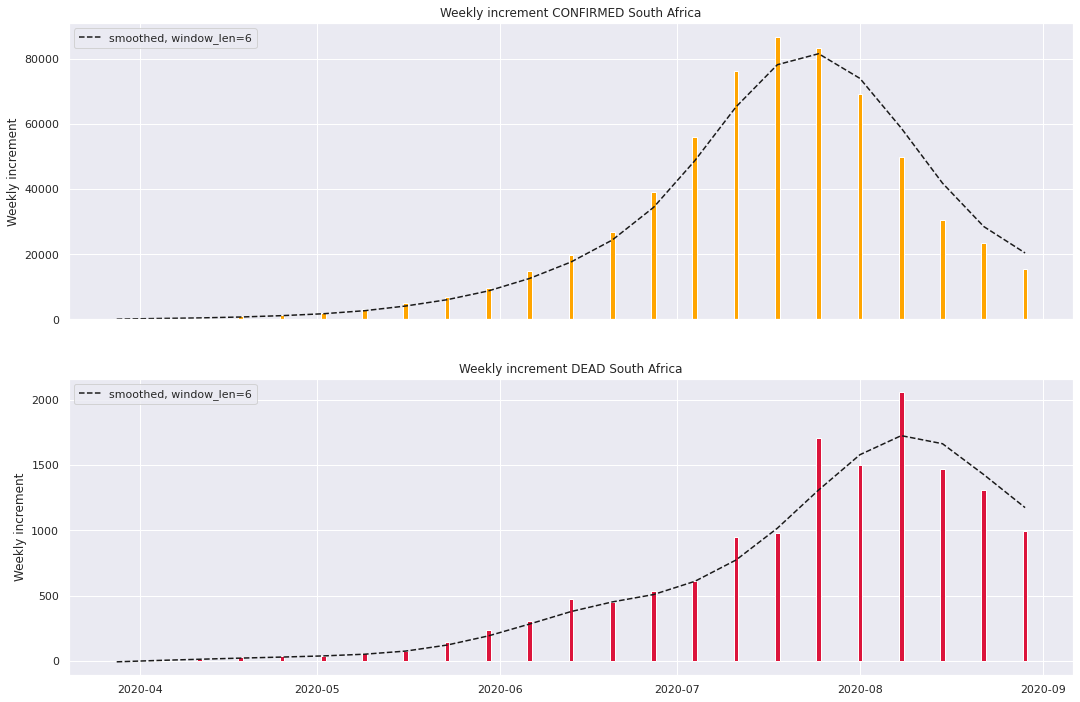

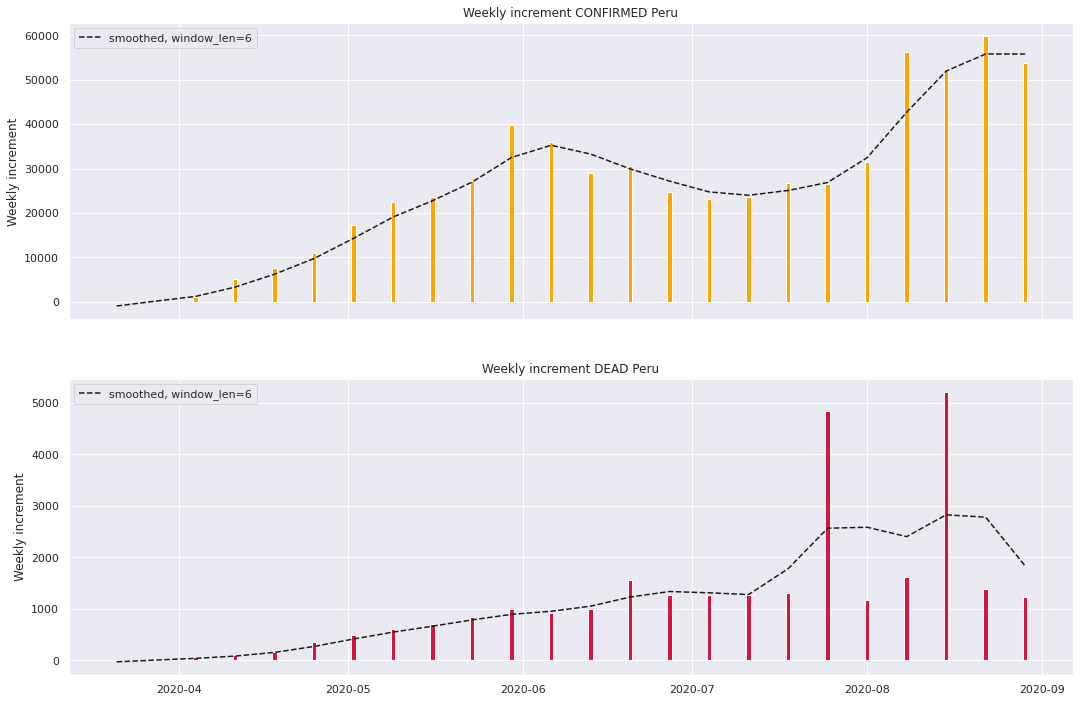

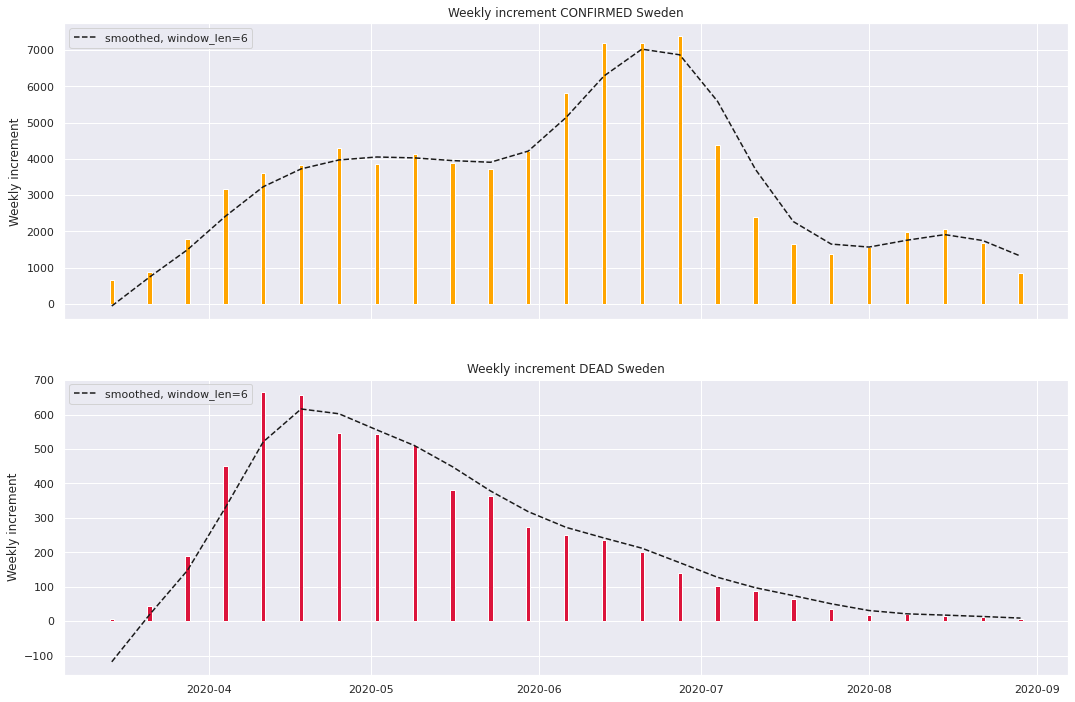

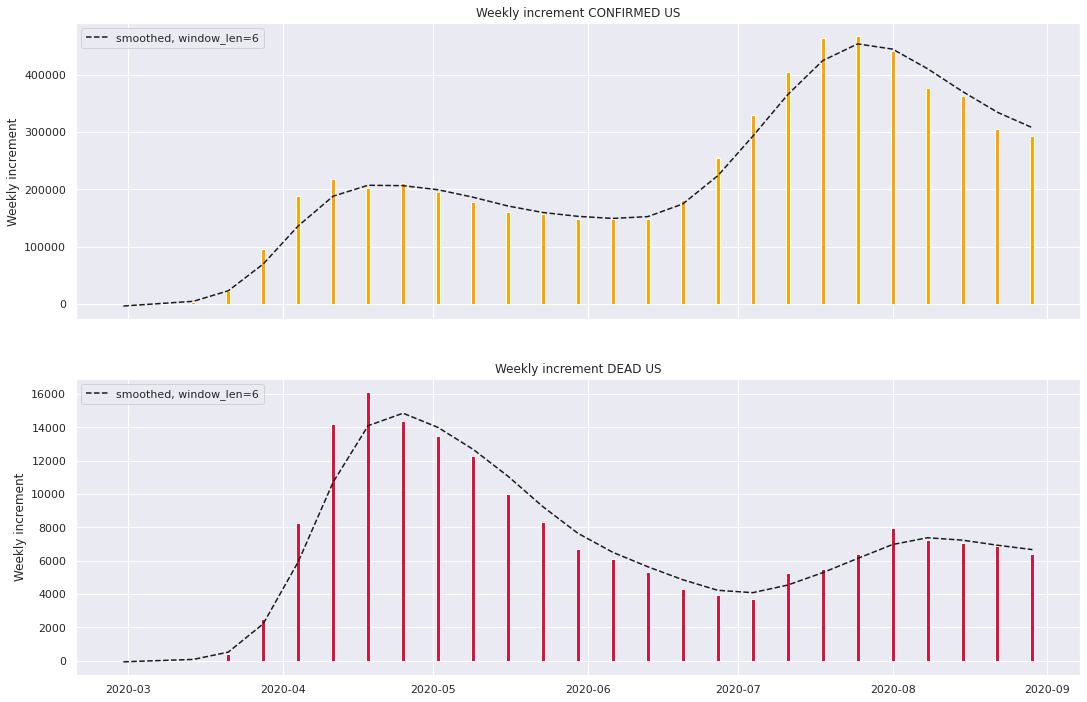

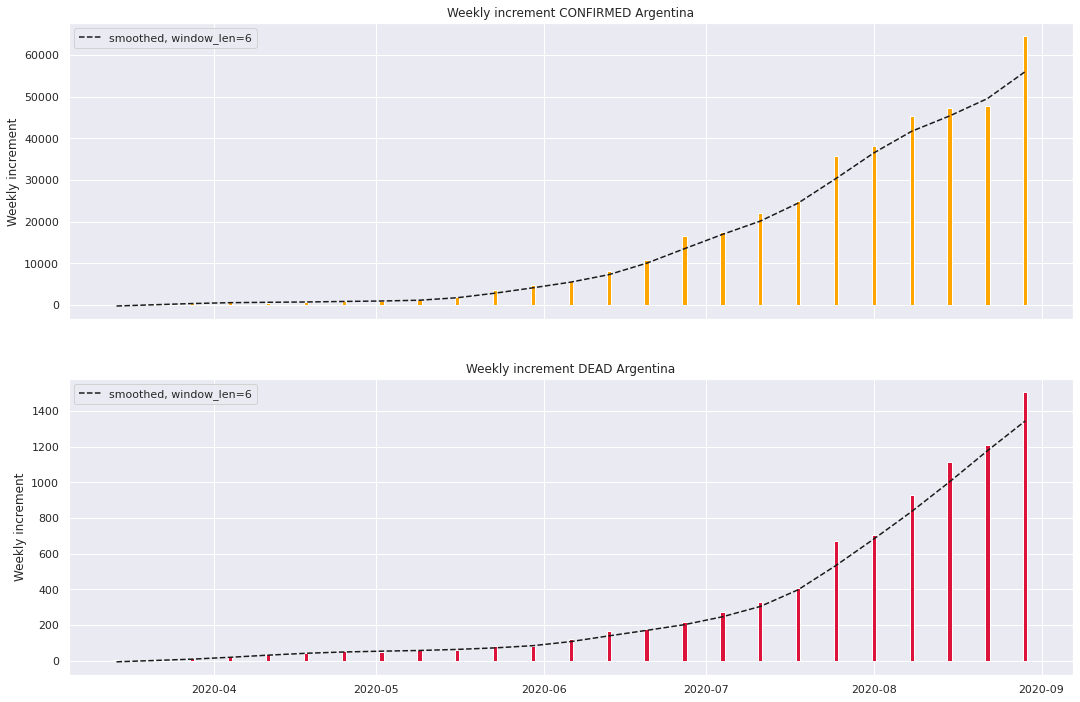

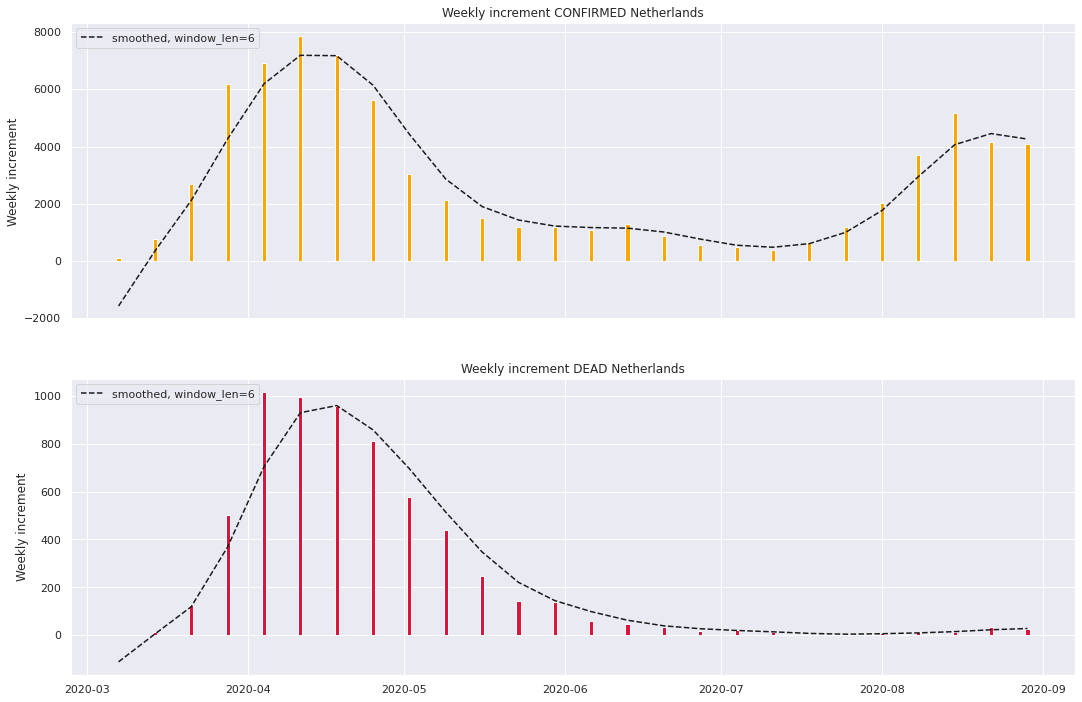

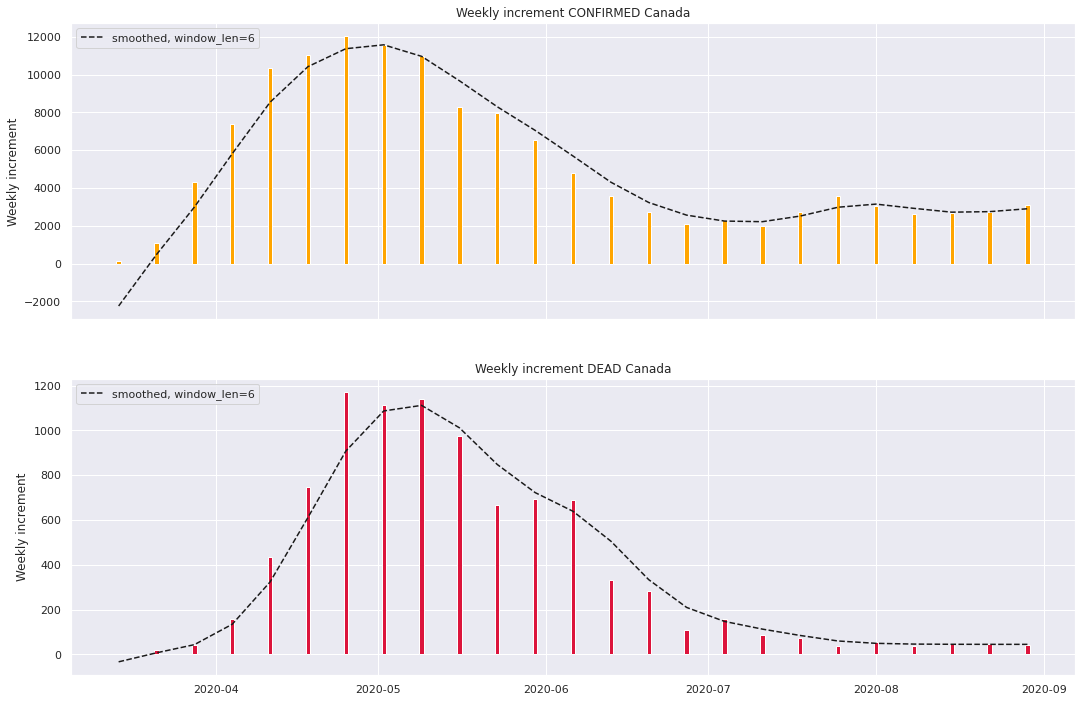

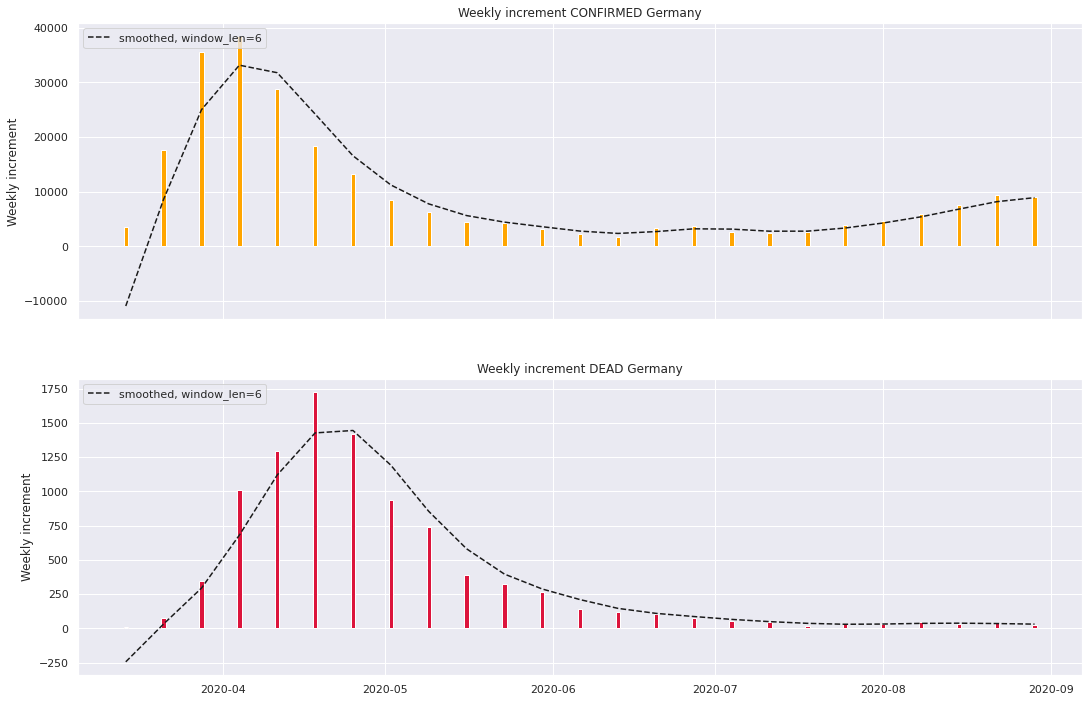

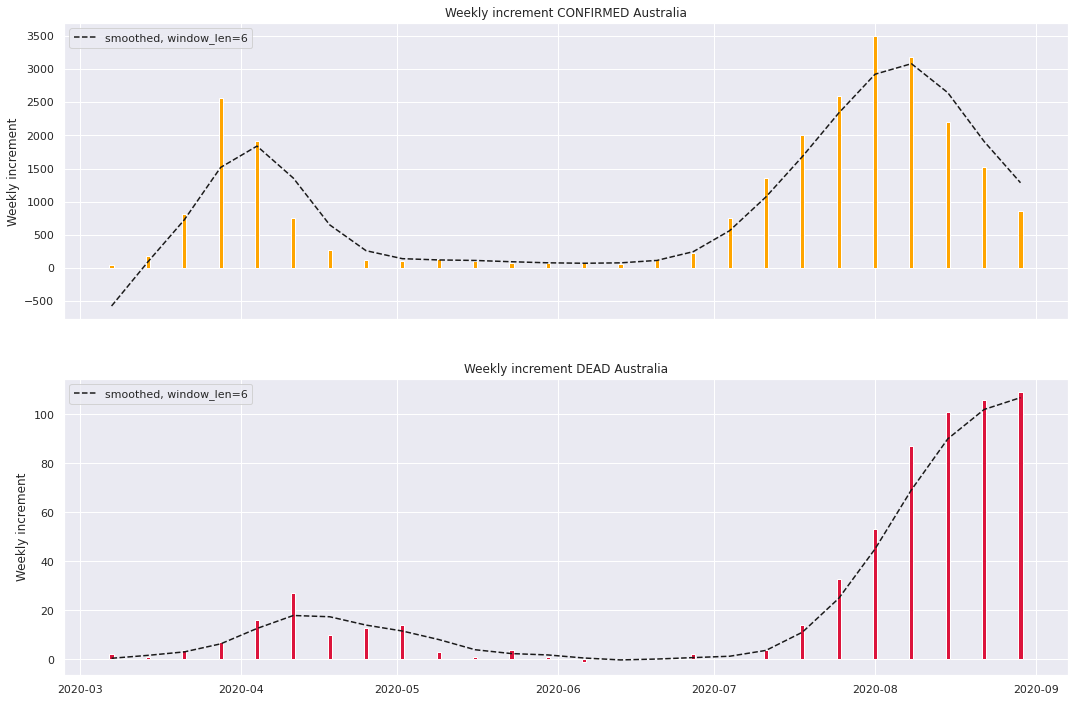

In [7]:
import pickle

resample_period = ['W-MON','W-TUE','W-WED','W-THU','W-FRI','W-SAT','W-SUN']
today = pd.datetime.today().weekday()

yesterday = lambda i : resample_period[i % 7 -1] if i != 0 else resample_period[6]

window_len = 6

week_dick=dict()

for c in countries:
    fig,axes=plt.subplots(2,1,figsize=(18,12),sharex=True)
    
    df = dick[c]
    df = df[df['deceased'] > 0]
    df_weekly = df.resample(yesterday(today)).agg({'inc' : np.sum,'dead_inc':np.sum})

    week_dick[c] = df_weekly
    
    print ('++++++++++++++++ {}'.format(c))
    print (df_weekly)
    axes[0].set_title('Weekly increment CONFIRMED {}'.format(c))
    axes[1].set_title('Weekly increment DEAD {}'.format(c))
    axes[0].set_ylabel('Weekly increment')
    axes[1].set_ylabel('Weekly increment')
    axes[0].bar(df_weekly.index,df_weekly['inc'],color='orange')
    axes[1].bar(df_weekly.index,df_weekly['dead_inc'],color='crimson')
    
    axes[0].plot(df_weekly.index,smooth(df_weekly['inc'],window_len=window_len),
                 color='k',ls='dashed',label='smoothed, window_len={}'.format(window_len))
    
    axes[1].plot(df_weekly.index,smooth(df_weekly['dead_inc'],window_len=window_len),
                 color='k',ls='dashed',label='smoothed, window_len={}'.format(window_len))

    axes[0].legend(loc='upper left')
    axes[1].legend(loc='upper left')
    
    plt.savefig('weekly_increments_{}.jpg'.format(c))

with open ('weekly_dick.pkl','wb') as f:
    pickle.dump(week_dick,f)

In [8]:
df_weekly


inc  dead_inc
2020-03-07    38.0       2.0
2020-03-14   187.0       1.0
2020-03-21   821.0       4.0
2020-03-28  2569.0       7.0
2020-04-04  1910.0      16.0
2020-04-11   753.0      27.0
2020-04-18   265.0      10.0
2020-04-25   126.0      13.0
2020-05-02   105.0      14.0
2020-05-09   140.0       3.0
2020-05-16   105.0       1.0
2020-05-23    70.0       4.0
2020-05-30    78.0       1.0
2020-06-06    67.0      -1.0
2020-06-13    61.0       0.0
2020-06-20   141.0       0.0
2020-06-27   225.0       2.0
2020-07-04   757.0       0.0
2020-07-11  1354.0       4.0
2020-07-18  2005.0      14.0
2020-07-25  2601.0      33.0
2020-08-01  3492.0      53.0
2020-08-08  3189.0      87.0
2020-08-15  2203.0     101.0
2020-08-22  1524.0     106.0
2020-08-29   859.0     109.0

cant find population for Bahamas, skippin..
cant find population for Burma, skippin..
cant find population for Congo (Brazzaville), skippin..
cant find population for Congo (Kinshasa), skippin..
cant find population for Cote d'Ivoire, skippin..
cant find population for Diamond Princess, skippin..
cant find population for Kosovo, skippin..
cant find population for MS Zaandam, skippin..
cant find population for Saint Kitts and Nevis, skippin..
cant find population for Saint Vincent and the Grenadines, skippin..
cant find population for Sao Tome and Principe, skippin..
cant find population for Taiwan*, skippin..
cant find population for West Bank and Gaza, skippin..


Text(450.6285714285715, 0.5, 'dead_M')

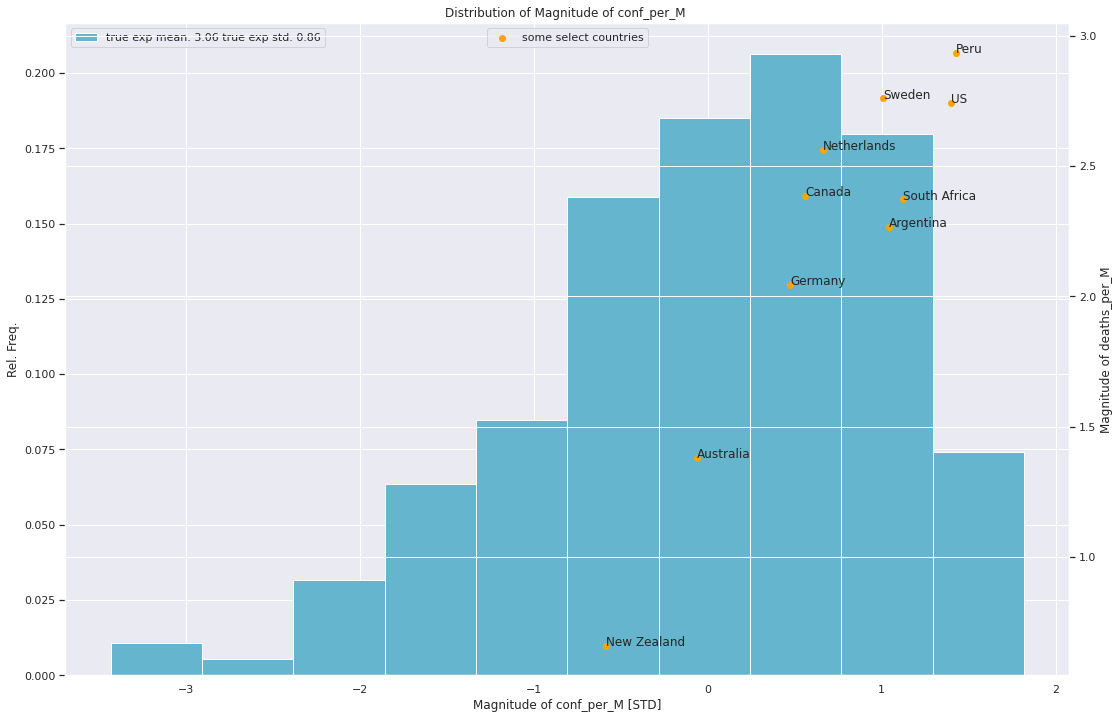

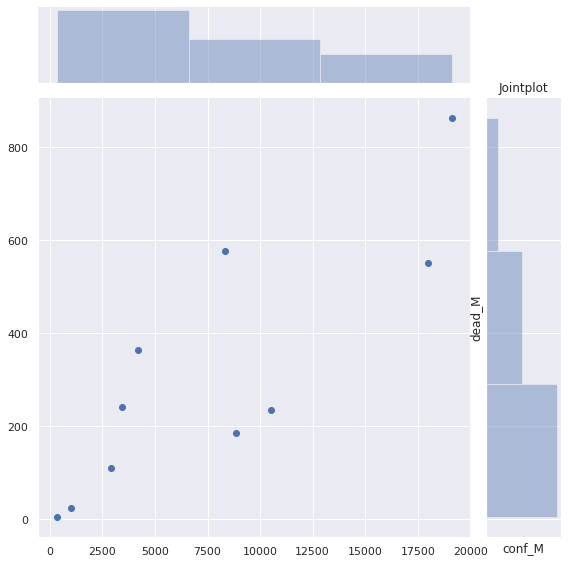

In [9]:
stats_df = pd.DataFrame()

param = 'conf_per_M'

for country,data in dick.items():
    try:
        population = country_populations.loc[country,'population']
    except:
        print ('cant find population for {}, skippin..'.format(country))
    data['conf_per_M'] = data['confirmed'] / (population / 1e6)
    data['dead_per_M'] = data['deceased'] / (population / 1e6)
    data['factor_per_M'] = data['conf_per_M'] / data['conf_per_M'].shift()
    data['factor_dead_per_M'] = data['dead_per_M'] / data['dead_per_M'].shift()
    data = pd.DataFrame(data[param])
    data = data.iloc[-1]
    
    stats_df = pd.concat([stats_df,data])


magnitude = np.log10(stats_df[0])

def std(x,mean,std):
    return (x -  mean) / std

magnitude_std = std(magnitude,magnitude.mean(),magnitude.std())

plt.figure(figsize=(18,12))

ax = plt.gca()
ax2 = plt.twinx()

ax.set_title('Distribution of Magnitude of {} '.format(param))
ax.set_ylabel('Rel. Freq.')
ax.set_xlabel('Magnitude of ' + param + ' [STD]')
ax.hist(magnitude_std,weights= np.ones_like(magnitude_std) / len(magnitude_std),color='c',
        label='true exp mean: {:.2f} true exp std: {:.2f}'.format(magnitude.mean(),magnitude.std()))
ax.legend(loc='upper left')  

'''
countries = ['Sweden','US','Germany','Spain','Italy','New York',
            'France','Austria','United Kingdom','Belgium','Finland',
            'Denmark','Norway','Australia','Korea, South',
            'New Zealand','Singapore','Norway','Ethiopia','Japan']
'''
countries = ['New Zealand','South Africa','Peru','Sweden','US',
             'Argentina','Netherlands','Canada','Germany','Australia']


for i,c in enumerate(countries):
    label = 'some select countries' if i == 0 else ''
    
    ax2.scatter(std(np.log10(dick[c].loc[:,'conf_per_M'][-1]),
        magnitude.mean(),magnitude.std()),
                np.log10(dick[c].loc[:,'dead_per_M'][-1]),
                    color='orange',label=label)
    
    ax2.text(std(np.log10(dick[c].loc[:,'conf_per_M'][-1]),
              magnitude.mean(),magnitude.std()),
                 np.log10(dick[c].loc[:,'dead_per_M'][-1]),c)
             
ax2.set_ylabel('Magnitude of deaths_per_M')
ax2.legend(loc='upper center')

conf_m = []
dead_m = []

for i,c in enumerate(countries):
    conf_m.append(dick[c]['conf_per_M'][-1])
    dead_m.append(dick[c]['dead_per_M'][-1])

#plt.title('Joint plot conf_m dead_m')
sns.jointplot(conf_m,dead_m,height=8)
plt.title('Jointplot')
plt.xlabel('conf_M')
plt.ylabel('dead_M')


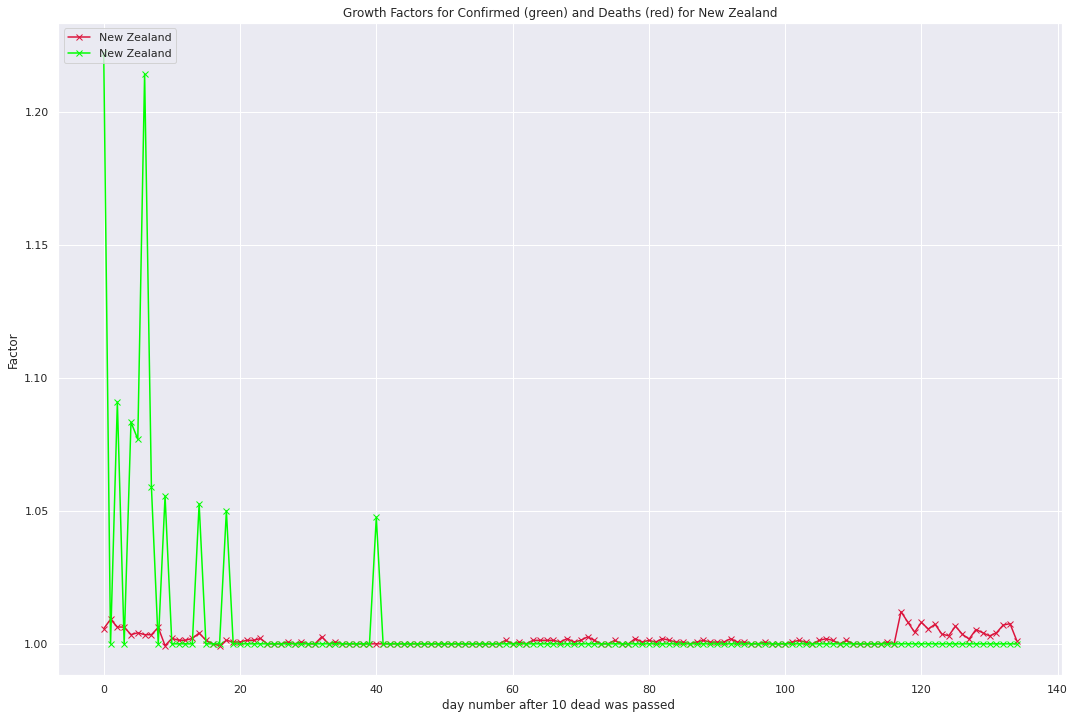

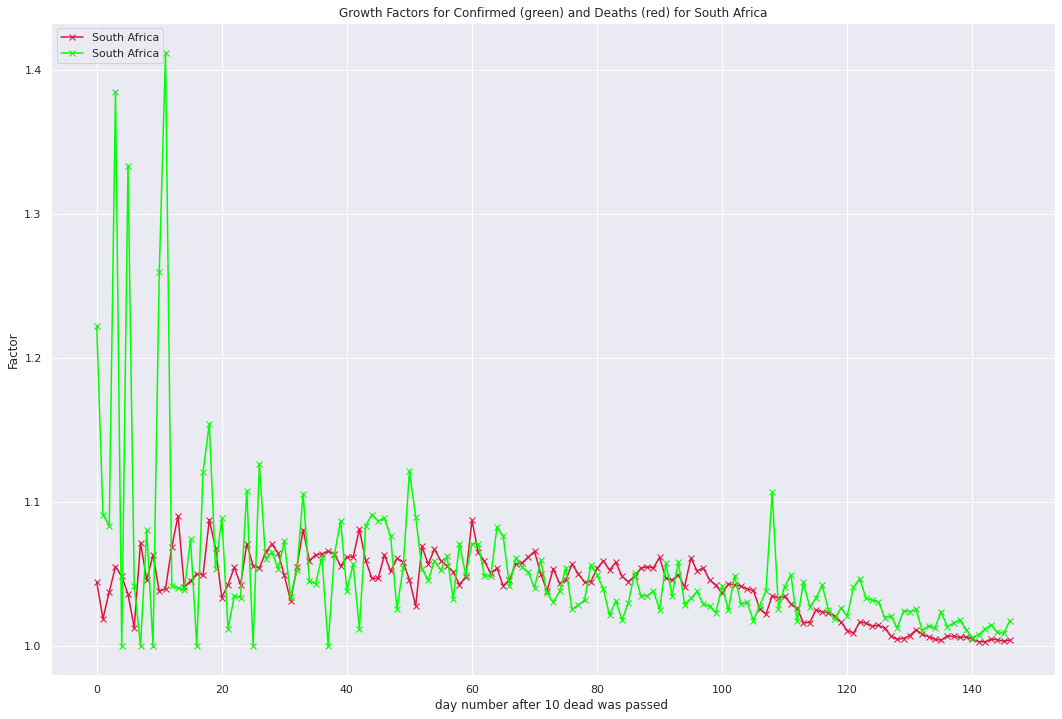

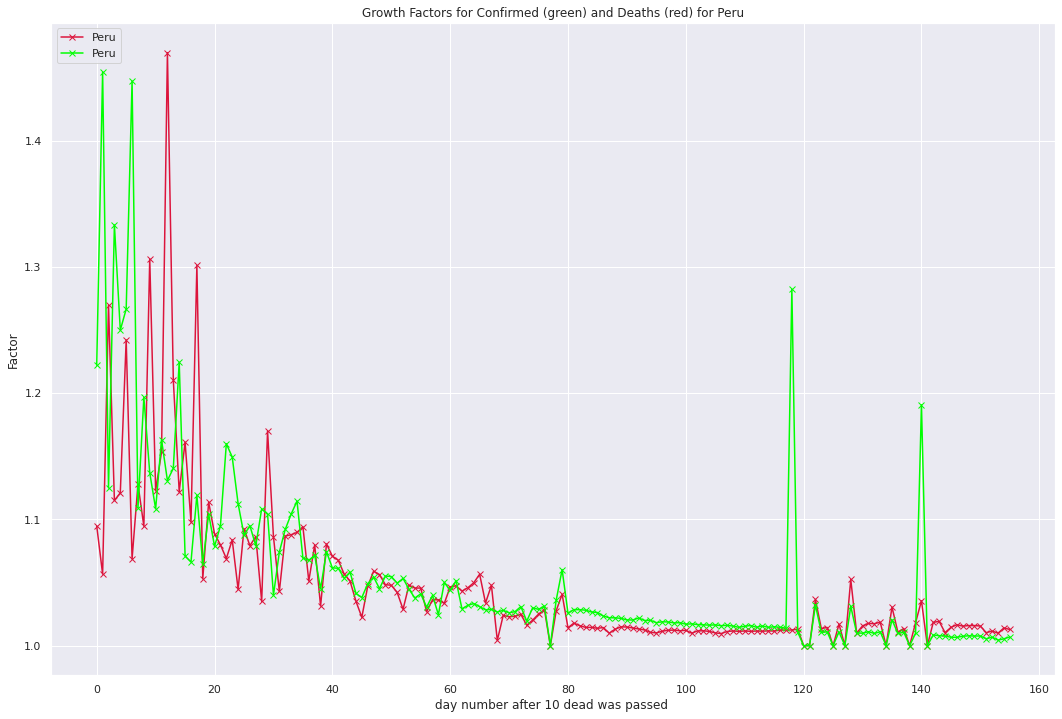

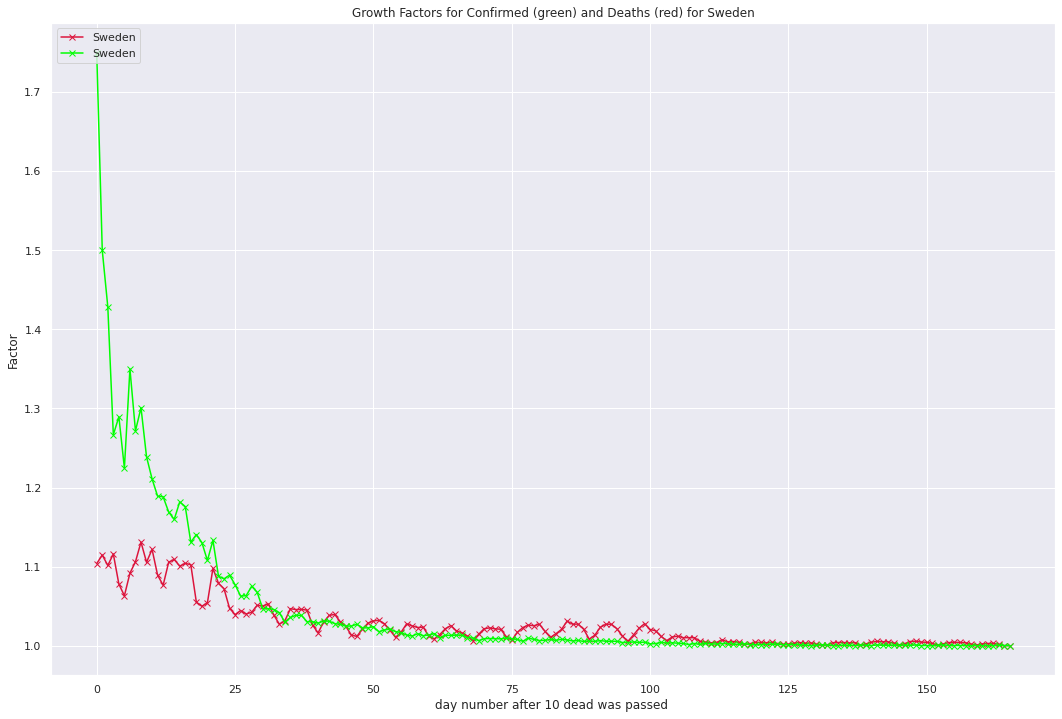

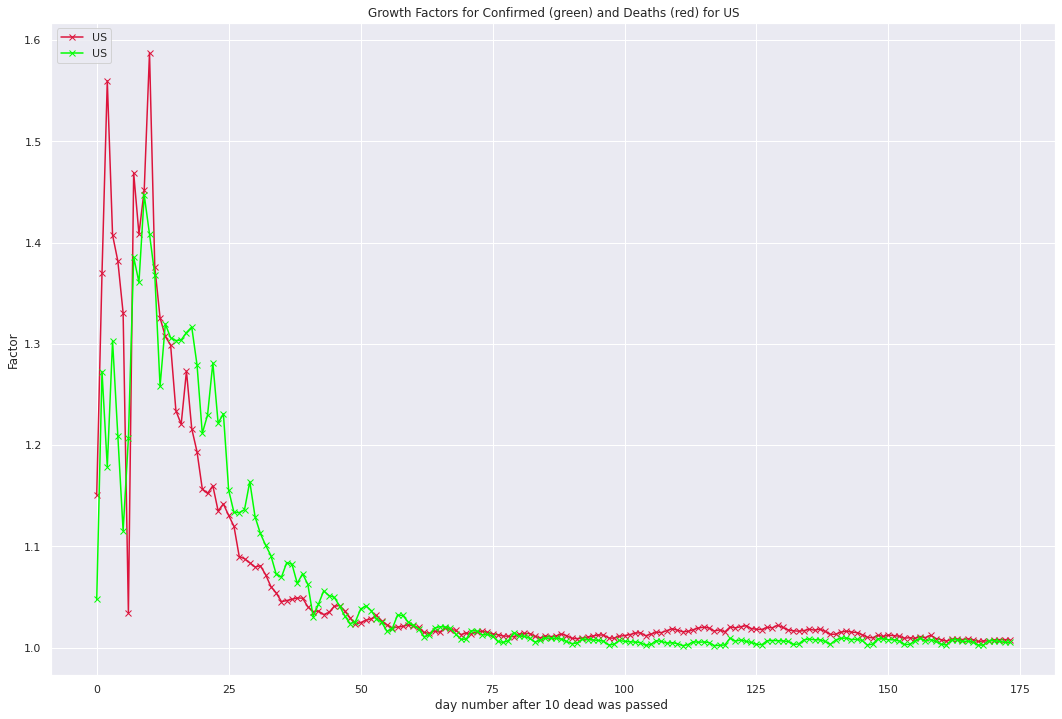

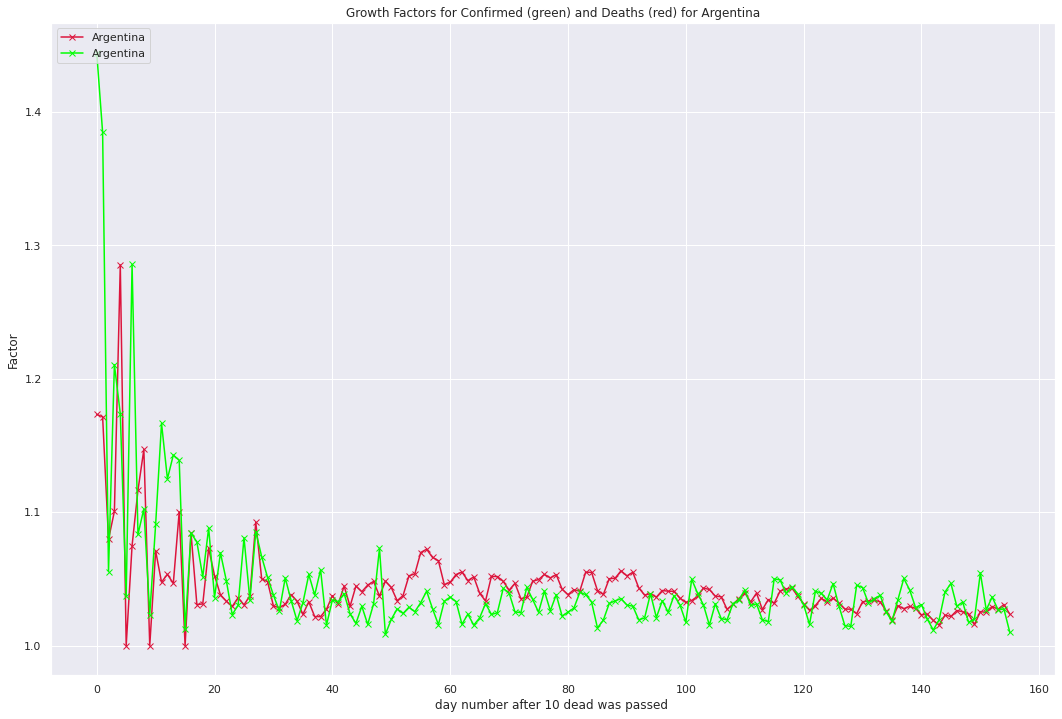

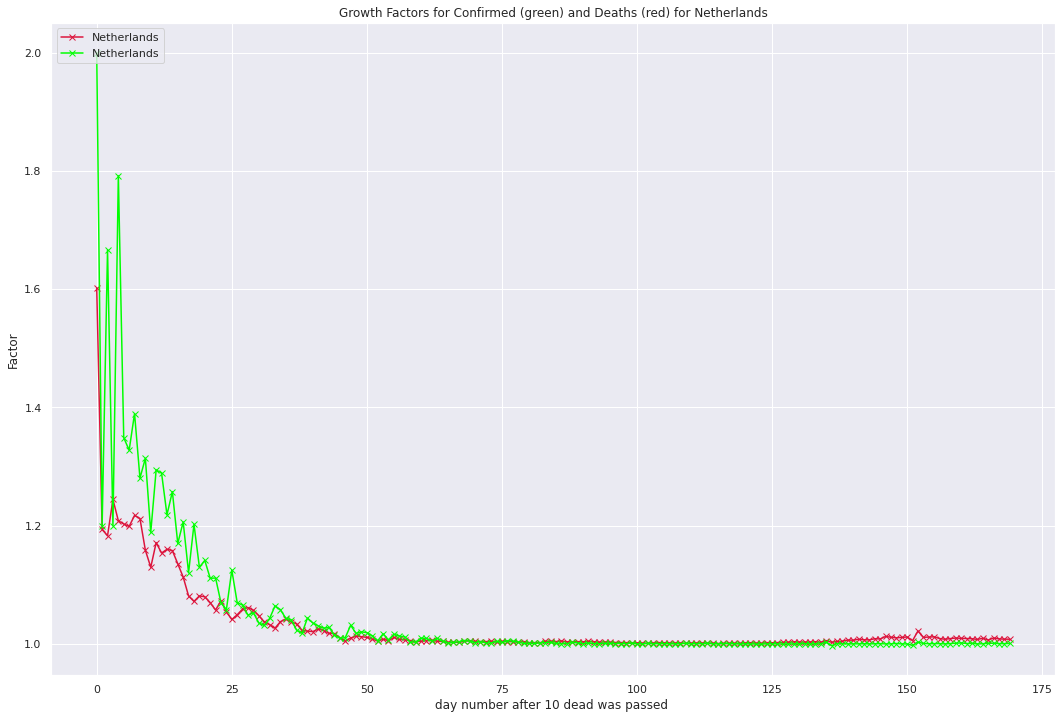

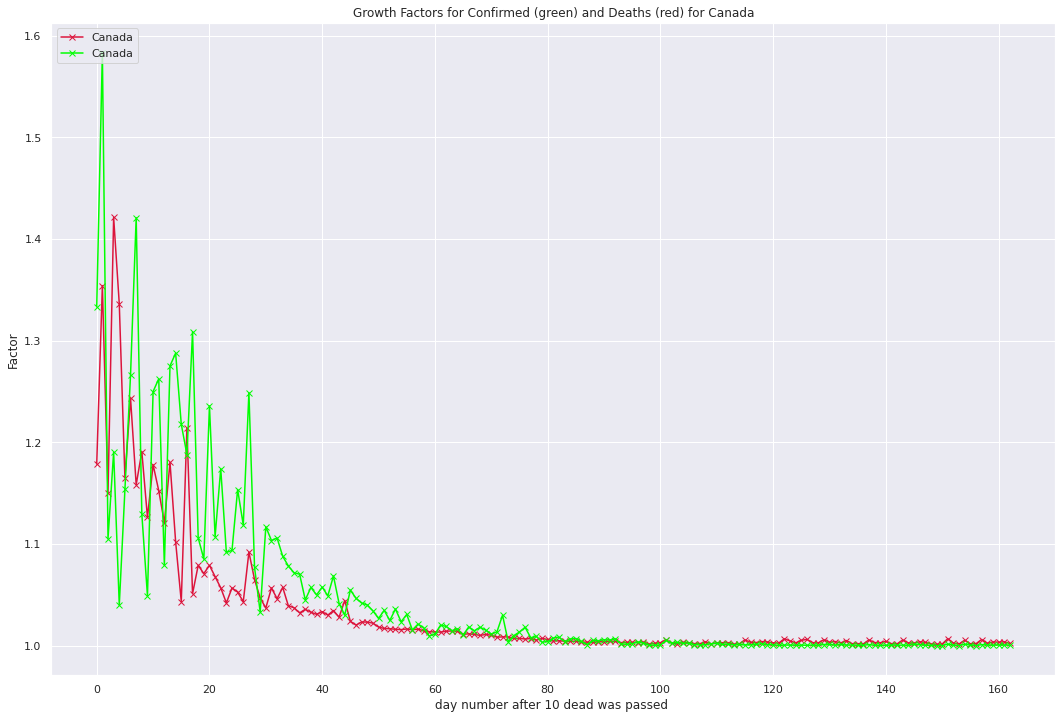

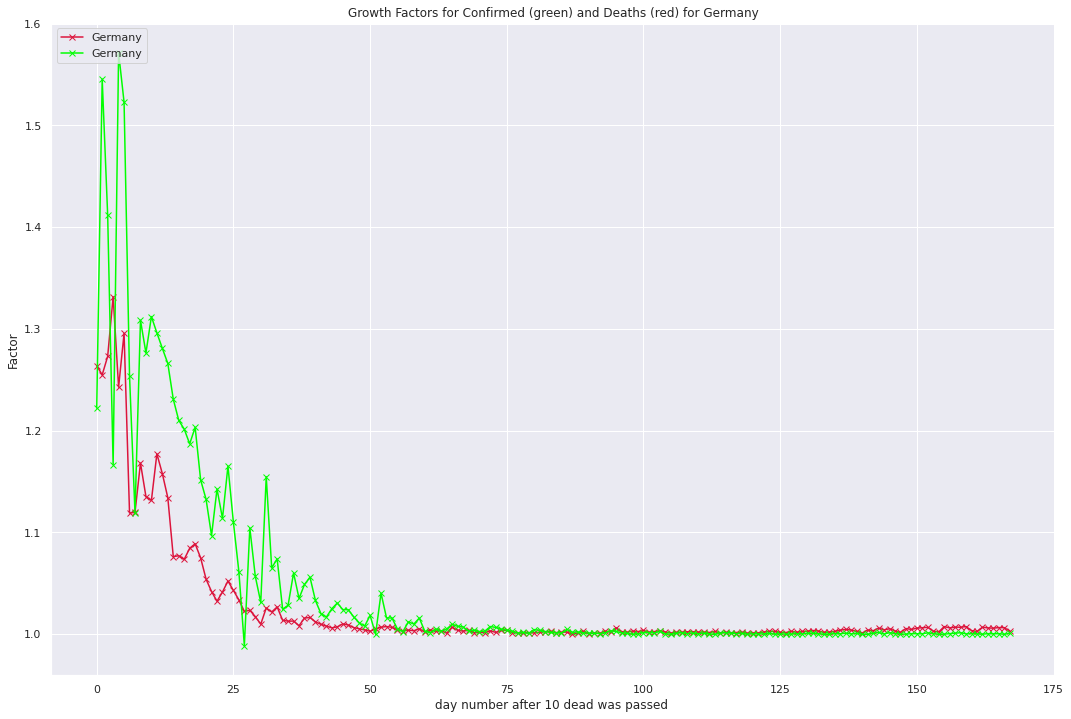

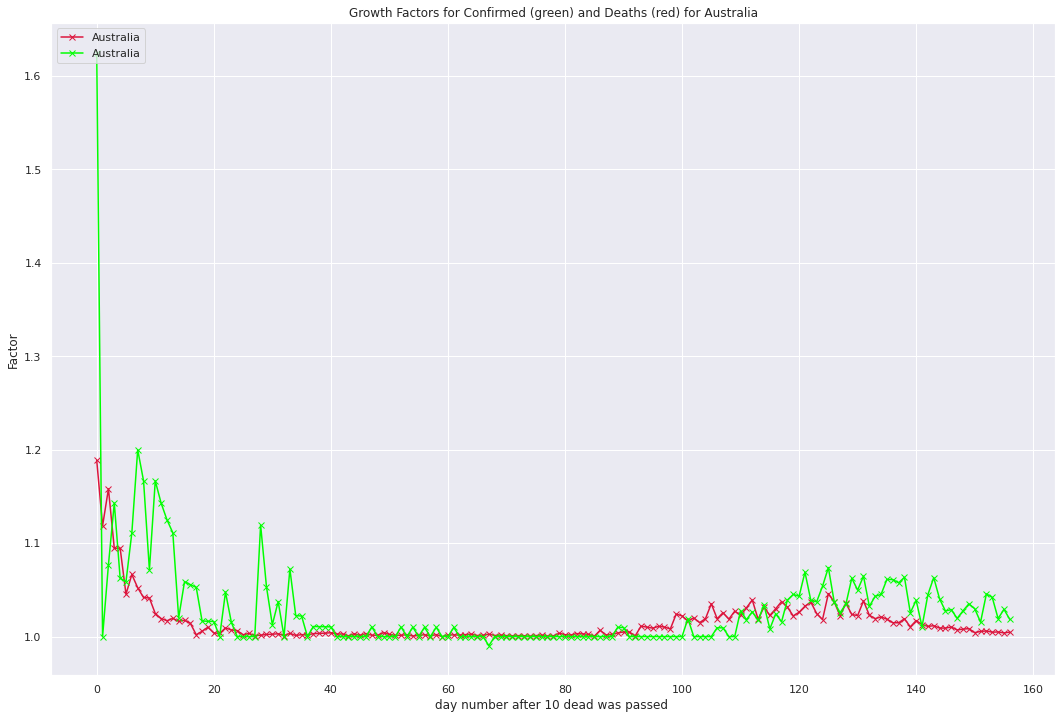

In [10]:
for i,c in enumerate(countries):
    plt.figure(figsize=(18,12))
    plt.title('Growth Factors for Confirmed (green) and Deaths (red) for {}'.format(c))
    
    process_country(c,'factor_per_M',6)
    process_country(c,'factor_dead_per_M',1)
    plt.yscale('linear')
    plt.savefig('Growth_factors_for_{}.jpg'.format(c),format='jpg')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, alpha, beta, alpha_sigma, alpha_mu, beta_sigma, beta_mu]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 4 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.



         beta_post   alpha_post
count  1000.000000  1000.000000
mean      0.226030    -0.002602
std       0.076469     0.077973
min       0.018261    -0.235667
25%       0.173068    -0.055554
50%       0.223406    -0.004338
75%       0.281965     0.049030
max       0.416111     0.245668


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, alpha, beta, alpha_sigma, alpha_mu, beta_sigma, beta_mu]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
There were 50 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6815614164105305, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.



         beta_post   alpha_post
count  1000.000000  1000.000000
mean      0.205514     0.005312
std       0.077462     0.077973
min      -0.165533    -0.243918
25%       0.158447    -0.042047
50%       0.204425     0.003528
75%       0.263119     0.058470
max       0.465705     0.216780


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, alpha, beta, alpha_sigma, alpha_mu, beta_sigma, beta_mu]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 4 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.



         beta_post   alpha_post
count  1000.000000  1000.000000
mean      0.492825    -0.001302
std       0.069367     0.069369
min       0.285292    -0.196606
25%       0.445140    -0.047368
50%       0.492247    -0.000834
75%       0.539349     0.047558
max       0.701927     0.191625


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, alpha, beta, alpha_sigma, alpha_mu, beta_sigma, beta_mu]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.



         beta_post   alpha_post
count  1000.000000  1000.000000
mean      0.811544     0.003890
std       0.046865     0.044575
min       0.660422    -0.121583
25%       0.778176    -0.025413
50%       0.812384     0.005370
75%       0.843310     0.036406
max       0.968799     0.127241


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, alpha, beta, alpha_sigma, alpha_mu, beta_sigma, beta_mu]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.



         beta_post   alpha_post
count  1000.000000  1000.000000
mean      0.889344     0.000406
std       0.033044     0.034200
min       0.803790    -0.108972
25%       0.866452    -0.021082
50%       0.889476     0.000465
75%       0.909923     0.022549
max       0.988466     0.107576


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, alpha, beta, alpha_sigma, alpha_mu, beta_sigma, beta_mu]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
There were 49 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.



         beta_post   alpha_post
count  1000.000000  1000.000000
mean      0.657906     0.000272
std       0.059857     0.059450
min       0.472087    -0.198664
25%       0.610796    -0.037357
50%       0.656181     0.001953
75%       0.702567     0.033553
max       0.834156     0.240966


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, alpha, beta, alpha_sigma, alpha_mu, beta_sigma, beta_mu]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5238102544696147, but should be close to 0.8. Try to increase the number of tuning steps.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.



         beta_post   alpha_post
count  1000.000000  1000.000000
mean      0.912011    -0.000470
std       0.032270     0.027953
min       0.827323    -0.115045
25%       0.879146    -0.014756
50%       0.908084     0.003116
75%       0.935491     0.013186
max       1.035694     0.090991


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, alpha, beta, alpha_sigma, alpha_mu, beta_sigma, beta_mu]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.



         beta_post   alpha_post
count  1000.000000  1000.000000
mean      0.746227     0.000326
std       0.051428     0.051396
min       0.579552    -0.127757
25%       0.709547    -0.032601
50%       0.746577    -0.001514
75%       0.781832     0.036656
max       0.888666     0.157497


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, alpha, beta, alpha_sigma, alpha_mu, beta_sigma, beta_mu]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 178 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5114460050130666, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.



         beta_post   alpha_post
count  1000.000000  1000.000000
mean      0.900848     0.004912
std       0.030073     0.031956
min       0.810614    -0.103453
25%       0.882906    -0.018978
50%       0.907144     0.008341
75%       0.919232     0.033201
max       1.010738     0.119582


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs_sigma, alpha, beta, alpha_sigma, alpha_mu, beta_sigma, beta_mu]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 3 seconds.
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6886091116956063, but should be close to 0.8. Try to increase the number of tuning steps.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.



         beta_post   alpha_post
count  1000.000000  1000.000000
mean      0.665445     0.000942
std       0.060374     0.058061
min       0.492012    -0.207697
25%       0.625631    -0.033018
50%       0.666123     0.003691
75%       0.700280     0.033898
max       0.905038     0.183341


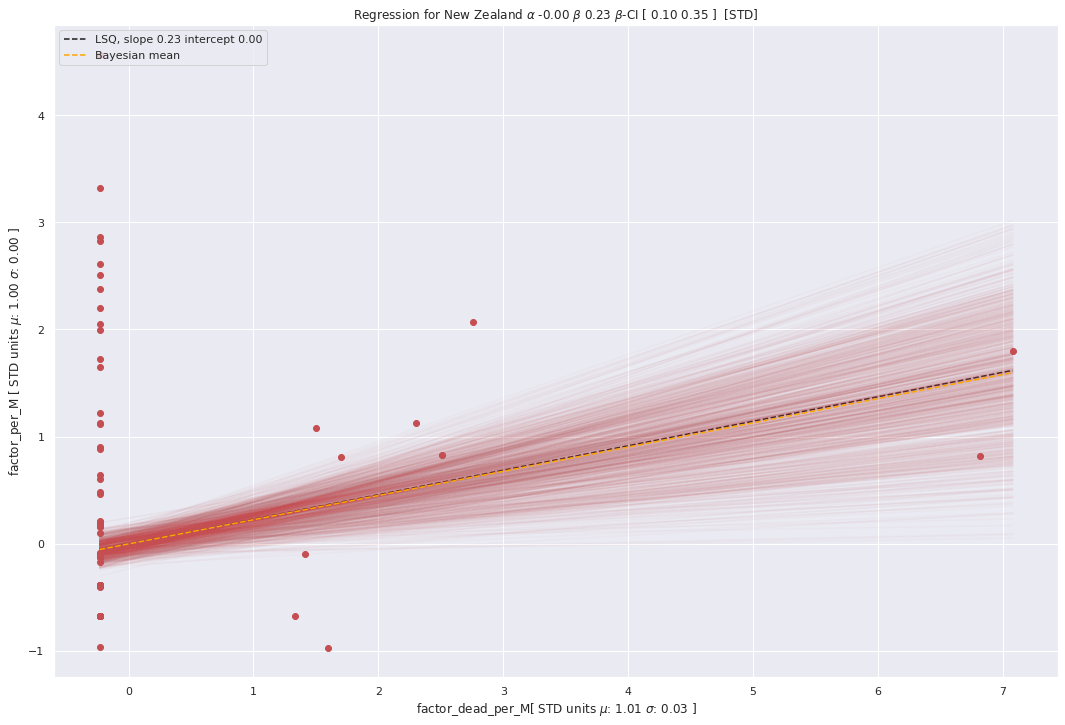

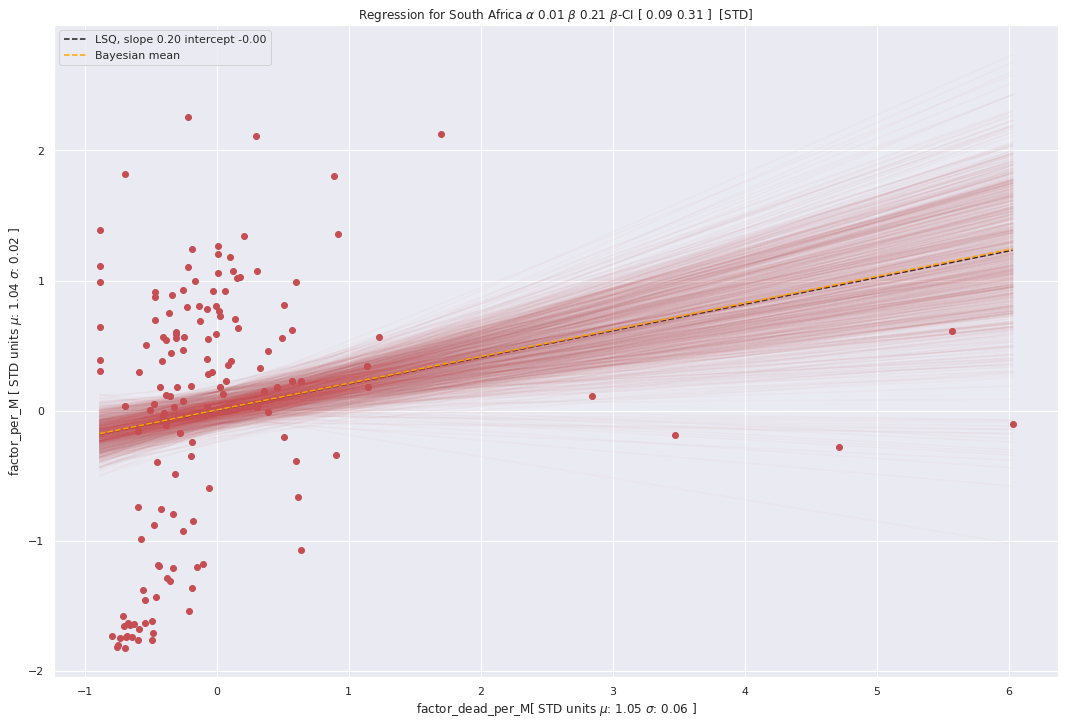

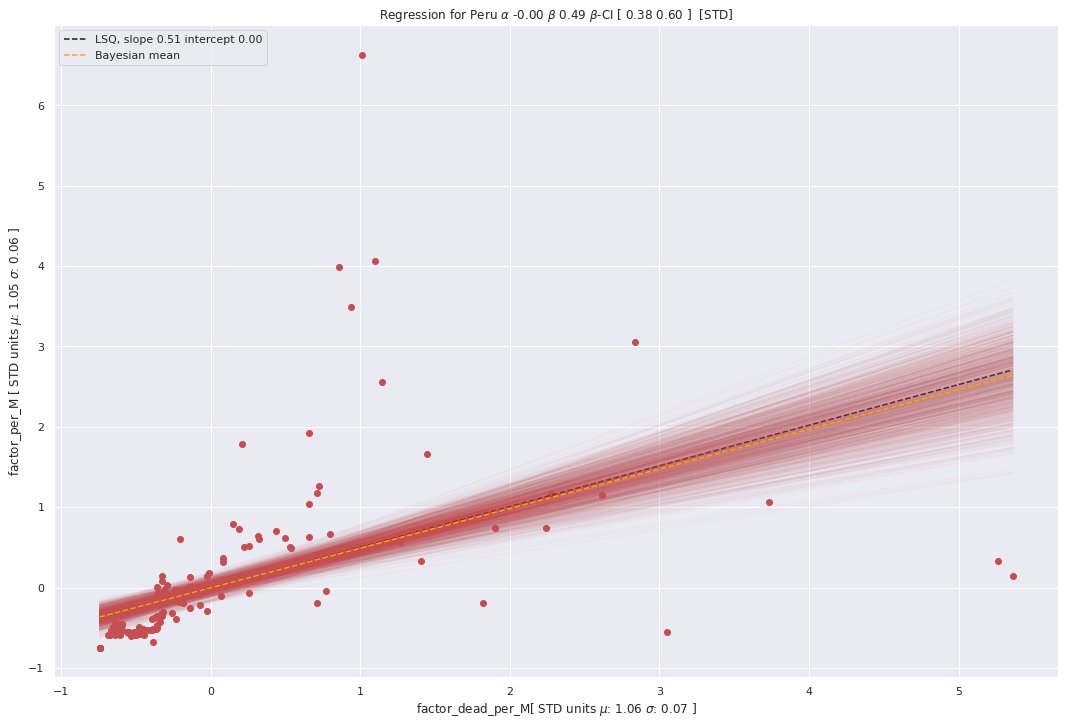

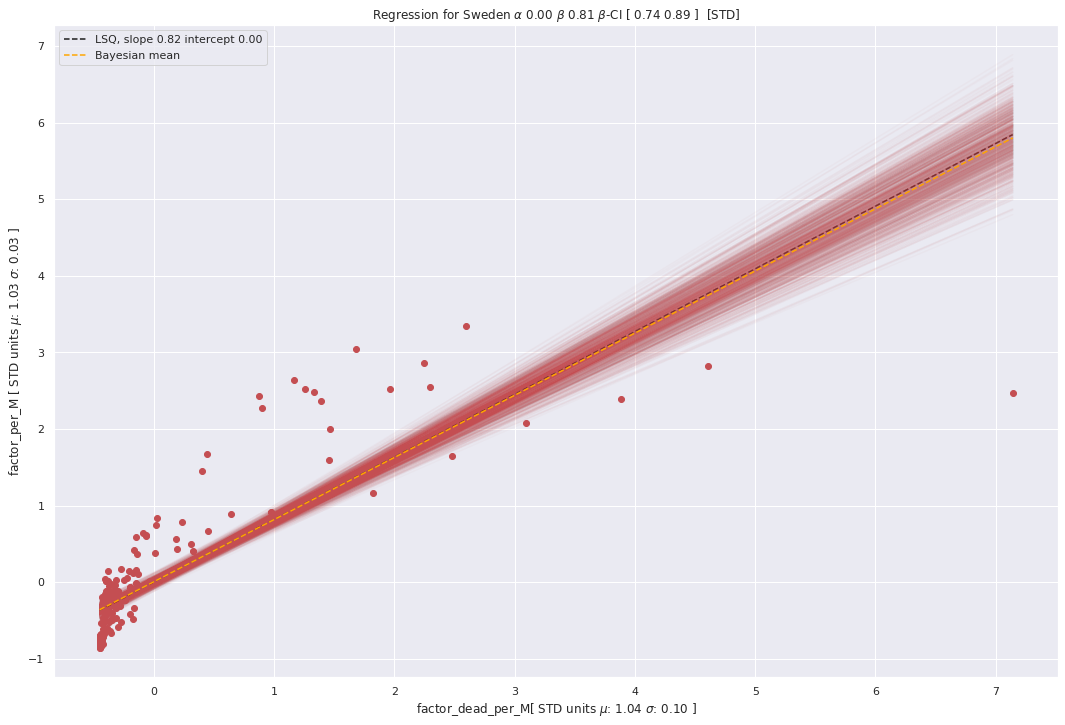

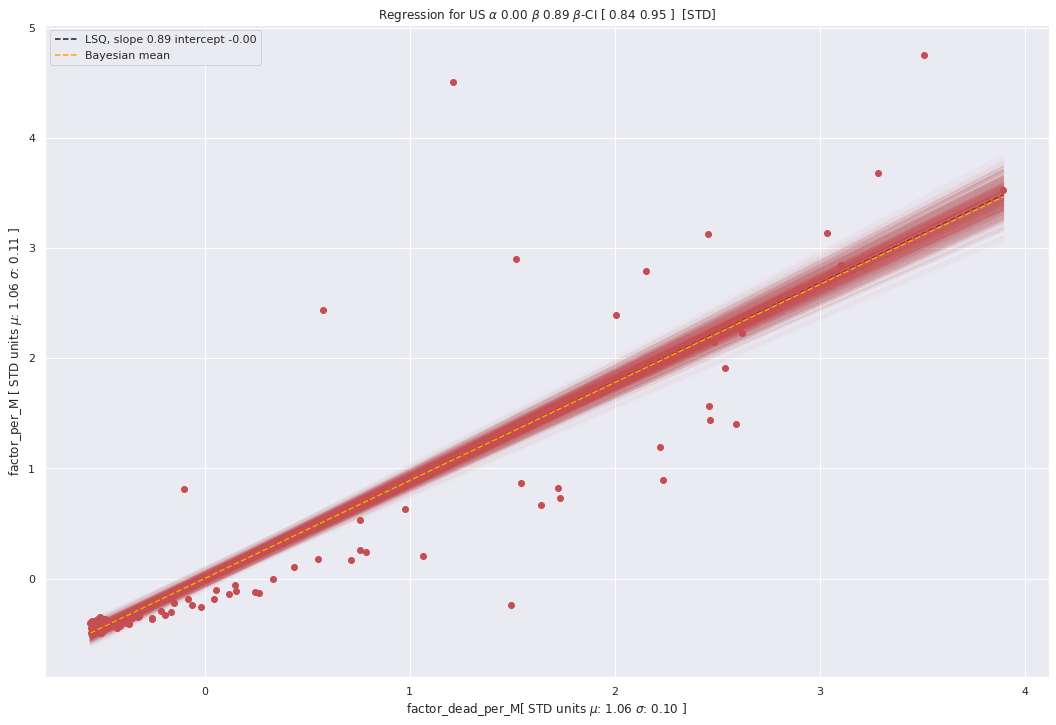

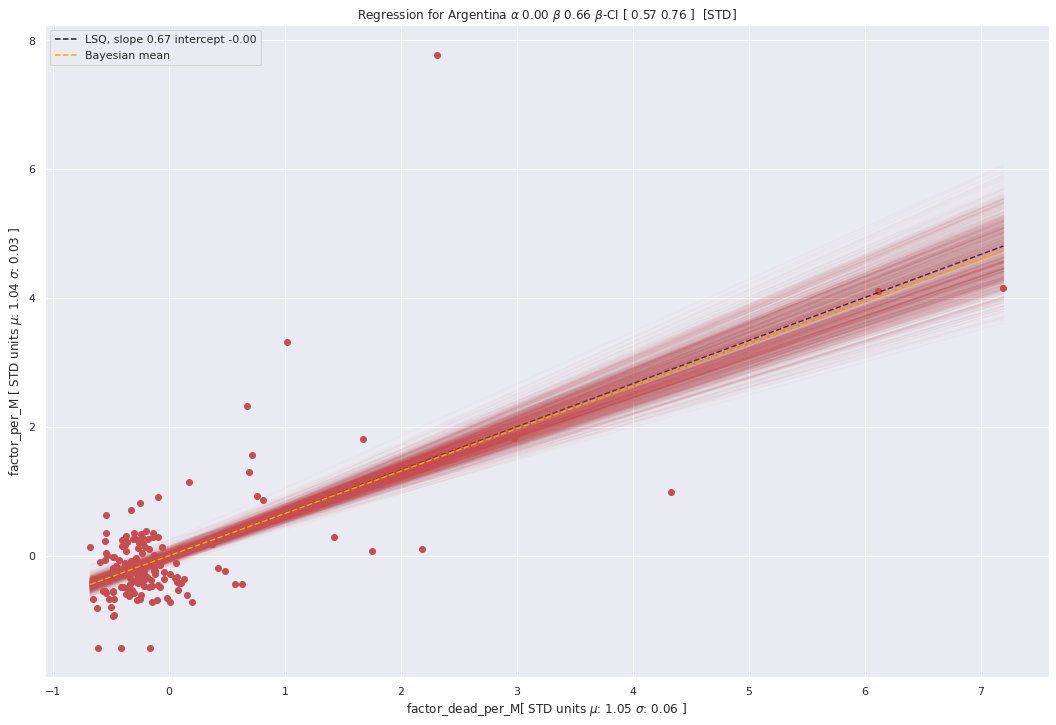

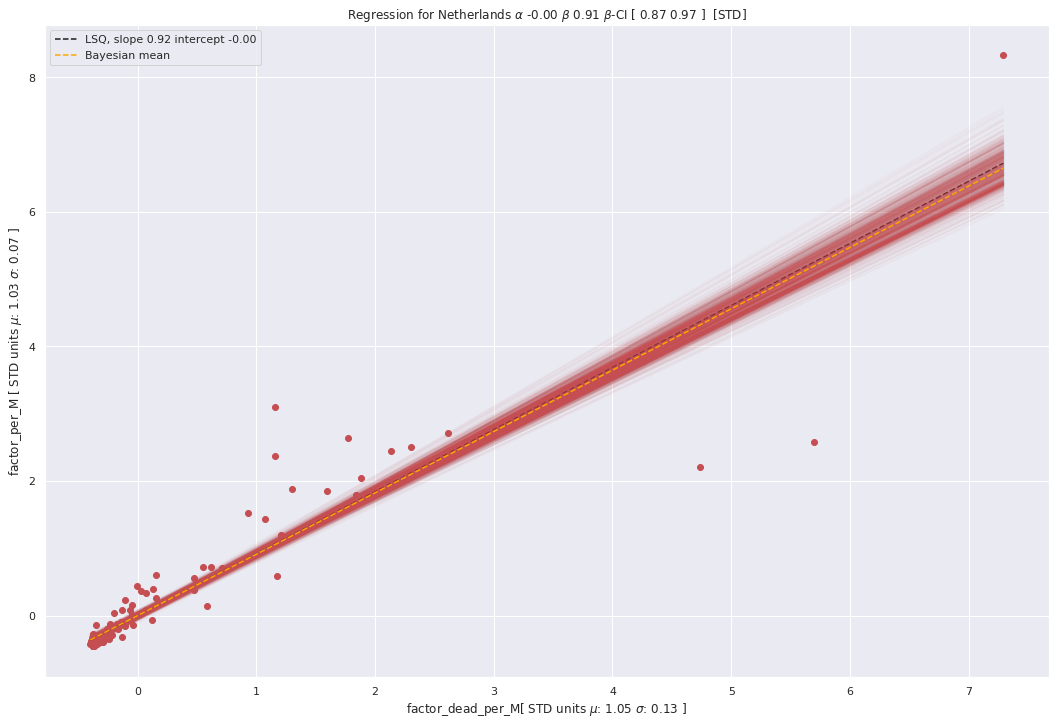

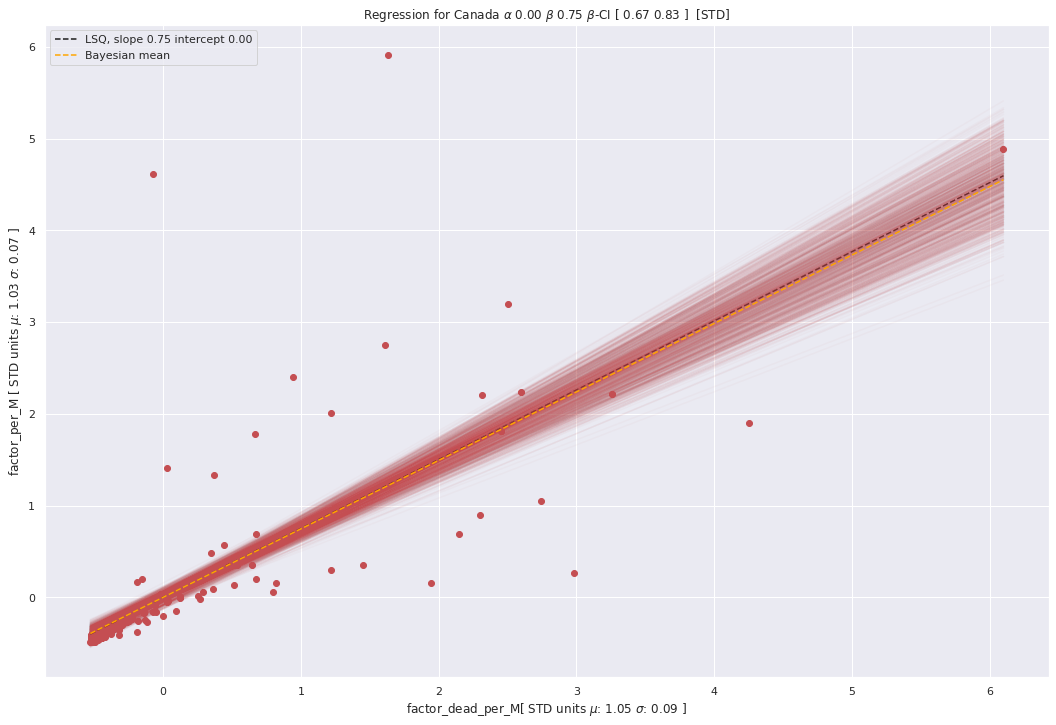

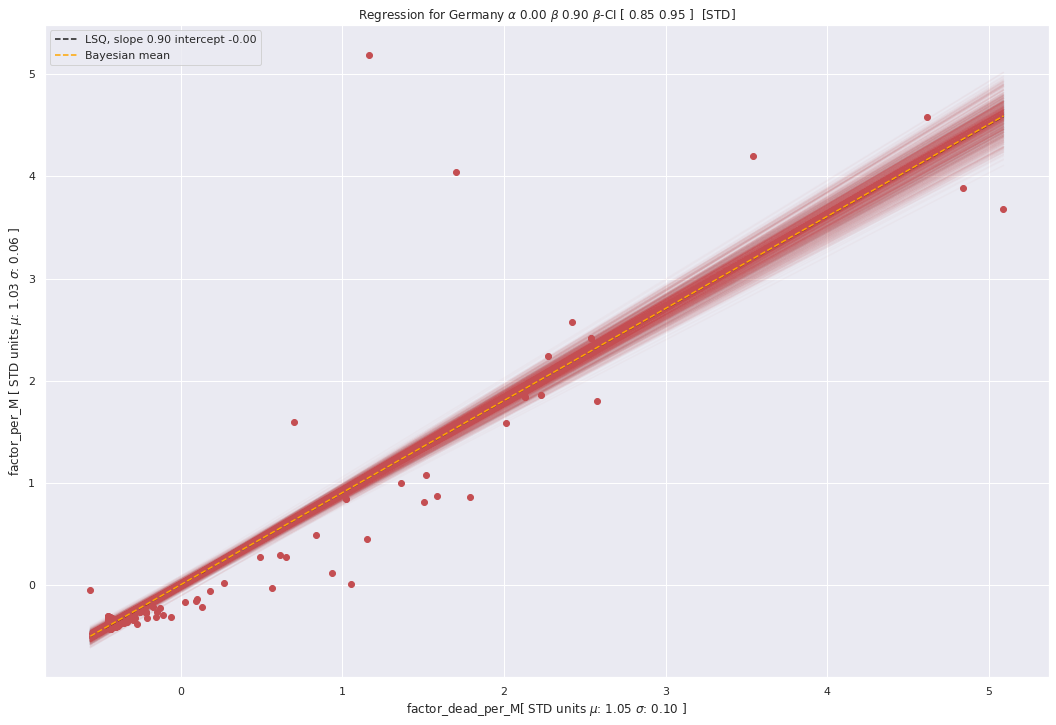

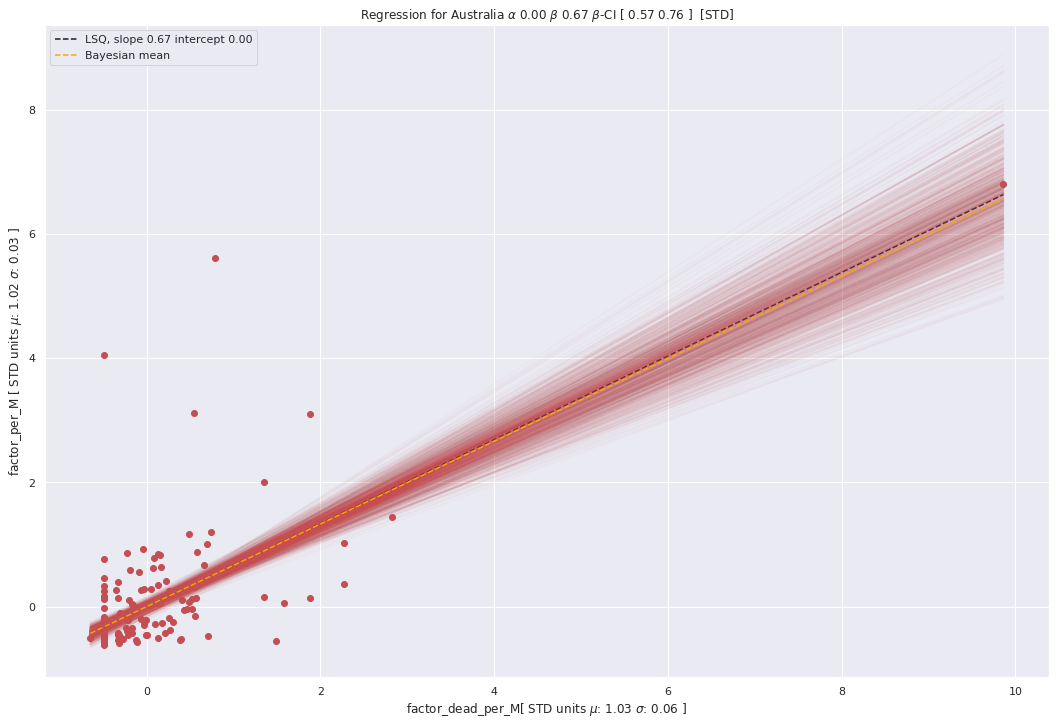

In [11]:

x_param = 'factor_dead_per_M'
y_param = 'factor_per_M'

def regression(x,y,country):
    
    def standardize(x):
        return (x - x.mean()) / x.std()
    
    x_org = x
    y_org = y
    
    x = standardize(x)
    y = standardize(y)
        
    plt.figure(figsize=(18,12))
    plt.ylabel(y_param + r' [ STD units $\mu$: {:.2f} $\sigma$: {:.2f} ]'.format(y_org.mean(),y_org.std()))
    plt.xlabel(x_param + r'[ STD units $\mu$: {:.2f} $\sigma$: {:.2f} ]'.format(x_org.mean(),x_org.std()))
    plt.scatter(x,y,color='r')
    
    slope,intercept,_,_,_ = sps.linregress(x,y)
    
    X = np.linspace(min(x),max(x),1000)
    
    plt.plot(X,[X[i] * slope + intercept for i in range(len(X))], color='k',ls='dashed',
            label='LSQ, slope {:.2f} intercept {:.2f}'.format(slope,intercept))
    
    model = pm.Model()
    with model:
    
        beta_mu = pm.Uniform('beta_mu',-0.5,0.5)
        beta_sigma = pm.Uniform('beta_sigma',0,1)
        alpha_mu = pm.Uniform('alpha_mu', -0.5, 0.5)
        alpha_sigma = pm.Uniform('alpha_sigma',0,1)

        beta = pm.Normal('beta',beta_mu,sd=beta_sigma )
        alpha = pm.Normal('alpha',alpha_mu,sd=alpha_sigma)

        obs_sigma = pm.Uniform('obs_sigma',0,1)

        
        linreq =  pm.Deterministic('linreq',x.values * beta + alpha)

        obs = pm.Normal('obs',mu=linreq,sd=obs_sigma,observed=y)

        trace = pm.sample(500,tune=500)
    
    beta_post = trace['beta'][:]
    alpha_post = trace['alpha'][:]
    
    result = pd.DataFrame({'beta_post': beta_post,
                          'alpha_post' : alpha_post})
    
    print()
    print (result.describe())
    
    CI_89 = np.percentile(result.beta_post,[5.5,94.5])
    
    plt.title(r'Regression for {} $\alpha$ {:.2f} $\beta$ {:.2f} $\beta$-CI [ {:.2f} {:.2f} ]  [STD]'.format(
        country,result.alpha_post.mean(),result.beta_post.mean(),CI_89[0],CI_89[1]))

    
    beta_samples = np.random.choice(result.beta_post,replace=True,size=len(X))
    alpha_samples = np.random.choice(result.alpha_post,replace=True,size=len(X))
    
    lines = np.array([X[i] * beta_samples + alpha_samples for i in range(len(X))])
    plt.plot(X,lines,alpha=0.03,color='r')
    
    plt.plot(X,[X[i] * result.beta_post.mean() + result.alpha_post.mean() for i in range(len(X))],
             color='orange',ls='dashed',label='Bayesian mean')
 
    plt.legend(loc='upper left')
    
    plt.savefig('growth_factor_regression_{}.jpg'.format(country),format='jpg')
    
for country in countries:

    df = dick[country]
    
    try:
        df = df.drop(['dead_conf_ratio','conf_over_dead'],axis=1)
    except:
        print ('Skipping delete col for {}'.format(country))
        
    population = country_populations.loc[country,'population']
    df['conf_per_M'] = df['confirmed'] / (population / 1e6)
    df['dead_per_M'] = df['deceased'] / (population / 1e6)
    df['factor_per_M'] = df['conf_per_M'] / df['conf_per_M'].shift()
    df['factor_dead_per_M'] = df['dead_per_M'] / df['dead_per_M'].shift()
    
    mask = ( ( df['confirmed'] >= confirmed_min ) & ( df['deceased'] >= dead_min))
    df = df[mask]
    df = df.replace(np.inf,np.nan)
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    model = pm.Model()
    with model:
        regression(df[x_param],df[y_param],country)


In [12]:
shifted_df = df.copy()
shifted_df[x_param] = shifted_df[x_param].shift(7)
shifted_df.dropna(inplace=True)

x_param = 'dead_inc'
y_param = 'inc'
#regression(shifted_df[x_param],shifted_df[y_param],'Italy')



In [13]:
def plot_trend(country_name):
    
    country = dick[country_name]
    
    plt.figure(figsize=(18,12))
    plt.title('{} growth of confirmed and deceased'.format(country_name.upper()))
    ax = plt.gca()
    ax2 = plt.twinx()
    country['inc'].cumsum().plot(ax=ax,color='orange',label='cumulative inc daily confirmed')
    country['dead_inc'].cumsum().plot(ax=ax2,color='red',label='cumulative inc daily deceased')
    ax.set_ylabel('Confirmed')
    ax2.set_ylabel('Deceased')
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')
    #ax.set_yscale('log')
    #ax2.set_yscale('log')
    plt.savefig('{}_growth_confirmed_deceased.jpg'.format(country_name.upper()),format='jpg')

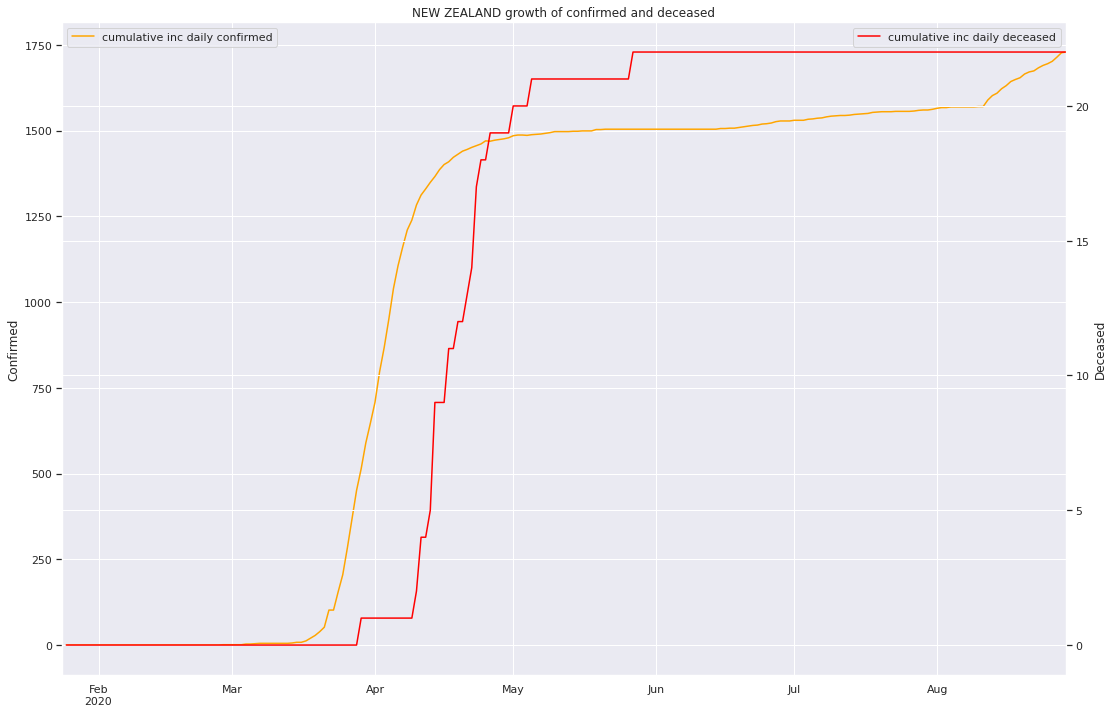

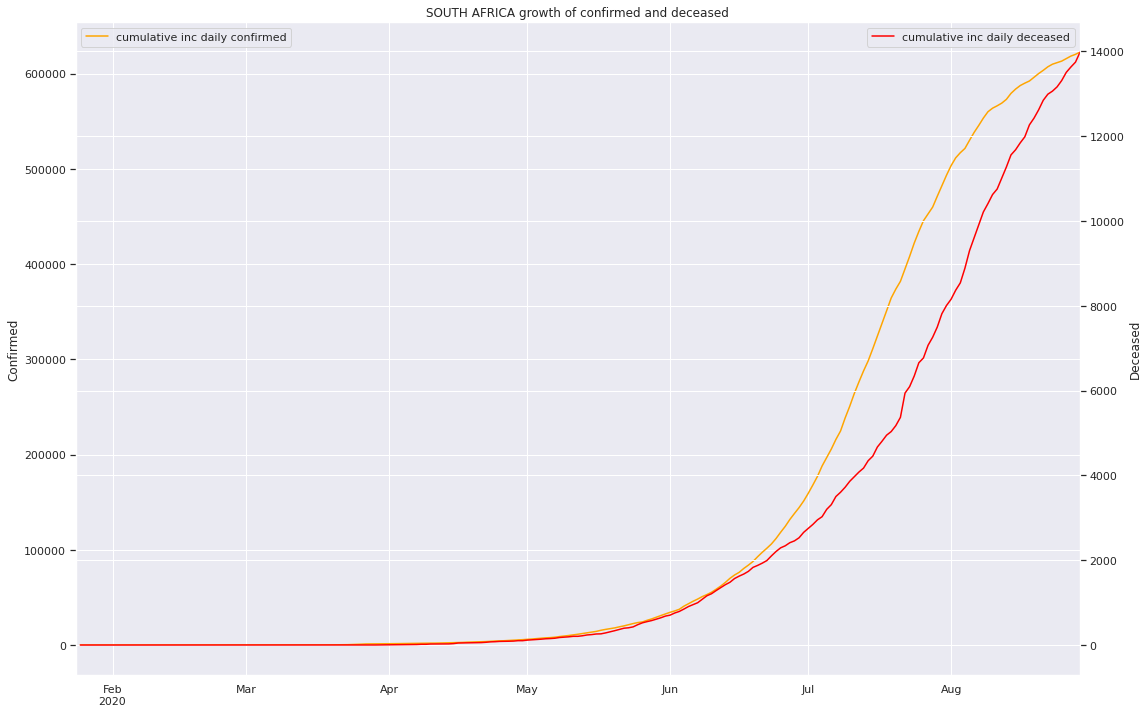

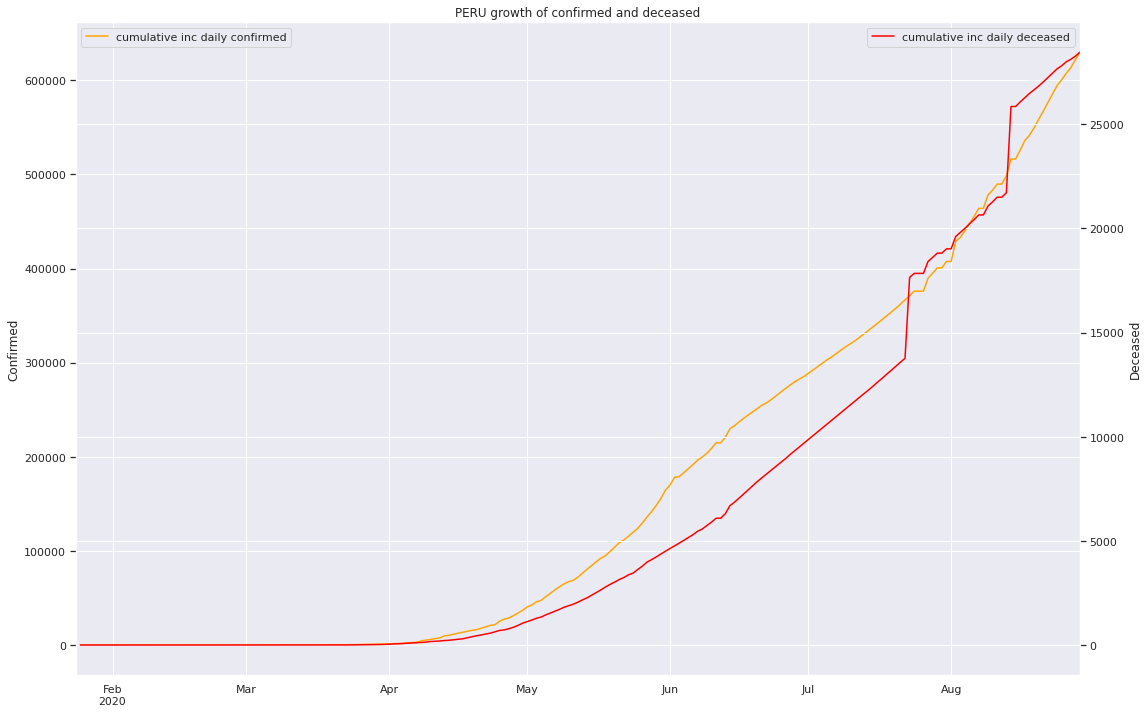

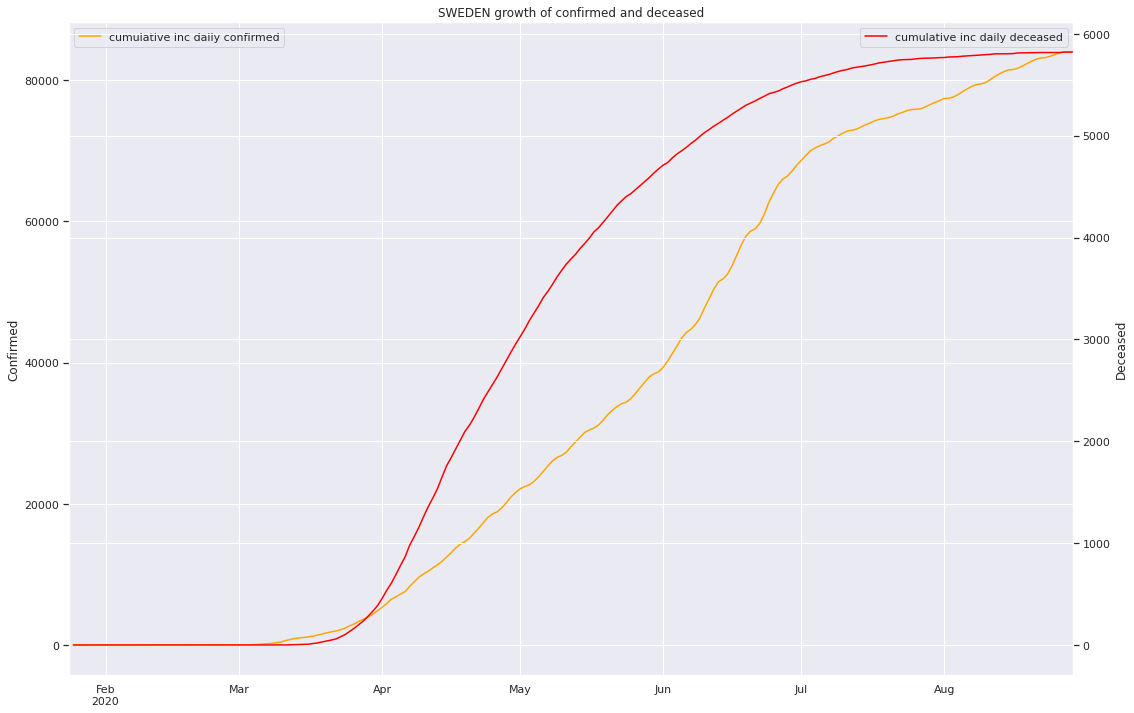

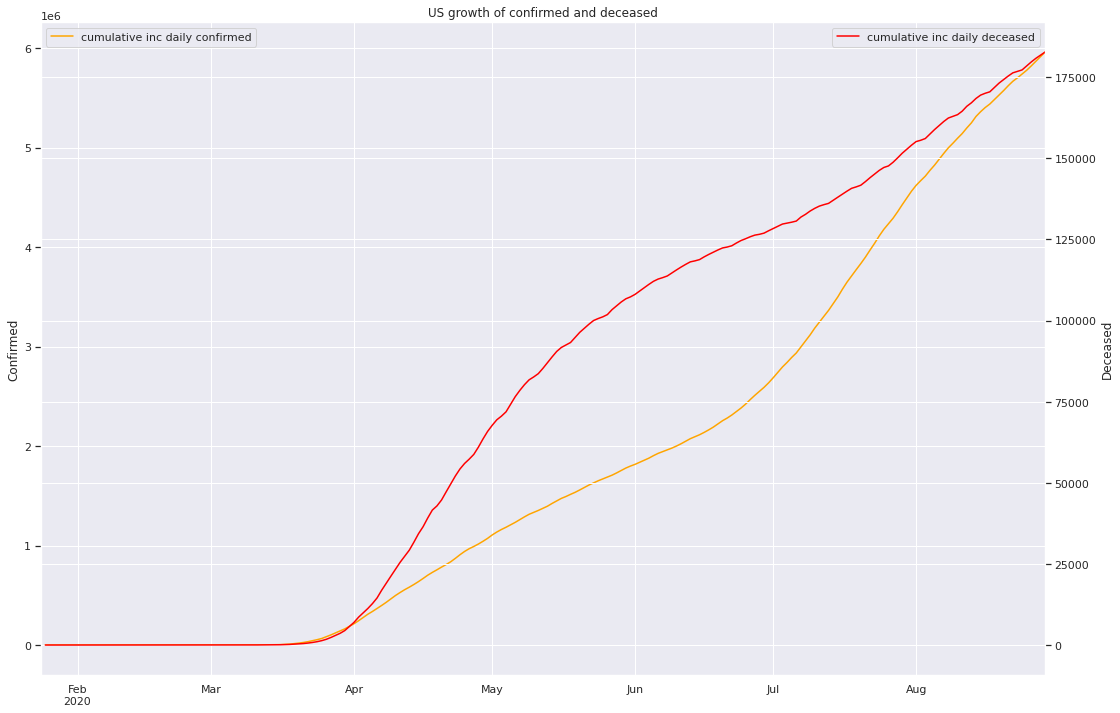

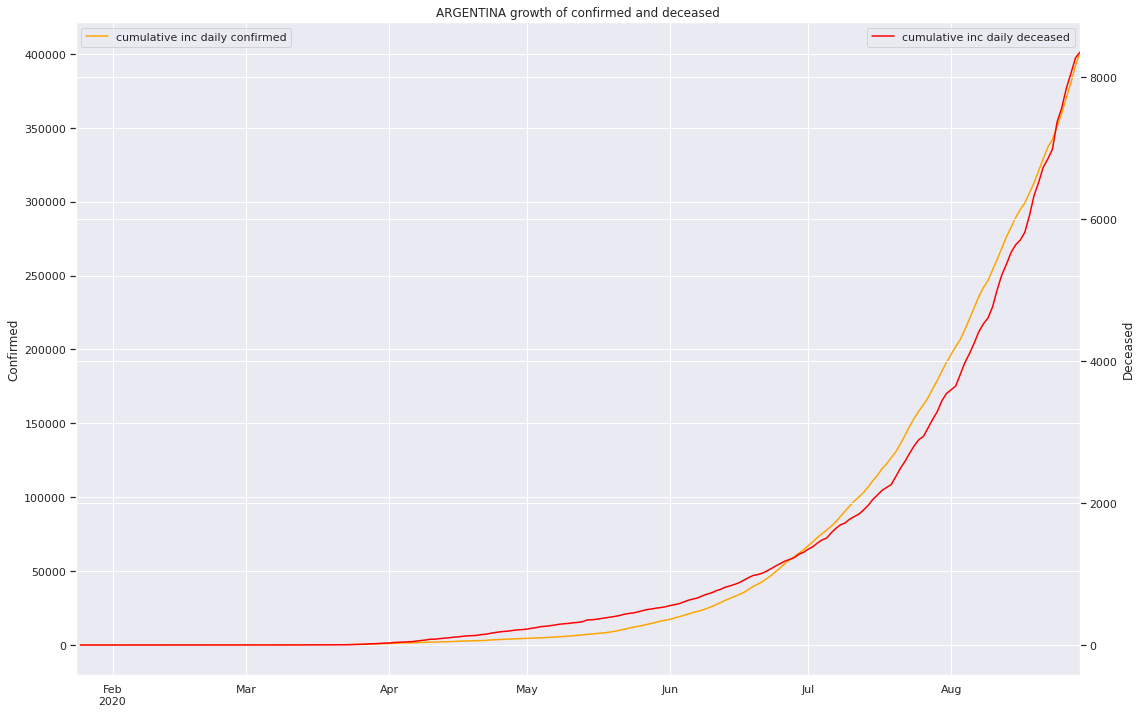

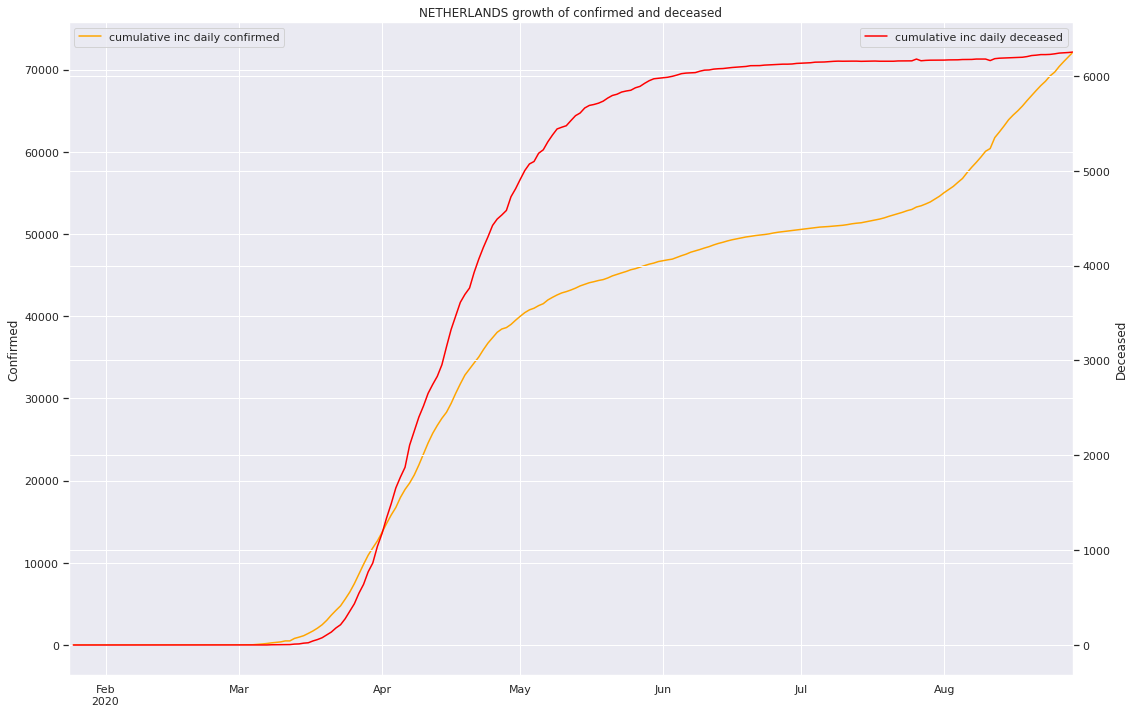

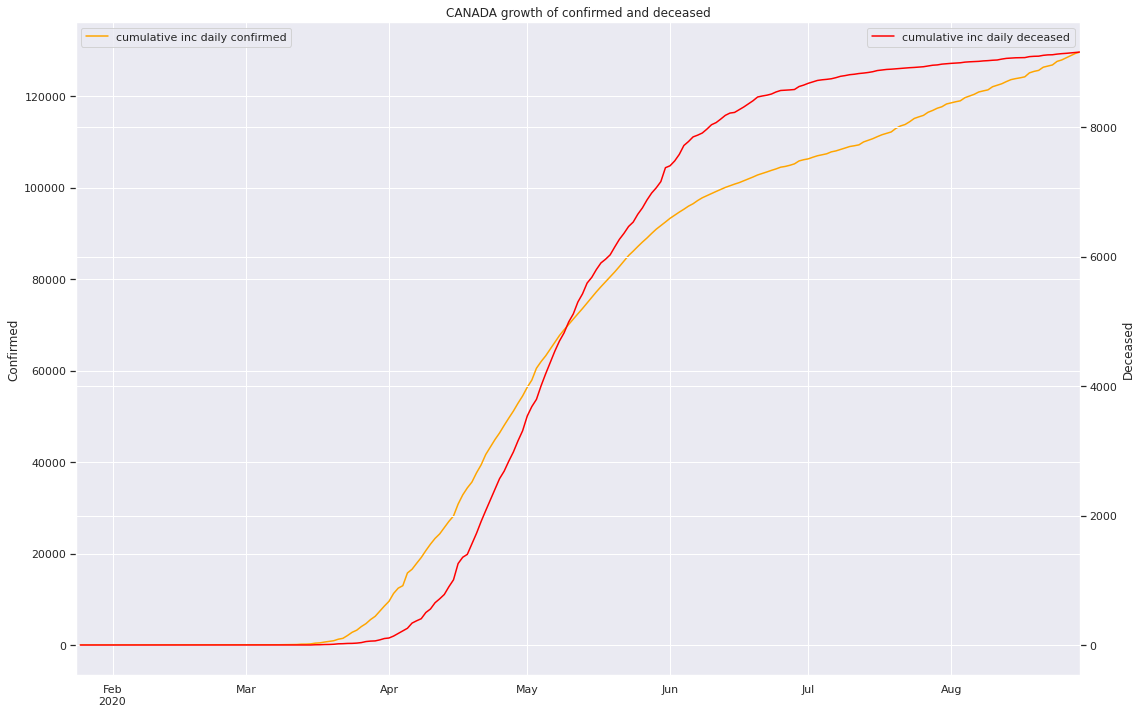

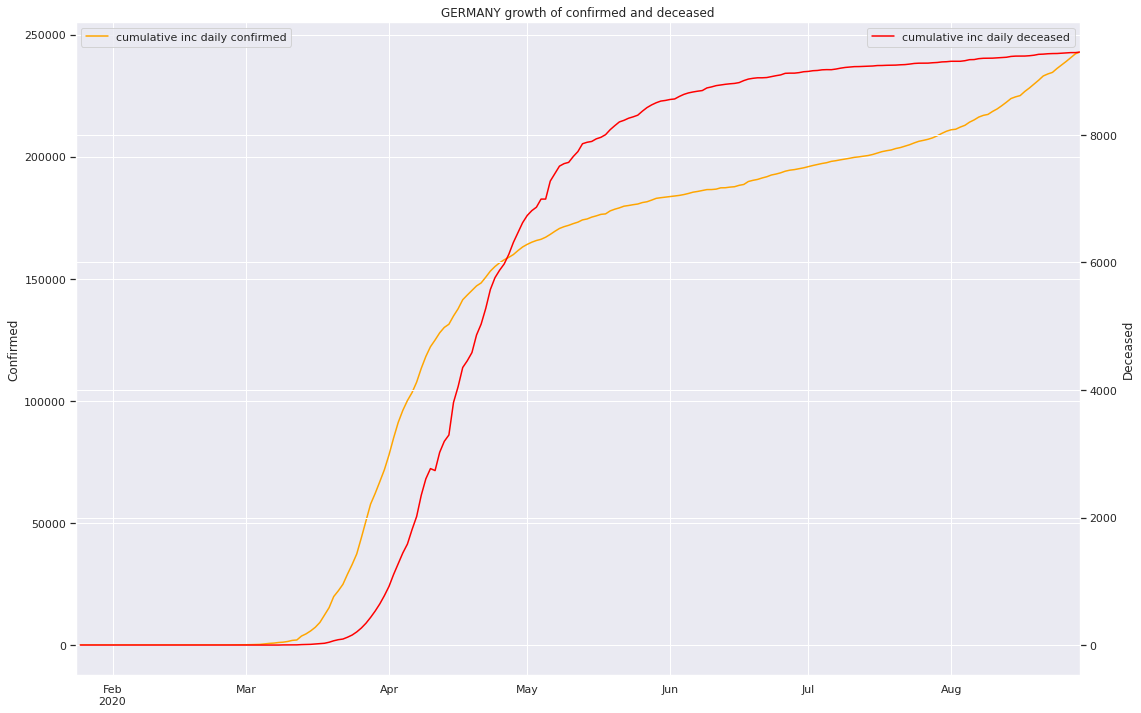

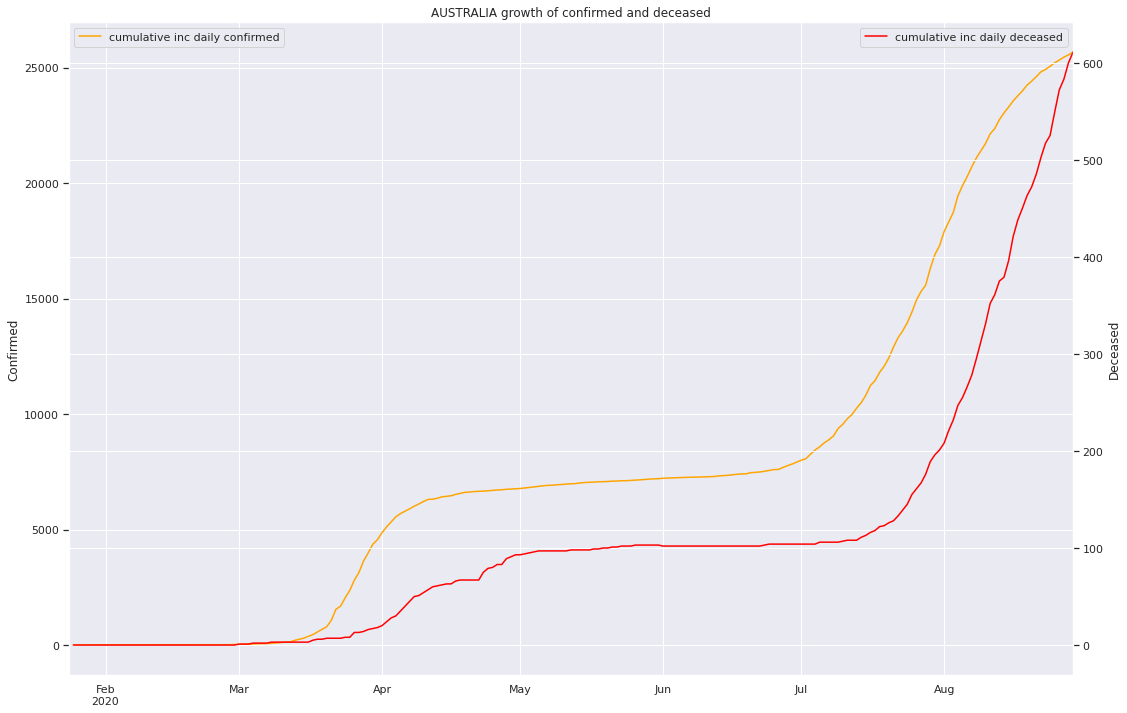

In [14]:
for c in countries:
    plot_trend(c)

<ipython-input-15-c8ba617bf66e>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(211)
<ipython-input-15-c8ba617bf66e>:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(212)
<ipython-input-15-c8ba617bf66e>:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and return

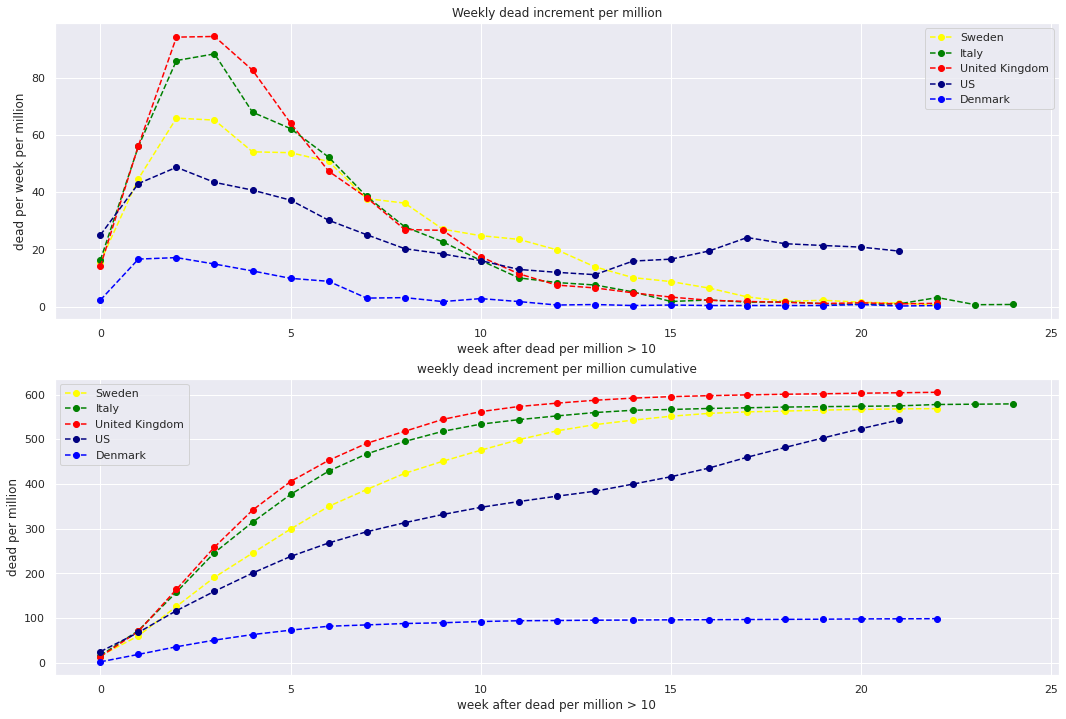

In [15]:
countries = ['Sweden','Italy','United Kingdom','US','Denmark']
colors = ['yellow','green','red','navy','blue']

plt.figure(figsize=(18,12))


for i,c in enumerate(countries):
    country = dick[c]
    country['dead_inc_per_M'] = country['dead_inc'] / (country_populations.loc[c,'population'] / 1e6)
    country = country.loc[country['dead_per_M'] > 10]
    country_weekly = country.resample(yesterday(today)).sum()
    country.reset_index(inplace=True)
    country_weekly.reset_index(inplace=True)
    
    plt.subplot(211)
    plt.title('Weekly dead increment per million')
    plt.plot(country_weekly.index,country_weekly['dead_inc_per_M'],'o--',color=colors[i],label=c)

    plt.legend(loc='upper right')
    plt.ylabel('dead per week per million')
    plt.xlabel('week after dead per million > 10')
    
    plt.subplot(212)
    plt.title('weekly dead increment per million cumulative')
    plt.plot(country_weekly.index,country_weekly['dead_inc_per_M'].cumsum(),'o--',color=colors[i],label=c)
    plt.xlabel('week after dead per million > 10')
    plt.ylabel('dead per million')
    plt.legend(loc='upper left')

In [16]:
swe = dick['Sweden']
swe

confirmed    factor    inc  deceased  dead_factor  dead_inc  \
2020-01-24          0       NaN    NaN         0          NaN       NaN   
2020-01-25          0       NaN    0.0         0          NaN       0.0   
2020-01-26          0       NaN    0.0         0          NaN       0.0   
2020-01-27          0       NaN    0.0         0          NaN       0.0   
2020-01-28          0       NaN    0.0         0          NaN       0.0   
...               ...       ...    ...       ...          ...       ...   
2020-08-25      83578  1.002699  225.0      5816     1.000000       0.0   
2020-08-26      83824  1.002943  246.0      5816     1.000000       0.0   
2020-08-27      83958  1.001599  134.0      5820     1.000688       4.0   
2020-08-28      83958  1.000000    0.0      5821     1.000172       1.0   
2020-08-29      83958  1.000000    0.0      5821     1.000000       0.0   

            pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  \
2020-01-24       NaN             NaN              NaN     0.000000   
2020-01-25       NaN             NaN              NaN     0.000000   
2020-01-26       NaN             NaN              NaN     0.000000   
2020-01-27       NaN             NaN              NaN     0.000000   
2020-01-28       NaN             NaN              NaN     0.000000   
...              ...             ...              ...          ...   
2020-08-25  6.958769       14.370358         0.997308  8275.651743   
2020-08-26  6.938347       14.412655         0.997065  8300.009951   
2020-08-27  6.932037       14.425773         0.999091  8313.278244   
2020-08-28  6.933229       14.423295         1.000172  8313.278244   
2020-08-29  6.933229       14.423295         1.000000  8313.278244   

            dead_per_M  factor_per_M  factor_dead_per_M  dead_inc_per_M  
2020-01-24    0.000000           NaN                NaN             NaN  
2020-01-25    0.000000           NaN                NaN        0.000000  
2020-01-26    0.000000           NaN                NaN        0.000000  
2020-01-27    0.000000           NaN                NaN        0.000000  
2020-01-28    0.000000           NaN                NaN        0.000000  
...                ...           ...                ...             ...  
2020-08-25  575.883493      1.002699           1.000000        0.000000  
2020-08-26  575.883493      1.002943           1.000000        0.000000  
2020-08-27  576.279561      1.001599           1.000688        0.396068  
2020-08-28  576.378578      1.000000           1.000172        0.099017  
2020-08-29  576.378578      1.000000           1.000000        0.000000  

[219 rows x 14 columns]

In [17]:
swe

confirmed    factor    inc  deceased  dead_factor  dead_inc  \
2020-01-24          0       NaN    NaN         0          NaN       NaN   
2020-01-25          0       NaN    0.0         0          NaN       0.0   
2020-01-26          0       NaN    0.0         0          NaN       0.0   
2020-01-27          0       NaN    0.0         0          NaN       0.0   
2020-01-28          0       NaN    0.0         0          NaN       0.0   
...               ...       ...    ...       ...          ...       ...   
2020-08-25      83578  1.002699  225.0      5816     1.000000       0.0   
2020-08-26      83824  1.002943  246.0      5816     1.000000       0.0   
2020-08-27      83958  1.001599  134.0      5820     1.000688       4.0   
2020-08-28      83958  1.000000    0.0      5821     1.000172       1.0   
2020-08-29      83958  1.000000    0.0      5821     1.000000       0.0   

            pct_dead  conf_over_dead  dead_conf_ratio   conf_per_M  \
2020-01-24       NaN             NaN              NaN     0.000000   
2020-01-25       NaN             NaN              NaN     0.000000   
2020-01-26       NaN             NaN              NaN     0.000000   
2020-01-27       NaN             NaN              NaN     0.000000   
2020-01-28       NaN             NaN              NaN     0.000000   
...              ...             ...              ...          ...   
2020-08-25  6.958769       14.370358         0.997308  8275.651743   
2020-08-26  6.938347       14.412655         0.997065  8300.009951   
2020-08-27  6.932037       14.425773         0.999091  8313.278244   
2020-08-28  6.933229       14.423295         1.000172  8313.278244   
2020-08-29  6.933229       14.423295         1.000000  8313.278244   

            dead_per_M  factor_per_M  factor_dead_per_M  dead_inc_per_M  
2020-01-24    0.000000           NaN                NaN             NaN  
2020-01-25    0.000000           NaN                NaN        0.000000  
2020-01-26    0.000000           NaN                NaN        0.000000  
2020-01-27    0.000000           NaN                NaN        0.000000  
2020-01-28    0.000000           NaN                NaN        0.000000  
...                ...           ...                ...             ...  
2020-08-25  575.883493      1.002699           1.000000        0.000000  
2020-08-26  575.883493      1.002943           1.000000        0.000000  
2020-08-27  576.279561      1.001599           1.000688        0.396068  
2020-08-28  576.378578      1.000000           1.000172        0.099017  
2020-08-29  576.378578      1.000000           1.000000        0.000000  

[219 rows x 14 columns]

In [18]:
swe_weekly = swe.resample('w').sum()
swe_weekly

confirmed     factor     inc  deceased  dead_factor  dead_inc  \
2020-01-26          0   0.000000     0.0         0     0.000000       0.0   
2020-02-02          2   1.000000     1.0         0     0.000000       0.0   
2020-02-09          7   7.000000     0.0         0     0.000000       0.0   
2020-02-16          7   7.000000     0.0         0     0.000000       0.0   
2020-02-23          7   7.000000     0.0         0     0.000000       0.0   
2020-03-01         46  11.439394    13.0         0     0.000000       0.0   
2020-03-08        750  10.543251   211.0         0     0.000000       0.0   
2020-03-15       5121   8.798801   838.0        19     7.566667       7.0   
2020-03-22      10961   7.654937   923.0       220     9.602059      53.0   
2020-03-29      21245   7.721524  1957.0      1208     8.749564     224.0   
2020-04-05      40866   7.626363  3229.0      3782     8.088067     496.0   
2020-04-12      65826   7.433804  3740.0      8116     7.642161     660.0   
2020-04-19      91345   7.302023  3751.0     12808     7.386623     657.0   
2020-04-26     120335   7.256894  4200.0     16803     7.231019     535.0   
2020-05-03     149419   7.187671  3830.0     20657     7.193672     554.0   
2020-05-10     176399   7.170271  4153.0     24303     7.145104     492.0   
2020-05-17     204810   7.136255  3874.0     27249     7.098523     378.0   
2020-05-24     231151   7.113620  3661.0     29788     7.082351     346.0   
2020-05-31     259117   7.118426  4280.0     31851     7.060001     271.0   
2020-06-07     295421   7.146446  6025.0     33700     7.051907     248.0   
2020-06-14     342031   7.150017  7141.0     35402     7.045831     230.0   
2020-06-21     393518   7.129622  7091.0     36862     7.036318     190.0   
2020-06-28     445061   7.120607  7474.0     37966     7.025376     137.0   
2020-07-05     483991   7.062906  4289.0     38774     7.018115     100.0   
2020-07-12     504082   7.030701  2198.0     39392     7.015317      86.0   
2020-07-19     517227   7.022642  1666.0     39872     7.010196      58.0   
2020-07-26     527557   7.017526  1316.0     40204     7.005754      33.0   
2020-08-02     537353   7.020340  1556.0     40347     7.002951      17.0   
2020-08-09     550448   7.025750  2015.0     40477     7.003287      19.0   
2020-08-16     565113   7.025561  2052.0     40613     7.002588      15.0   
2020-08-23     577848   7.020528  1687.0     40702     7.001721      10.0   
2020-08-30     502629   6.009430   787.0     34910     6.000860       5.0   

             pct_dead  conf_over_dead  dead_conf_ratio    conf_per_M  \
2020-01-26   0.000000        0.000000         0.000000      0.000000   
2020-02-02   0.000000        0.000000         0.000000      0.198034   
2020-02-09   0.000000        0.000000         0.000000      0.693120   
2020-02-16   0.000000        0.000000         0.000000      0.693120   
2020-02-23   0.000000        0.000000         0.000000      0.693120   
2020-03-01   0.000000        0.000000         0.000000      4.554787   
2020-03-08   0.000000        0.000000         0.000000     74.262830   
2020-03-15   2.143102     2087.823810         6.401895    507.066603   
2020-03-22  13.062910      469.344379         8.771356   1085.326506   
2020-03-29  38.213587      134.287538         7.932280   2103.618432   
2020-04-05  63.560198       78.155910         7.425545   4046.433082   
2020-04-12  85.829439       57.226244         7.196860   6517.900065   
2020-04-19  98.035756       49.996368         7.081396   9044.717611   
2020-04-26  97.824812       50.097333         6.975650  11915.223534   
2020-05-03  96.781612       50.634198         7.006438  14795.037065   
2020-05-10  96.499274       50.785727         6.975739  17466.518603   
2020-05-17  93.185934       52.595152         6.963316  20279.693621   
2020-05-24  90.238915       54.306404         6.969412  22887.903229   
2020-05-31  86.102990       56.928910         6.942759  25657.015634   
2020-06-07  79.961034       61

<BarContainer object of 32 artists>

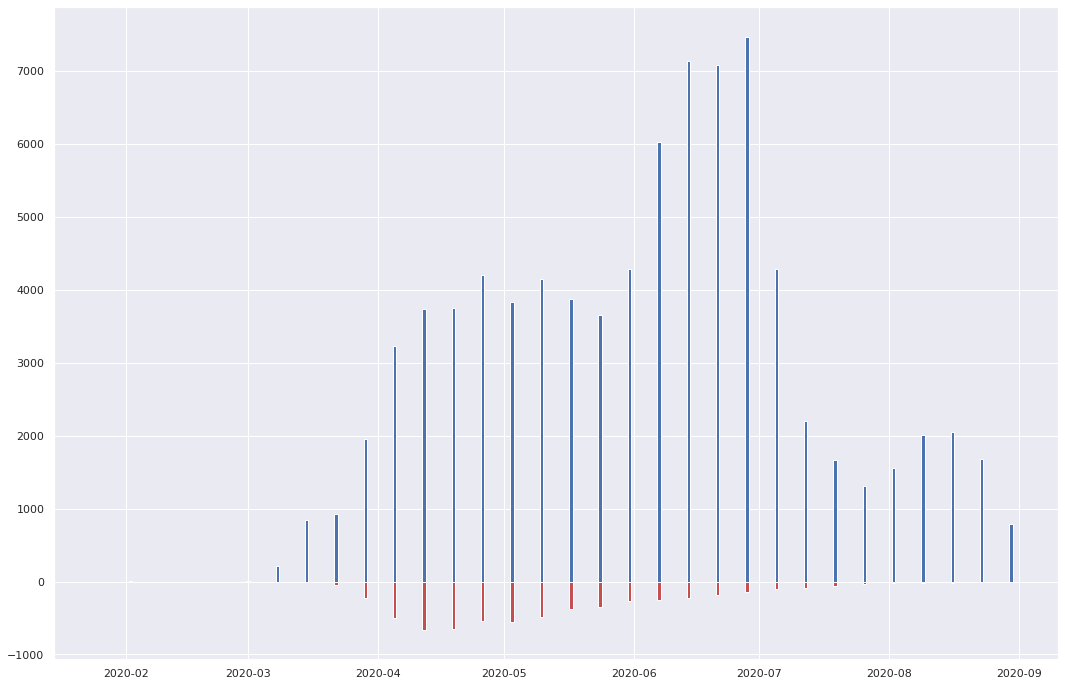

In [19]:
plt.figure(figsize=(18,12))
ax=plt.gca()
ax.bar(swe_weekly.index,swe_weekly['inc'])
ax.bar(swe_weekly.index,-swe_weekly['dead_inc'],color='r')


<BarContainer object of 32 artists>

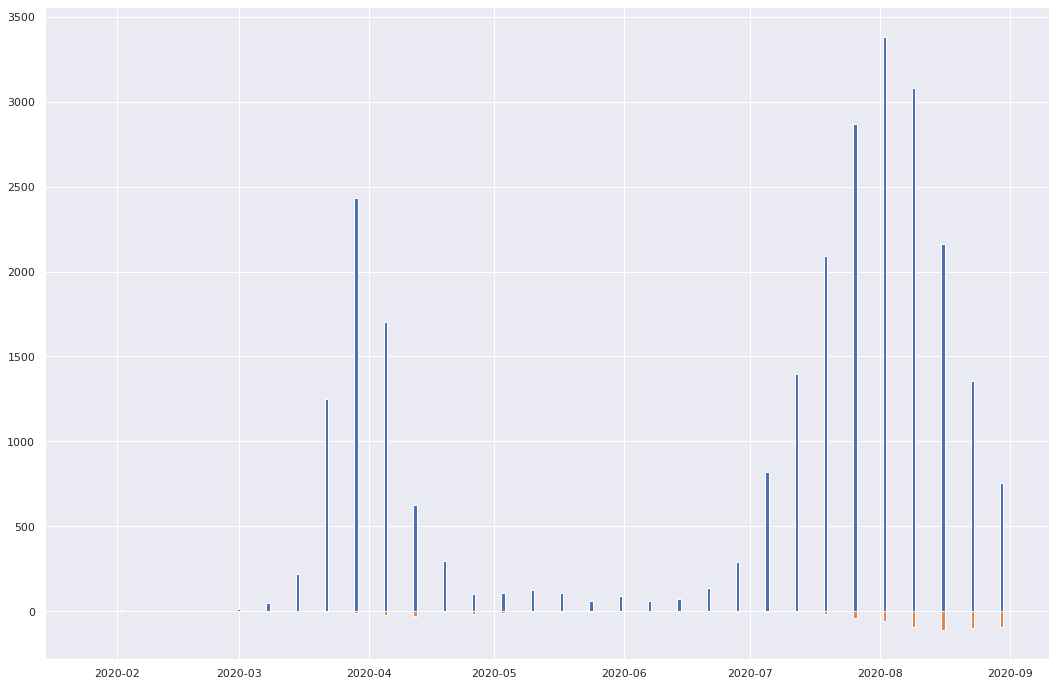

In [20]:
aus = dick['Australia']
aus_weekly = aus.resample('w').sum()

plt.figure(figsize=(18,12))
plt.bar(aus_weekly.index,aus_weekly['inc'])
plt.bar(aus_weekly.index,-aus_weekly['dead_inc'])

<BarContainer object of 32 artists>

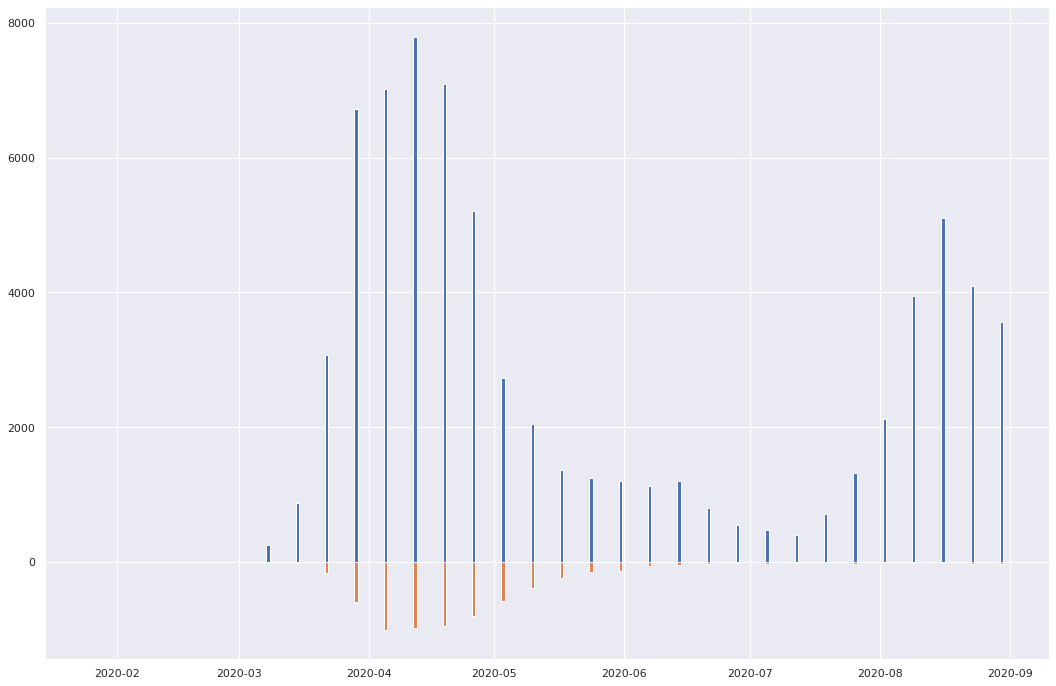

In [21]:
ned = dick['Netherlands']
ned_weekly = ned.resample('w').sum()

plt.figure(figsize=(18,12))
plt.bar(ned_weekly.index,ned_weekly['inc'])
plt.bar(ned_weekly.index,-ned_weekly['dead_inc'])

In [22]:
def normalize(series):
    return series / series.max()

def reflexive_plot(country_name):
    
    country = dick[country_name][:-1]
    last_date = country.index[-1].date()
    
    country_weekly = country.resample('w').sum()
    
    plt.figure(figsize=(18,12))
    plt.title(country_name.upper() + ' Normalized weekly cases and deaths YTD {} '.format(last_date))
    plt.bar(country_weekly.index,normalize(country_weekly['inc']),label='cases',color='orange')
    plt.bar(country_weekly.index,-normalize(country_weekly['dead_inc']),label='deaths',color='crimson')
    plt.yticks(np.arange(-1,1.25,0.25),np.abs(np.arange(-1,1.25,0.25)))
    plt.legend(loc='upper left')
    plt.ylabel('Normalized values')
    
    plt.savefig('normalized_cases_deaths_{}.jpg'.format(country_name),format='jpg')
    
    
    

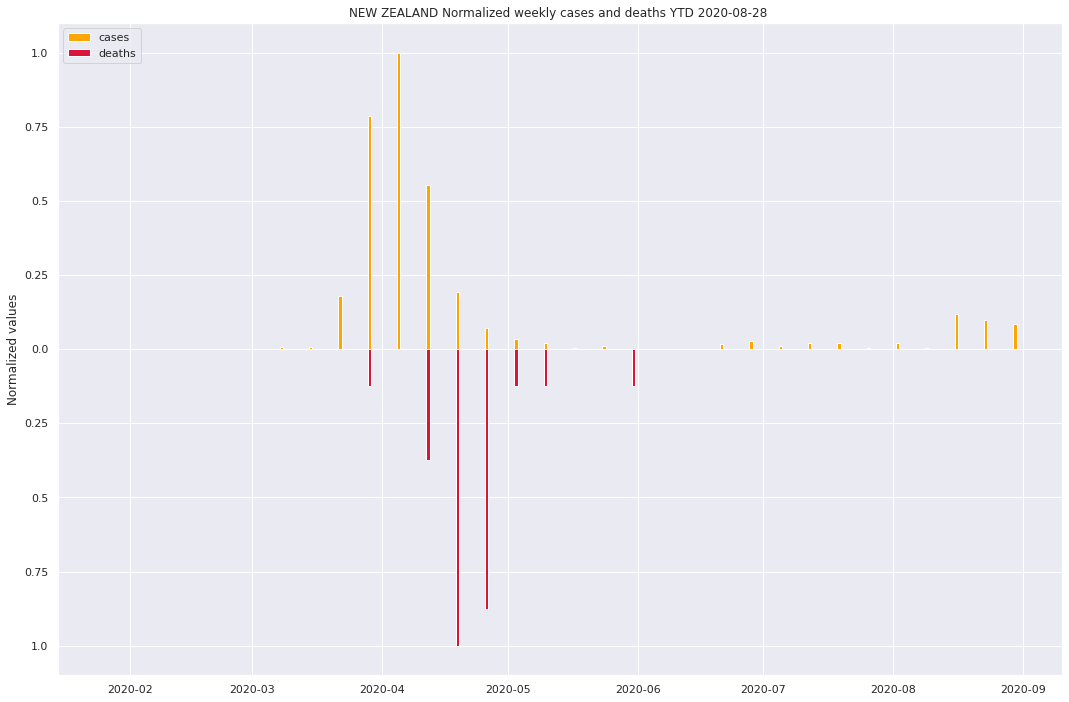

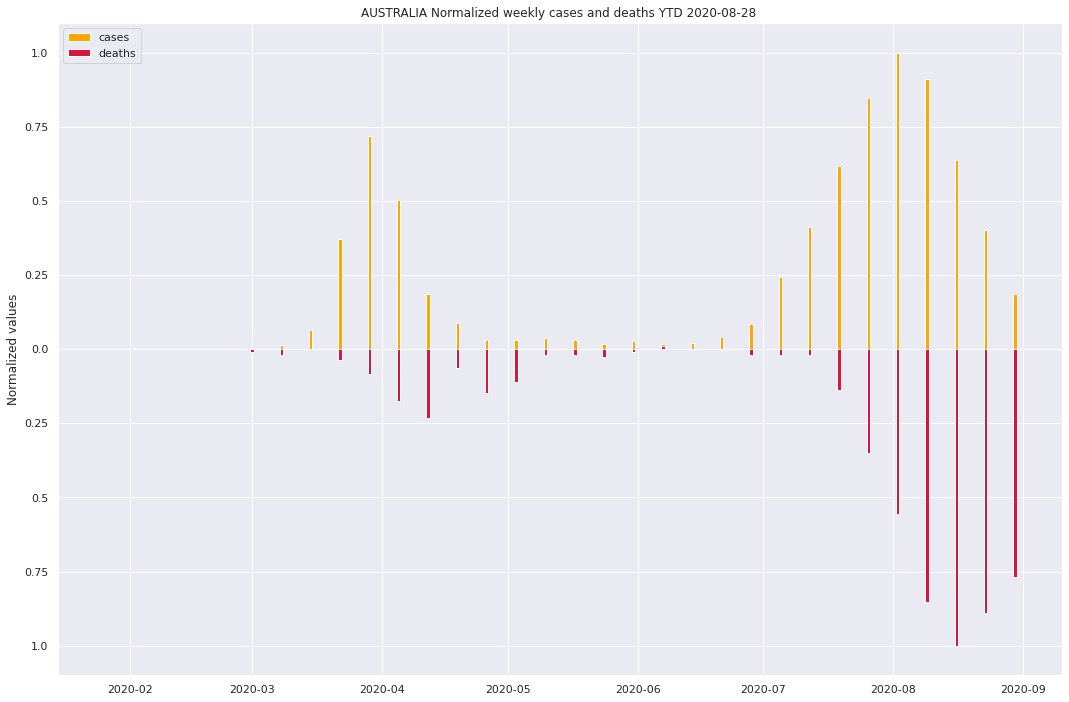

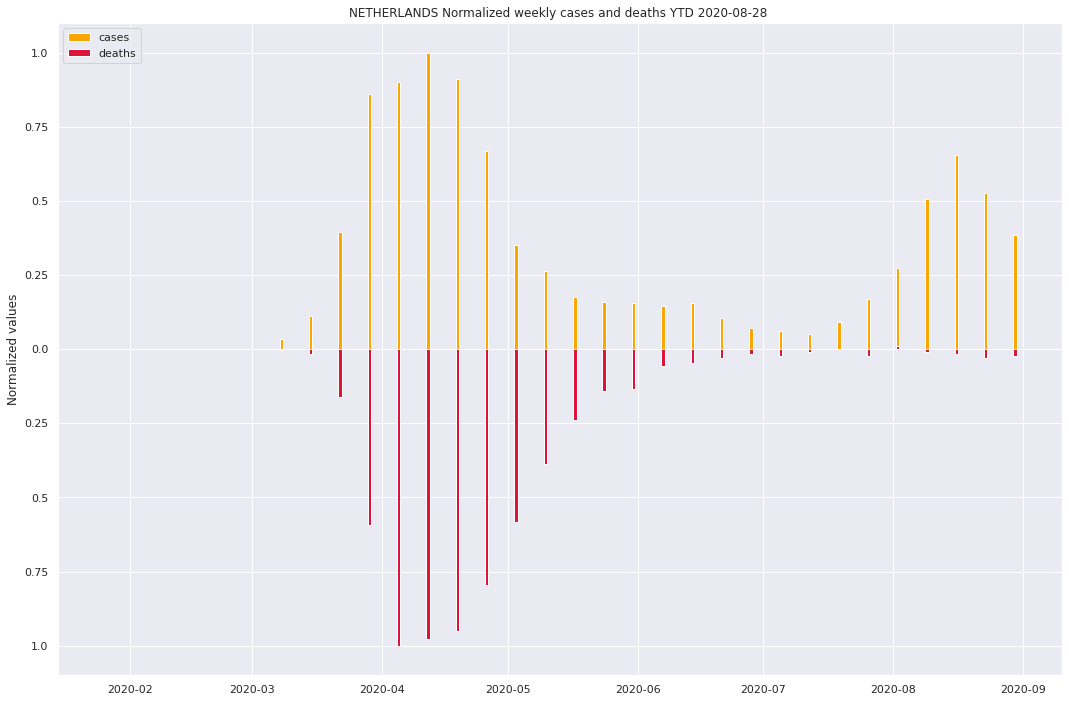

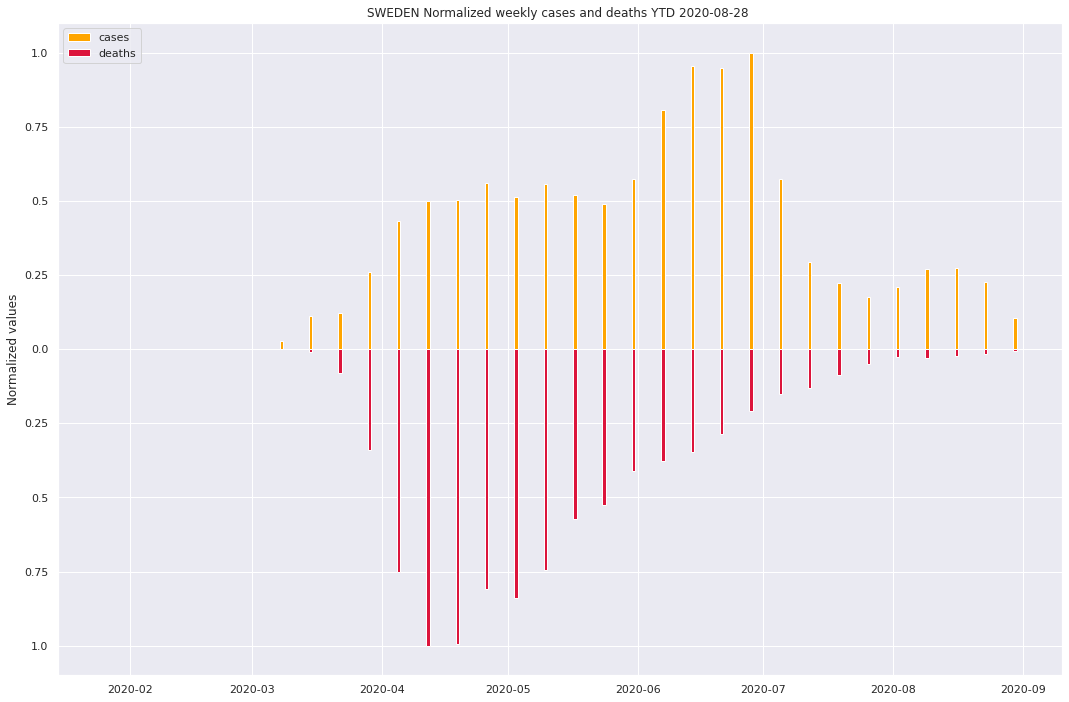

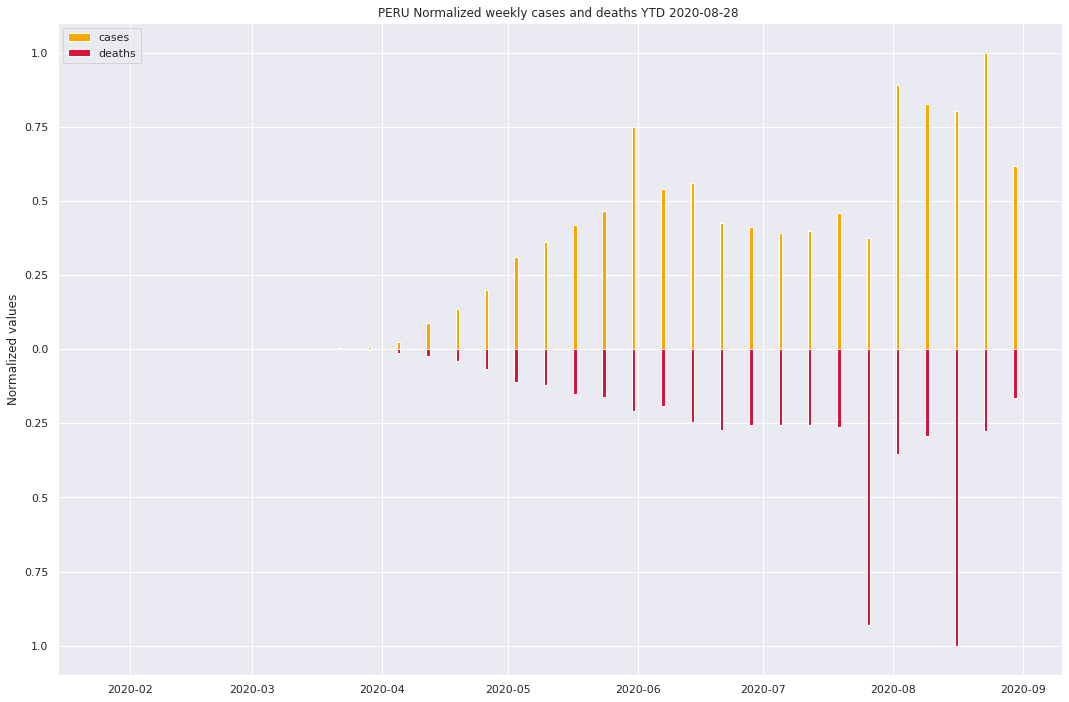

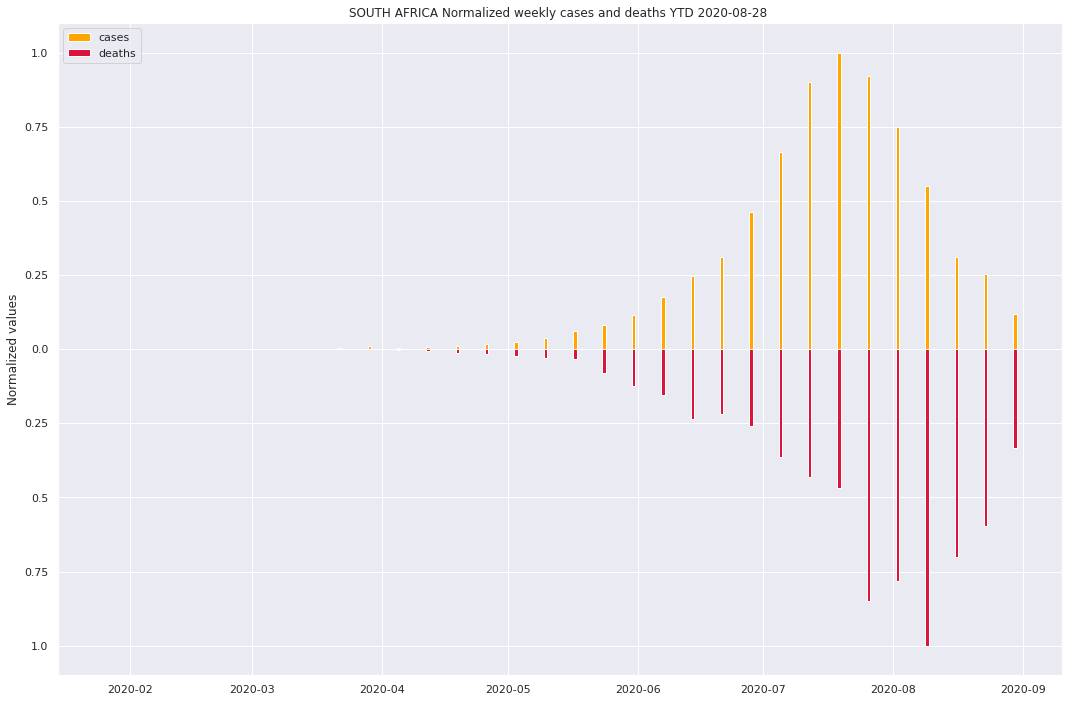

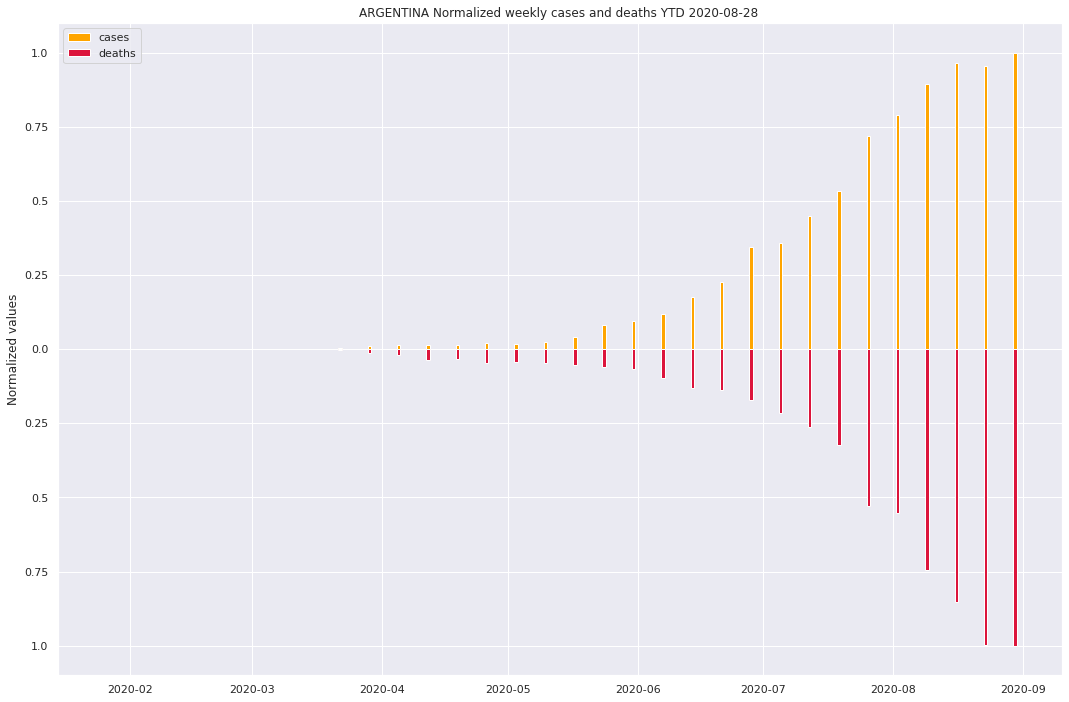

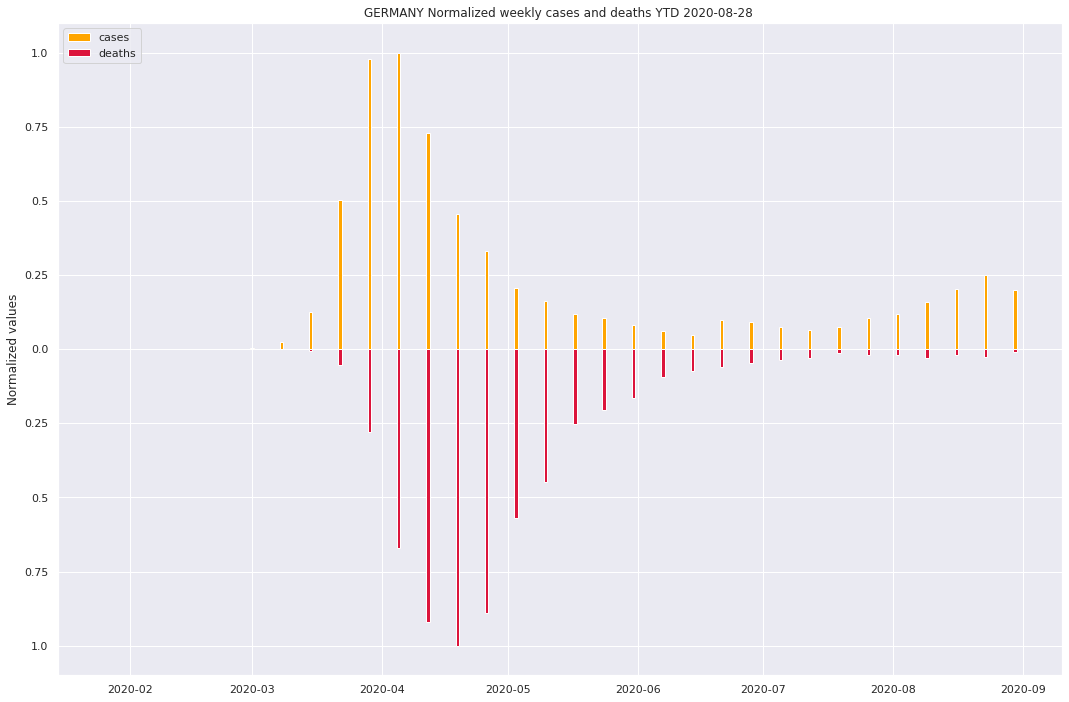

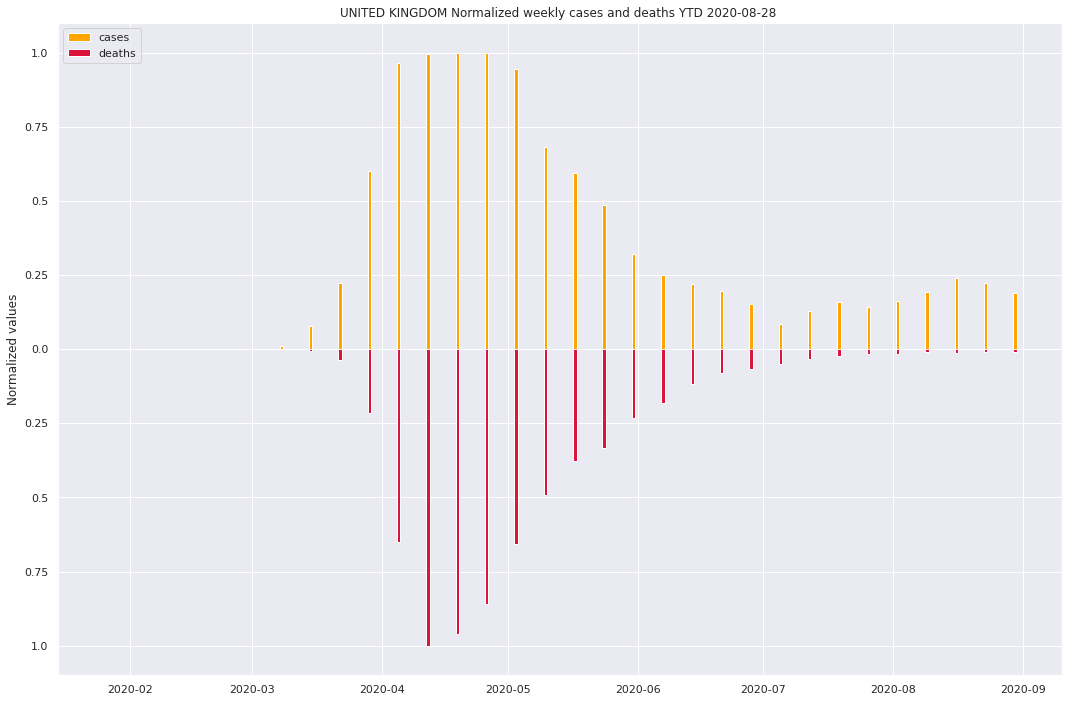

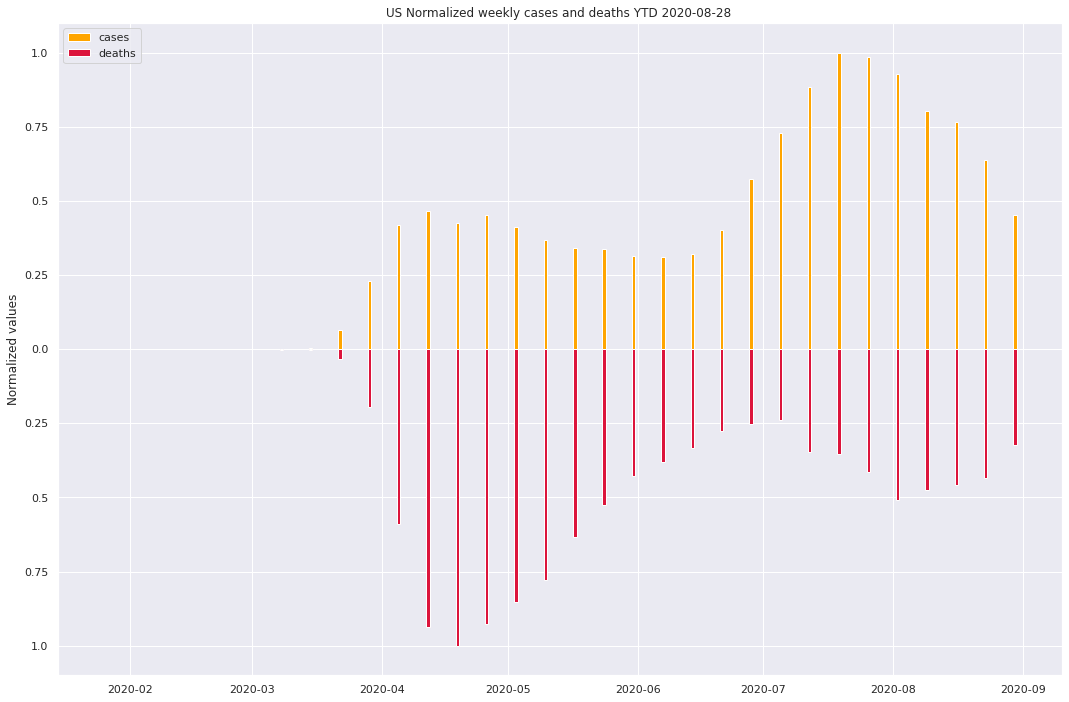

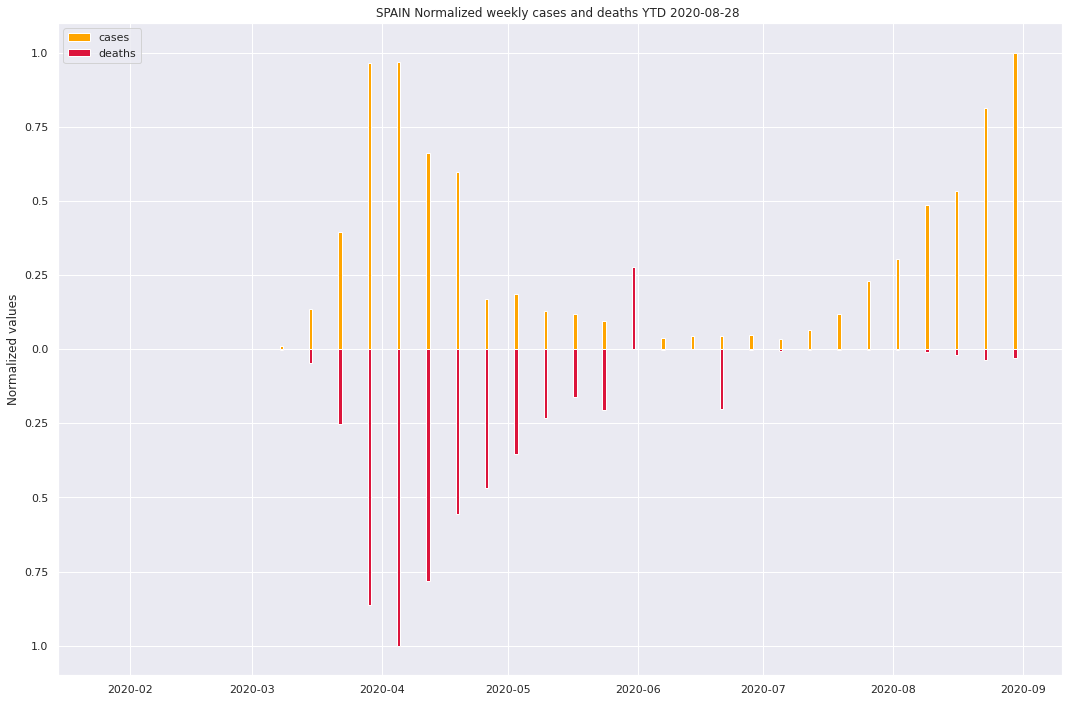

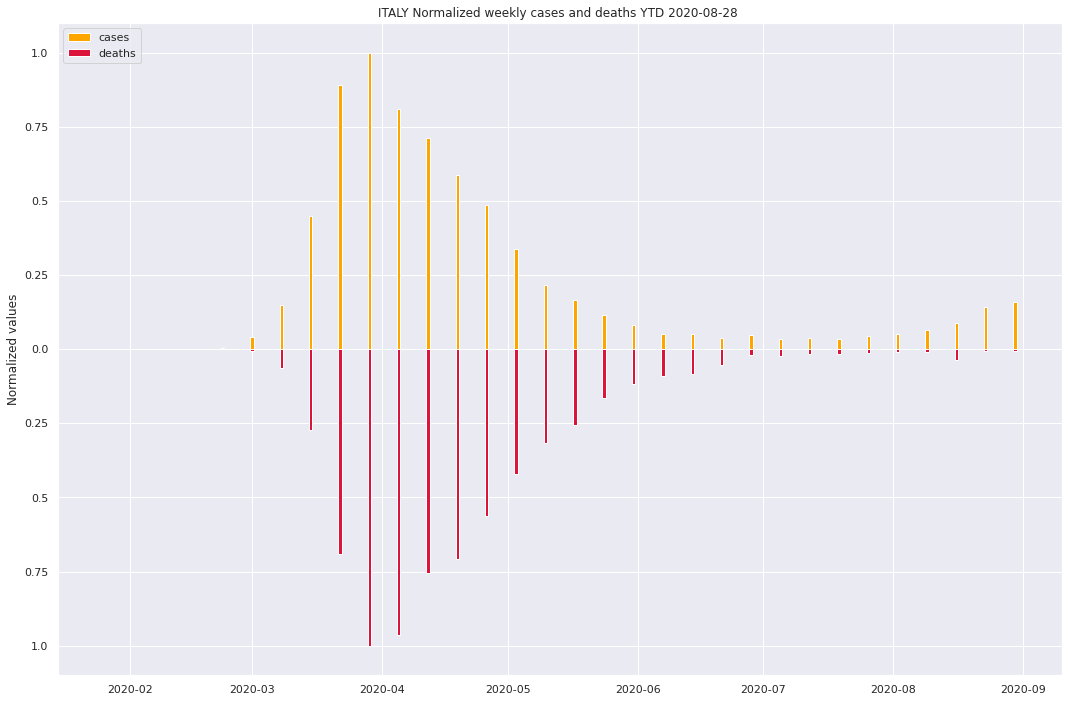

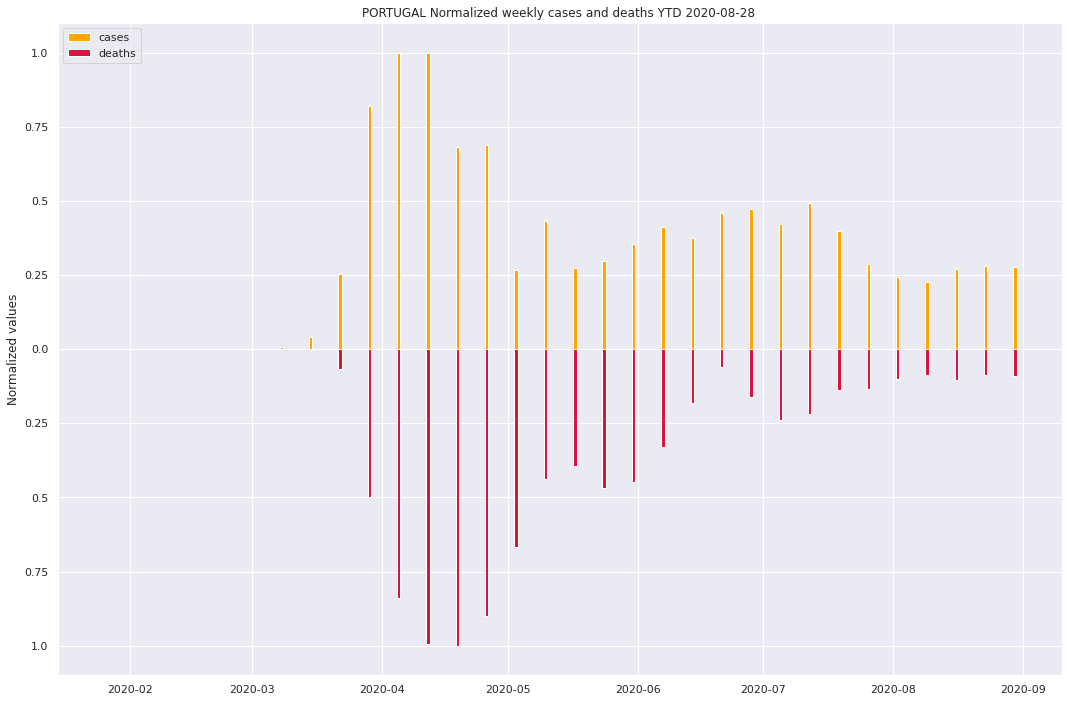

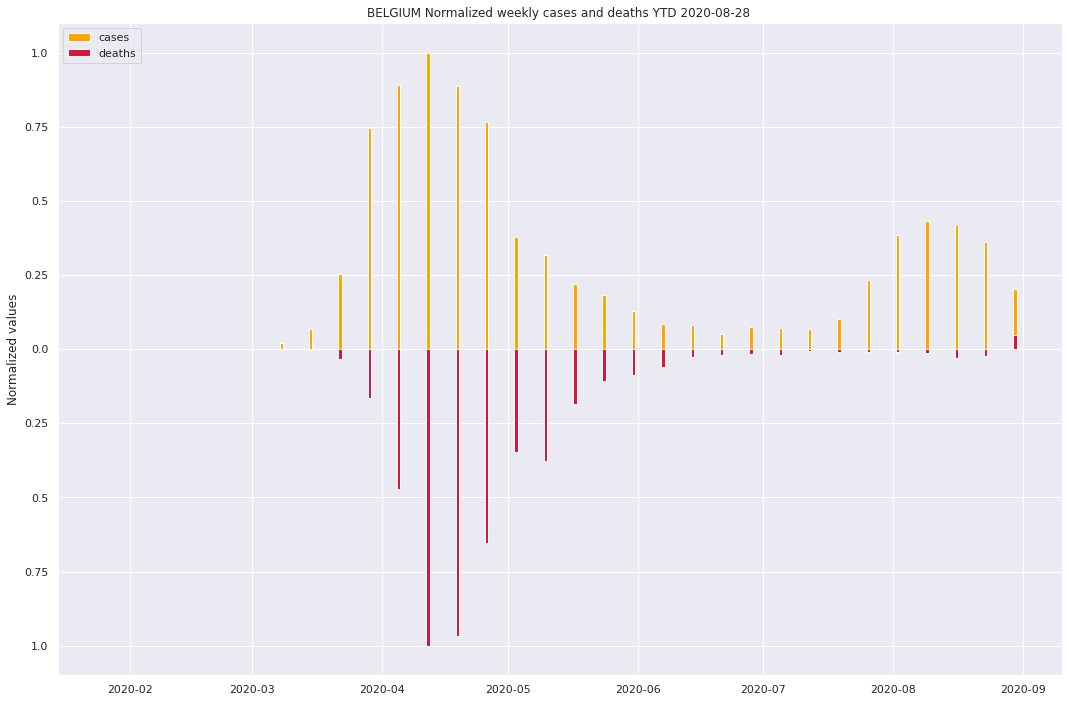

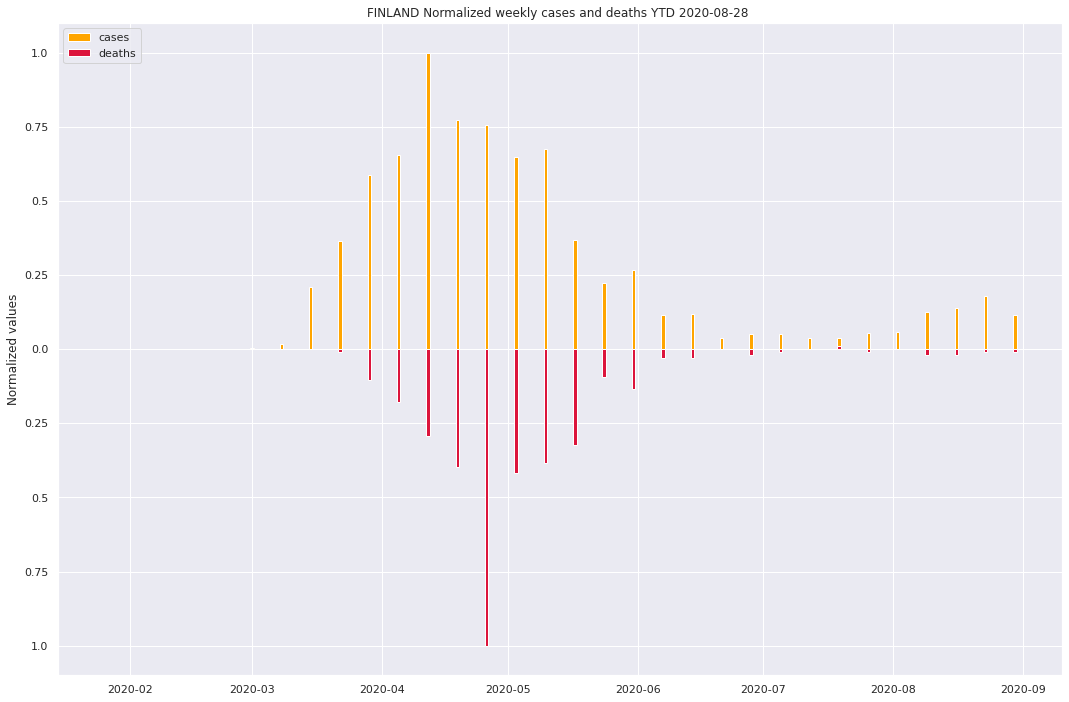

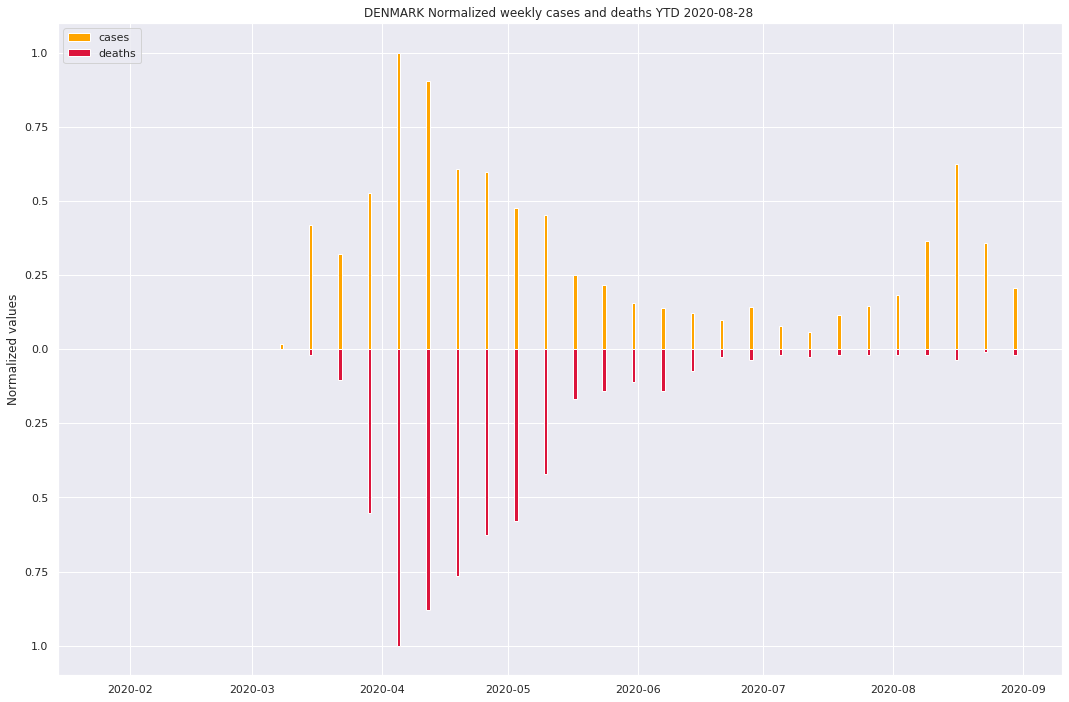

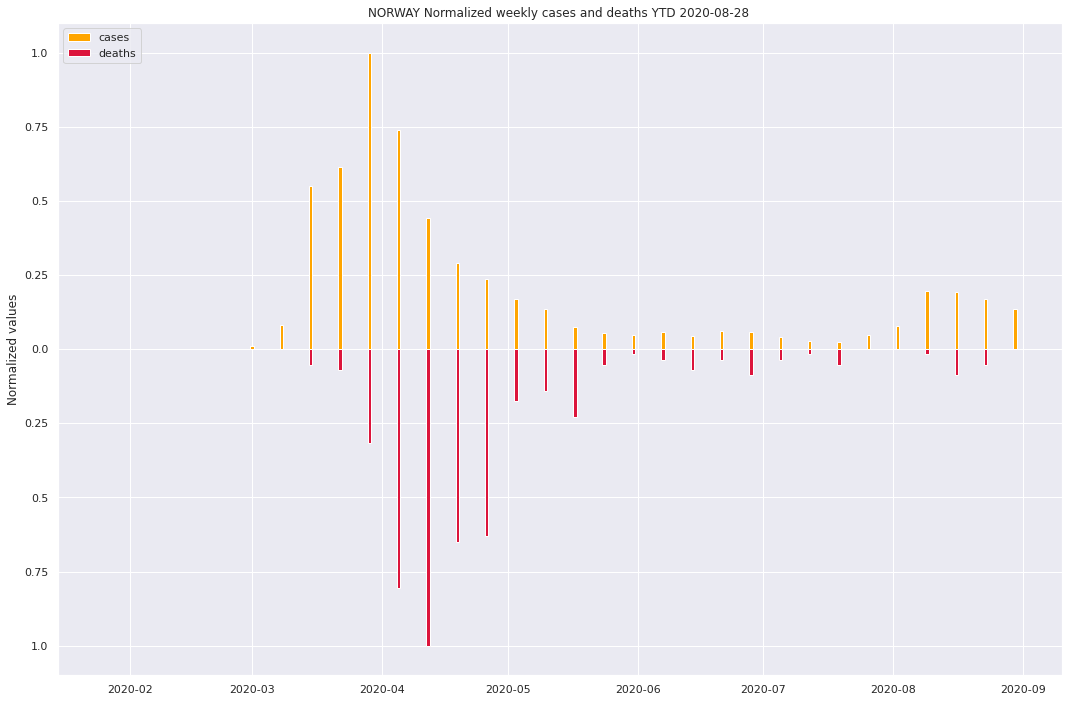

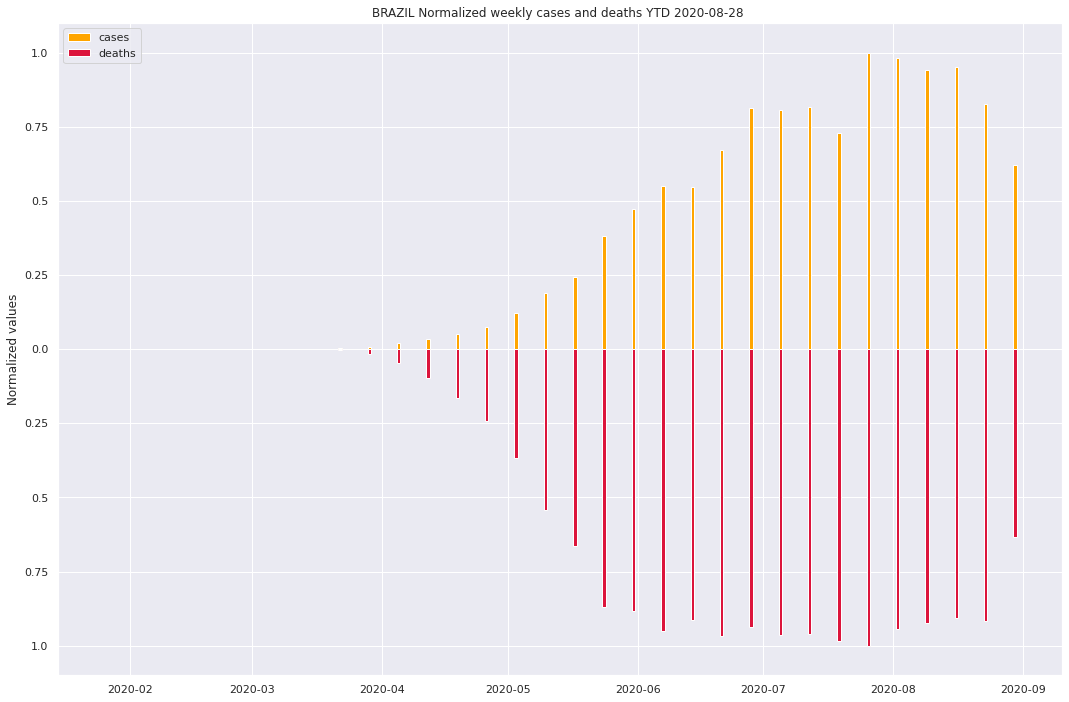

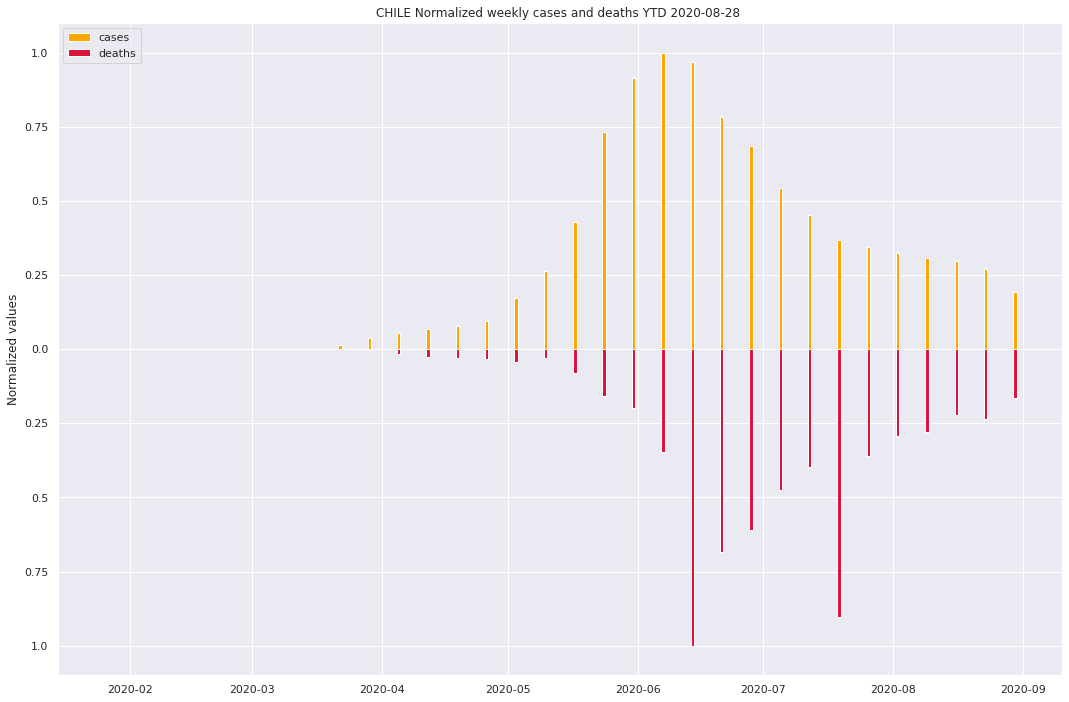

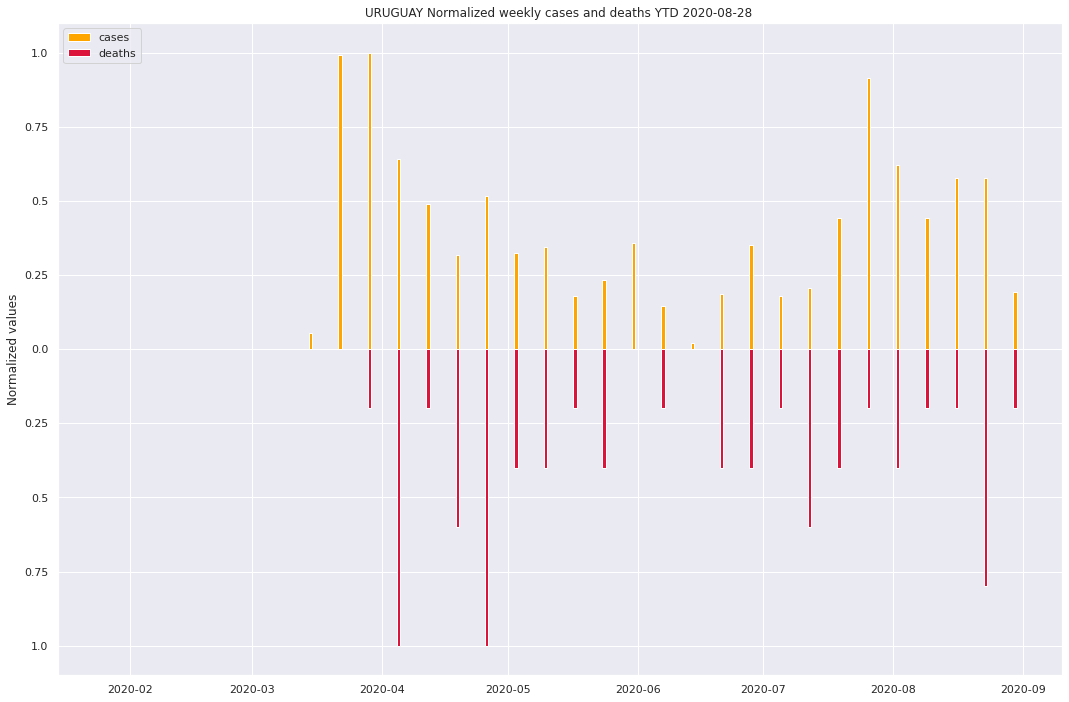

In [23]:
countries = ['New Zealand','Australia','Netherlands','Sweden','Peru','South Africa','Argentina','Germany',
            'United Kingdom','US','Spain','Italy','Portugal','Belgium','Finland','Denmark','Norway','Brazil',
            'Chile','Uruguay']

for c in countries:
    reflexive_plot(c)
    

In [24]:
sa = dick['South Africa'].resample('w').sum()
sa

confirmed     factor      inc  deceased  dead_factor  dead_inc  \
2020-01-26          0   0.000000      0.0         0     0.000000       0.0   
2020-02-02          0   0.000000      0.0         0     0.000000       0.0   
2020-02-09          0   0.000000      0.0         0     0.000000       0.0   
2020-02-16          0   0.000000      0.0         0     0.000000       0.0   
2020-02-23          0   0.000000      0.0         0     0.000000       0.0   
2020-03-01          0   0.000000      0.0         0     0.000000       0.0   
2020-03-08          6   5.000000      3.0         0     0.000000       0.0   
2020-03-15        153  10.835372     48.0         0     0.000000       0.0   
2020-03-22       1106   9.056210    223.0         0     0.000000       0.0   
2020-03-29       6229   8.787536   1006.0         4     3.000000       2.0   
2020-04-05      10266   7.262407    375.0        47     9.188889       9.0   
2020-04-12      13418   7.278882    518.0       135     7.933858      14.0   
2020-04-19      18773   7.385076    985.0       292     7.871152      29.0   
2020-04-26      27480   7.374887   1388.0       508     7.502179      33.0   
2020-05-03      39856   7.412136   2237.0       759     7.426942      44.0   
2020-05-10      59162   7.401375   3232.0      1158     7.405515      63.0   
2020-05-17      90209   7.451874   5500.0      1641     7.317710      70.0   
2020-05-24     134824   7.385767   7068.0      2539     7.504400     165.0   
2020-05-31     194109   7.380165  10100.0      4071     7.482841     254.0   
2020-06-07     286178   7.401978  15602.0      5958     7.390379     315.0   
2020-06-14     415560   7.382177  21753.0      8993     7.406089     482.0   
2020-06-21     591867   7.336738  27264.0     12242     7.271075     450.0   
2020-06-28     832393   7.359426  40832.0     15799     7.245773     526.0   
2020-07-05    1184718   7.362894  58616.0     19956     7.269733     743.0   
2020-07-12    1675693   7.347826  79492.0     26044     7.247607     880.0   
2020-07-19    2274159   7.282338  88086.0     32425     7.213701     954.0   
2020-07-26    2860055   7.203977  81105.0     42341     7.305176    1736.0   
2020-08-02    3373540   7.139690  66052.0     54157     7.215317    1597.0   
2020-08-09    3764764   7.090976  48374.0     66852     7.222120    2042.0   
2020-08-16    4021629   7.048105  27486.0     78724     7.130132    1431.0   
2020-08-23    4198186   7.037579  22428.0     88176     7.098864    1220.0   
2020-08-30    3701137   6.020776  12778.0     81321     6.068647     922.0   

             pct_dead  conf_over_dead  dead_conf_ratio    conf_per_M  \
2020-01-26   0.000000        0.000000         0.000000      0.000000   
2020-02-02   0.000000        0.000000         0.000000      0.000000   
2020-02-09   0.000000        0.000000         0.000000      0.000000   
2020-02-16   0.000000        0.000000         0.000000      0.000000   
2020-02-23   0.000000        0.000000         0.000000      0.000000   
2020-03-01   0.000000        0.000000         0.000000      0.000000   
2020-03-08   0.000000        0.000000         0.000000      0.101166   
2020-03-15   0.000000        0.000000         0.000000      2.579723   
2020-03-22   0.000000        0.000000         0.000000     18.648195   
2020-03-29   0.325966     2997.000000         2.840366    105.026768   
2020-04-05   3.130592     1774.787879         8.874344    173.094364   
2020-04-12   6.942776      736.481239         7.631213    226.240033   
2020-04-19  10.726221      474.056944         7.472061    316.530343   
2020-04-26  12.874754      381.647572         7.120099    463.338509   
2020-05-03  13.310277      368.335521         7.013619    672.009448   
2020-05-10  13.693979      357.884900         7.003843    997.526669   
2020-05-17  12.777124      383.985431         6.875198   1521.008136   
2020-05-24  13.144854      373.327755         7.113070   2273.258775   
2020-05-31  14.686040      333.748781         7.099847   3272.859340 